In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, Lasso, Ridge, RidgeClassifier, SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support, f1_score, r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint, gamma as sp_gamma, expon as sp_expon, uniform as sp_uniform
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import cPickle as pickle

In [2]:
df_features = pd.read_csv('../data/modeling/SPORTS/feature_data_SPORTS_21205.csv', sep='|')
df_targets = pd.read_csv('../data/modeling/SPORTS/target_data_SPORTS_21205.csv', sep='|')

df_features = df_features.set_index('owner').set_index("id", append=True)

df_targets = df_targets.set_index('owner').set_index("id", append=True)

df_targets = df_targets.drop('image_tags', axis=1)

target_columns = list(df_targets.columns)
target_columns.remove('image_ntags')
target_columns

df = df_features.join(df_targets, how='inner')

df.dropna(axis=0, inplace=True)

In [3]:
def name_quantile(x, limits):
    quantile_cats = range(1, len(limits)+1, 1)
    for cat, limit in zip(quantile_cats, limits):
        if x <= limit:
            return cat

def create_quantile_target_col(df_train, df_test, target_columns, col_name, n_quantiles=5):
    """
    Create a new column in both DataFrames that bins a target column into equal size categories.
    
    PARAMETERS
    ----------
    df_train : pandas.DataFrame
        The training set data.
        
    df_test : pandas.DataFrame
        The testint set data.
        
    target_columns : list
    
    col_name : str
    
    n_quantiles : int
        The number of bins. For 4 bins (0 to 0.25, 0.25 to 0.5, etc...), n_quantiles=4.

    RETURNS
    -------
    df_train : pandas.DataFrame
    
    df_test : pandas.DataFrame
    
    target_columns : list        
    """
    min_value = df_train[col_name].min()
    limits = []
    for i in range(1, n_quantiles+1):
        limits.append(df_train[col_name].quantile(i/float(n_quantiles)))
    
    new_col_name = col_name+"_quantile"
    target_columns.append(new_col_name)
    
    df_train.loc[:, new_col_name] = df_train[col_name].apply(lambda x: name_quantile(x, limits))
    df_test.loc[:, new_col_name] = df_test[col_name].apply(lambda x: name_quantile(x, limits))
    limits.insert(0, min_value)
    return df_train, df_test, target_columns, limits

def pop_columns(df, col_names):
    for i, name in enumerate(list(col_names)):
        if i == 0:
            df_dropped_cols = df.pop(name)
        else:
            df_dropped_cols = pd.concat((df_dropped_cols, df.pop(name)), axis=1)
    return df, df_dropped_cols

def create_known_bins_target_col(df_train, df_test, target_columns, col_name, bin_seps):
    """
    Create a new column in both DataFrames that bins a target column by designated boundaries.
    
    PARAMETERS
    ----------
    df_train : pandas.DataFrame
        The training set data.
        
    df_test : pandas.DataFrame
        The testint set data.
        
    target_columns : list
    
    col_name : str
    
    bin_seps : list
        The inner dividing limits for bins. Outer limits max() and min() are calculated automatically.

    
    RETURNS
    -------
    df_train : pandas.DataFrame
    
    df_test : pandas.DataFrame
    
    target_columns : list
    
    bin_limits : list
        Bin dividing limits inlcuding the max and min values from the column.
    """
    bin_seps = list(bin_seps)
    min_value = df_train[col_name].min()
    max_value = df_train[col_name].max()
    if bin_seps[-1] != max_value:
        bin_seps.append(max_value)

    new_col_name = col_name+"_binning"
    target_columns.append(new_col_name)
    
    df_train.loc[:, new_col_name] = df_train[col_name].apply(lambda x: name_quantile(x, limits))
    df_test.loc[:, new_col_name] = df_test[col_name].apply(lambda x: name_quantile(x, limits))
    if bin_seps[0] != min_value:
        limits.insert(0, min_value)
    return df_train, df_test, target_columns, limits

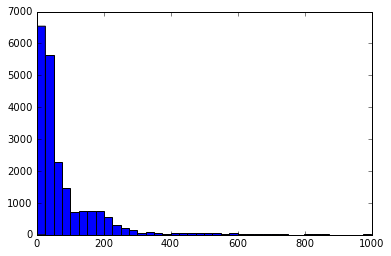

In [87]:
plt.hist(df['image_views'][df['image_views']<1000], bins=40)
plt.show()

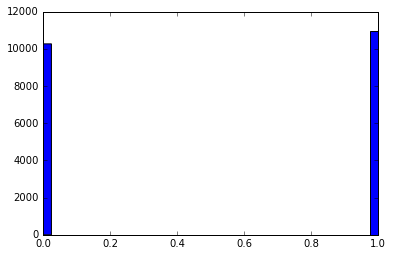

In [83]:
plt.hist(df['user_is_pro'], bins=40)
plt.show()

In [ ]:
plt.hist(df['image_ncomments'], bins=40)
plt.show()

In [4]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

In [5]:
df_train, df_test, target_columns, image_views_limits = create_quantile_target_col(df_train, df_test, target_columns, 'image_views', 4)
df_train, df_test, target_columns, image_views_limits = create_quantile_target_col(df_train, df_test, target_columns, 'image_views', 4)
#df_train, df_test, target_columns = create_quantile_target_col(df_train, df_test, target_columns, 'image_ncomments', 4)
#df_train, df_test, target_columns = create_quantile_target_col(df_train, df_test, target_columns, 'image_nfavs', 4)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
X_train, y_train = pop_columns(df_train, target_columns)
X_test, y_test = pop_columns(df_test, target_columns)

In [7]:
X_columns = X_train.columns
y_columns = y_train.columns

In [8]:
scaler_mean_std = StandardScaler()
X_train = scaler_mean_std.fit_transform(X_train)
X_test = scaler_mean_std.transform(X_test)

In [9]:
X_train = pd.DataFrame(data=X_train, columns=X_columns)
X_test = pd.DataFrame(data=X_test, columns=X_columns)

In [10]:
y_train.head(1)

,,user_is_pro,user_can_buy_pro,user_total_views,image_ncomments,image_nfavs,image_nsets,image_npools,image_views,image_views_quantile,image_ncomments_quantile,image_nfavs_quantile
owner,id,,,,,,,,,,,
12385792@N00,11378305226,1,0,7760,0,0,1,0,6,1,1,1


### GRID SEARCH - Image Views Quantile (IVQ)

#### Set Search Parameters

In [107]:
param_distributions = {'Logistic': {"C": sp_expon(loc=0.001, scale=1),
                                    "fit_intercept": [True, False],
                                    "intercept_scaling": sp_randint(1, 5),
                                    "warm_start": [False, True]
                                    },
                       'RandomForest': {"max_depth": [None],
                                        "max_features": ['auto', None],
                                        "min_samples_split": sp_randint(1, 201),
                                        "min_samples_leaf": sp_randint(1, 201),
                                        "criterion": ["gini", "entropy"],
                                        "oob_score": [True],
                                        "warm_start": [False, True] 
                                        },
                       'AdaBoost_DT': {"learning_rate": sp_expon(loc=0.001, scale=1.5),
                                       "algorithm" : ['SAMME.R', 'SAMME']
                                       },
                       'GBC': {"learning_rate": sp_expon(loc=0.001, scale=0.5),
                               "subsample": sp_uniform(loc=0.2, scale=0.8),
                               "max_features": [None, 'auto'],
                               "warm_start": [True, False],
                               "max_depth": [3, 4, 5],
                               },
                       'SVC': {"C": sp_expon(loc=0.001, scale=2),
                               "kernel": ['rbf', 'poly'],
                               "degree": sp_randint(2, 10),
                               "coef0": [0, 1, 2],
                               "shrinking": [True, False]
                               }
                       }

#### Build Models (IVQ)

In [29]:
DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=10, min_samples_leaf=10,
      min_weight_fraction_leaf=0.0, max_features=300, random_state=30, max_leaf_nodes=20, class_weight=None,
      presort=False)

model_ivq_LogitClassifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                               class_weight=None, random_state=25,
                                               solver='liblinear', max_iter=1000, multi_class='ovr', verbose=2,
                                               n_jobs=36)

model_ivq_RandomForest = RandomForestClassifier(n_estimators=1000, min_weight_fraction_leaf=0.0, n_jobs=36,
                                                random_state=42, verbose=2, class_weight=None, bootstrap=True)

model_ivq_AdaBoost_DT = AdaBoostClassifier(base_estimator=DT, n_estimators=300, random_state=12)

model_ivq_GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0,
                                           random_state=21, verbose=0,
                                           max_leaf_nodes=12, presort='auto')

model_ivq_SVC = SVC(gamma='auto', probability=True,
                    tol=0.001, cache_size=1000, class_weight=None, verbose=True, max_iter=-1,
                    decision_function_shape='ovr', random_state=1)


#### Logistic Random Search CV

In [ ]:
n_iter_search = 30
random_search_LogitClassifier = RandomizedSearchCV(estimator=model_ivq_LogitClassifier,
                                                   param_distributions=param_distributions['Logistic'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_LogitClassifier.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_LogitClassifier.grid_scores_

In [ ]:
random_search_LogitClassifier.best_score_

In [ ]:
best_LogitClassifier = random_search_LogitClassifier.best_estimator_
y_pred = best_LogitClassifier.predict(X_test)
print "Best Logit Classifier F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### Random Forest Random Search CV

In [ ]:
n_iter_search = 30
random_search_RandomForest = RandomizedSearchCV(estimator=model_ivq_RandomForest,
                                                   param_distributions=param_distributions['RandomForest'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_RandomForest.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_RandomForest.best_score_

In [ ]:
best_RandomForest = random_search_RandomForest.best_estimator_
y_pred = best_RandomForest.predict(X_test)
print "Best Random Forest Classifier F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### AdaBoost DT Random Search CV

In [ ]:
n_iter_search = 30
random_search_AdaBoost_DT = RandomizedSearchCV(estimator=model_ivq_AdaBoost_DT,
                                                   param_distributions=param_distributions['AdaBoost_DT'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_AdaBoost_DT.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_AdaBoost_DT.best_score_

In [ ]:
best_AdaBoost_DT = random_search_AdaBoost_DT.best_estimator_
y_pred = best_AdaBoost_DT.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

#### Gradient Boost Classifier Random Search CV

In [30]:
n_iter_search = 40
random_search_GBC = RandomizedSearchCV(estimator=model_ivq_GBC,
                                       param_distributions=param_distributions['GBC'],
                                       n_iter=n_iter_search,
                                       n_jobs=36, cv=5, verbose=1, random_state=30, error_score='raise')
random_search_GBC.fit(X_train, y_train['image_views_quantile'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed: 67.9min
[Parallel(n_jobs=36)]: Done 200 out of 200 | elapsed: 95.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=12,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=21, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=40, n_jobs=36,
          param_distributions={'max_features': [None, 'auto'], 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9cf850c6d0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9cf851b850>, 'warm_start': [True, False], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=30, refit=True,
          scoring=None, verbose=1)

In [31]:
random_search_GBC.best_score_

0.73614713510964391

In [32]:
best_GBC = random_search_GBC.best_estimator_
y_pred = best_GBC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

Best AdaBoost DT F1 Score:  0.745162994441


In [43]:
new_params = best_GBC.get_params()
new_params['n_estimators'] = 1000
new_params['verbose'] = 2

In [44]:
new_model_ivq_GBC = GradientBoostingClassifier(**new_params)

In [45]:
new_model_ivq_GBC.fit(X_train, y_train['image_views_quantile'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       17394.7394         428.4469          202.13m
         2       15607.2196         226.9874          200.65m
         3       14446.7362         150.6848          198.27m
         4       13650.8799          92.1420          199.15m
         5       13094.3819          61.0891          200.64m
         6       12598.4263          49.5992          200.76m
         7       12259.9390          38.7950          201.24m
         8       11946.5230          31.4153          199.45m
         9       11697.0205          21.0329          197.50m
        10       11451.6005          20.4354          196.28m
        11       11239.4997           9.9764          195.64m
        12       11049.8318          12.8838          195.18m
        13       10847.9050          17.0746          194.48m
        14       10662.2817           9.7841          192.52m
        15       10520.7765          11.0092          192.04m
       

GradientBoostingClassifier(init=None, learning_rate=0.265159939001,
              loss='deviance', max_depth=5, max_features=None,
              max_leaf_nodes=12, min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=21, subsample=0.884928788086,
              verbose=2, warm_start=False)

In [49]:
new_model_ivq_GBC.get_params()

{'init': None,
 'learning_rate': 0.2651599390014479,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'presort': 'auto',
 'random_state': 21,
 'subsample': 0.8849287880855492,
 'verbose': 2,
 'warm_start': False}

In [50]:
f1_scores = []
num_estimators = new_model_ivq_GBC.get_params()['n_estimators']

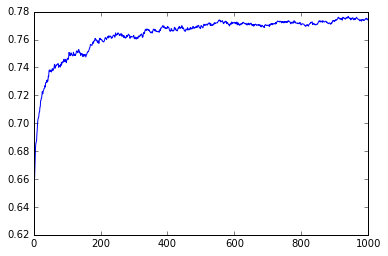

In [51]:
for i, y_pred in zip(range(1, num_estimators+1), new_model_ivq_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='weighted', sample_weight=None))

plt.plot(f1_scores, 'b')

In [53]:
with open('../models/model_GBC_IVQ_1000.pkl', 'w') as f:
    pickle.dump(new_model_ivq_GBC, f)

#### SVC Random Search CV

In [ ]:
n_iter_search = 30
random_search_SVC = RandomizedSearchCV(estimator=model_ivq_SVC,
                                                   param_distributions=param_distributions['SVC'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score='raise')
random_search_SVC.fit(X_train, y_train['image_views_quantile'])

In [ ]:
random_search_SVC.best_score_

In [ ]:
best_SVC = random_search_SVC.best_estimator_
y_pred = best_SVC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

### GRID SEARCH - User Is Pro (UiP)

In [108]:
param_distributions_uip = {'Logistic': {"C": sp_expon(loc=0.001, scale=1),
                                    "fit_intercept": [True, False],
                                    "intercept_scaling": sp_randint(1, 5),
                                    "warm_start": [False, True]
                                    },
                       'RandomForest': {"max_depth": [None],
                                        "max_features": ['auto', None],
                                        "min_samples_split": sp_randint(1, 201),
                                        "min_samples_leaf": sp_randint(1, 201),
                                        "criterion": ["gini", "entropy"],
                                        "oob_score": [True],
                                        "warm_start": [False, True] 
                                        },
                       'AdaBoost_DT': {"learning_rate": sp_expon(loc=0.001, scale=1.5),
                                       "algorithm" : ['SAMME.R', 'SAMME']
                                       },
                       'GBC': {"learning_rate": sp_expon(loc=0.001, scale=0.5),
                               "subsample": sp_uniform(loc=0.2, scale=0.8),
                               "max_features": [None, 'auto'],
                               "warm_start": [True, False],
                               "max_depth": [3, 4, 5],
                               },
                       'SVC': {"C": sp_expon(loc=0.001, scale=2),
                               "kernel": ['rbf', 'poly'],
                               "degree": sp_randint(2, 10),
                               "coef0": [0, 1, 2],
                               "shrinking": [True, False]
                               }
                       }

#### Build Models (UiP)

In [90]:
DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=10, min_samples_leaf=10,
      min_weight_fraction_leaf=0.0, max_features=300, random_state=30, max_leaf_nodes=20, class_weight=None,
      presort=False)

model_uip_LogitClassifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                               class_weight=None, random_state=25,
                                               solver='liblinear', max_iter=1000, multi_class='ovr', verbose=2,
                                               n_jobs=36)

model_uip_RandomForest = RandomForestClassifier(n_estimators=1000, min_weight_fraction_leaf=0.0, n_jobs=36,
                                                random_state=42, verbose=1, class_weight=None, bootstrap=True)

model_uip_AdaBoost_DT = AdaBoostClassifier(base_estimator=DT, n_estimators=300, random_state=12)

model_uip_GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0,
                                           random_state=21, verbose=0,
                                           max_leaf_nodes=12, presort='auto')

model_uip_SVC = SVC(gamma='auto', probability=True,
                    tol=0.001, cache_size=1000, class_weight=None, verbose=True, max_iter=-1,
                    decision_function_shape='ovr', random_state=1)


#### GB Classifier Random Search (UIP)

In [91]:
n_iter_search = 20
random_search_uip_GBC = RandomizedSearchCV(estimator=model_uip_GBC,
                                       param_distributions=param_distributions_uip['GBC'],
                                       n_iter=n_iter_search,
                                       n_jobs=36, cv=3, verbose=1, random_state=30, error_score=0)
random_search_uip_GBC.fit(X_train, y_train['user_is_pro'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=36)]: Done  60 out of  60 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, error_score=0,
          estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=12,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=21, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=36,
          param_distributions={'max_features': [None, 'auto'], 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce20456d0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce2045610>, 'warm_start': [True, False], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=30, refit=True,
          scoring=None, verbose=1)

In [92]:
random_search_uip_GBC.best_score_

0.89860881867484088

In [93]:
best_uip_GBC = random_search_uip_GBC.best_estimator_
y_pred = best_uip_GBC.predict(X_test)
print "Best AdaBoost DT F1 Score: ", f1_score(y_test['user_is_pro'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

Best AdaBoost DT F1 Score:  0.917800606676


In [94]:
new_params = best_uip_GBC.get_params()
new_params['n_estimators'] = 1000
new_params['verbose'] = 2

In [95]:
new_model_uip_GBC = GradientBoostingClassifier(**new_params)
new_model_uip_GBC.fit(X_train, y_train['user_is_pro'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1531           0.2234           47.29m
         2           1.0152           0.1366           48.35m
         3           0.9236           0.0878           47.93m
         4           0.8661           0.0572           48.71m
         5           0.8111           0.0470           48.63m
         6           0.7747           0.0413           48.85m
         7           0.7424           0.0293           49.13m
         8           0.7155           0.0253           49.27m
         9           0.6988           0.0147           49.22m
        10           0.6787           0.0130           49.07m
        11           0.6558           0.0203           49.15m
        12           0.6435           0.0132           49.13m
        13           0.6274           0.0124           49.06m
        14           0.6131           0.0098           49.08m
        15           0.6016           0.0061           49.16m
       

GradientBoostingClassifier(init=None, learning_rate=0.279348533753,
              loss='deviance', max_depth=5, max_features=None,
              max_leaf_nodes=12, min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=21, subsample=0.87849357888,
              verbose=2, warm_start=True)

In [96]:
new_model_uip_GBC.get_params()

{'init': None,
 'learning_rate': 0.2793485337531958,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'presort': 'auto',
 'random_state': 21,
 'subsample': 0.8784935788800639,
 'verbose': 2,
 'warm_start': True}

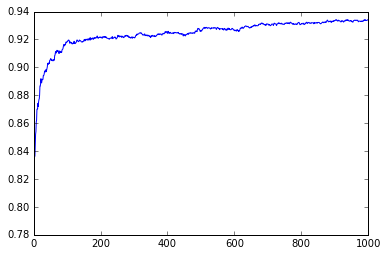

In [97]:
f1_scores = []
num_estimators = new_model_uip_GBC.get_params()['n_estimators']
for i, y_pred in zip(range(1, num_estimators+1), new_model_uip_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['user_is_pro'], y_pred, labels=None, pos_label=None, average='weighted', sample_weight=None))

plt.plot(f1_scores, 'b')

#### Logistic Random Search CV (UiP)

In [99]:
n_iter_search = 30
random_search_uip_LogitClassifier = RandomizedSearchCV(estimator=model_uip_LogitClassifier,
                                                   param_distributions=param_distributions_uip['Logistic'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=2, random_state=30, error_score=0)
random_search_uip_LogitClassifier.fit(X_train, y_train['user_is_pro'])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] warm_start=True, C=0.6945379214, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.6945379214, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.6945379214, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.6945379214, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.6945379214, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.812731324897, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.812731324897, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.812731324897, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.812731324897, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=True, C=0.812731324897, intercept_scaling=2, fit_intercept=False 
[CV] warm_start=False, C=0.979976838888, intercept_scaling=3, fit_intercept=True 
[CV] warm_start=False, C=0.979976838888, inter

[Parallel(n_jobs=36)]: Done 150 out of 150 | elapsed: 14.6min finished


[LibLinear]

RandomizedSearchCV(cv=5, error_score=0,
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=36,
          penalty='l2', random_state=25, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False),
          fit_params={}, iid=True, n_iter=30, n_jobs=36,
          param_distributions={'warm_start': [False, True], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce2039c10>, 'intercept_scaling': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ce2039e10>, 'fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=30, refit=True,
          scoring=None, verbose=2)

In [100]:
random_search_uip_LogitClassifier.best_score_

0.78277528884697001

In [101]:
best_uip_LogitClassifier = random_search_uip_LogitClassifier.best_estimator_
y_pred = best_uip_LogitClassifier.predict(X_test)
print "Best Logit Classifier F1 Score: ", f1_score(y_test['user_is_pro'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

Best Logit Classifier F1 Score:  0.7903526626


#### Random Forest Search CV (UiP)

In [111]:
n_iter_search = 30
random_search_uip_RandomForest = RandomizedSearchCV(estimator=model_uip_RandomForest,
                                                   param_distributions=param_distributions_uip['RandomForest'],
                                                   n_iter=n_iter_search,
                                                   n_jobs=36, cv=5, verbose=0, random_state=30, error_score=0)
random_search_uip_RandomForest.fit(X_train, y_train['user_is_pro'])

building tree 1 of 1000
 building tree 3 of 1000
 building tree 2 of 1000
 building tree 5 of 1000
 building tree 6 of 1000
 building tree 4 of 1000
building tree 7 of 1000
building tree 8 of 1000
 building tree 9 of 1000
 building tree 10 of 1000
 building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
 building tree 15 of 1000
 building tree 14 of 1000
 building tree 16 of 1000
building tree 18 of 1000
building tree 17 of 1000
building tree 19 of 1000
 building tree 20 of 1000
building tree 21 of 1000
 building tree 22 of 1000
building tree 23 of 1000
 building tree 24 of 1000
building tree 25 of 1000
 building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
 building tree 32 of 1000
building tree 34 of 1000
 building tree 33 of 1000
building tree 31 of 1000
 building tree 35 of 1000
 building tree 36 of 1000
 building tree 2 of 1000
building tree 3 of 1000
building tree 1 of 1000
building tree 4 o

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   15.1s


building tree 126 of 1000
 building tree 66 of 1000
 building tree 67 of 1000
 building tree 68 of 1000
building tree 69 of 1000
building tree 81 of 1000
 building tree 82 of 1000
building tree 83 of 1000
building tree 127 of 1000
building tree 75 of 1000
building tree 84 of 1000
building tree 75 of 1000
 building tree 85 of 1000
building tree 76 of 1000
building tree 86 of 1000
 building tree 77 of 1000
building tree 112 of 1000
 building tree 87 of 1000
building tree 76 of 1000
building tree 78 of 1000
building tree 70 of 1000
 building tree 71 of 1000
building tree 77 of 1000
building tree 79 of 1000
building tree 113 of 1000
building tree 88 of 1000
building tree 72 of 1000
 building tree 15 of 1000
 building tree 114 of 1000
 building tree 89 of 1000
building tree 78 of 1000
 building tree 4 of 1000
 building tree 20 of 1000
 building tree 25 of 1000
 building tree 26 of 1000
 building tree 27 of 1000
 building tree 2 of 1000
 building tree 18 of 1000
 building tree 6 of 1000
 bui

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   18.2s


building tree 126 of 1000
building tree 96 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 103 of 1000
 building tree 104 of 1000
building tree 97 of 1000
building tree 129 of 1000
building tree 105 of 1000
 building tree 130 of 1000
building tree 91 of 1000
building tree 137 of 1000
building tree 106 of 1000
building tree 98 of 1000
building tree 131 of 1000
 building tree 107 of 1000
building tree 92 of 1000
 building tree 14 of 1000
 building tree 5 of 1000
 building tree 3 of 1000
 building tree 7 of 1000
 building tree 4 of 1000
 building tree 6 of 1000
 building tree 9 of 1000
building tree 1 of 1000
 building tree 11 of 1000
 building tree 2 of 1000
 building tree 16 of 1000
 building tree 10 of 1000
 building tree 8 of 1000
 building tree 13 of 1000
 building tree 15 of 1000
 building tree 12 of 1000
building tree 99 of 1000
 building tree 20 of 1000
building tree 100 of 1000
building tree 21 of 1000
 building tree 18 of 1000
 building tree 19 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   20.7s


 building tree 127 of 1000
building tree 119 of 1000
building tree 125 of 1000
 building tree 158 of 1000
building tree 159 of 1000
 building tree 126 of 1000
building tree 169 of 1000
building tree 120 of 1000
 building tree 123 of 1000
building tree 121 of 1000
 building tree 122 of 1000
building tree 62 of 1000
 building tree 63 of 1000
building tree 160 of 1000
building tree 170 of 1000
building tree 121 of 1000
building tree 103 of 1000
 building tree 161 of 1000
building tree 64 of 1000
building tree 128 of 1000
building tree 124 of 1000
building tree 65 of 1000
 building tree 66 of 1000
building tree 104 of 1000
building tree 129 of 1000
 building tree 130 of 1000
building tree 162 of 1000
building tree 171 of 1000
 building tree 163 of 1000
building tree 122 of 1000
building tree 131 of 1000
building tree 73 of 1000
building tree 105 of 1000
 building tree 74 of 1000
building tree 164 of 1000
building tree 125 of 1000
building tree 67 of 1000
building tree 123 of 1000
 building

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   20.8s


building tree 126 of 1000
building tree 106 of 1000
building tree 165 of 1000
building tree 124 of 1000
 building tree 125 of 1000
 building tree 127 of 1000
building tree 172 of 1000
building tree 69 of 1000
building tree 128 of 1000
building tree 107 of 1000
building tree 134 of 1000
 building tree 135 of 1000
building tree 136 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   20.0s


building tree 129 of 1000
building tree 166 of 1000
building tree 126 of 1000
 building tree 167 of 1000
building tree 130 of 1000
building tree 168 of 1000
building tree 127 of 1000
building tree 169 of 1000
building tree 131 of 1000
 building tree 138 of 1000
 building tree 139 of 1000
building tree 137 of 1000
building tree 75 of 1000
 building tree 132 of 1000
building tree 108 of 1000
building tree 173 of 1000
building tree 39 of 1000
building tree 170 of 1000
building tree 40 of 1000
building tree 70 of 1000
building tree 128 of 1000
 building tree 71 of 1000
 building tree 129 of 1000
building tree 140 of 1000
 building tree 141 of 1000
building tree 41 of 1000
building tree 174 of 1000
building tree 142 of 1000
building tree 171 of 1000
building tree 42 of 1000
building tree 175 of 1000
building tree 143 of 1000
building tree 130 of 1000
 building tree 131 of 1000
building tree 144 of 1000
building tree 132 of 1000
 building tree 134 of 1000
building tree 133 of 1000
building t

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   23.7s


building tree 126 of 1000
building tree 150 of 1000
building tree 197 of 1000
 building tree 5 of 1000
 building tree 7 of 1000
building tree 1 of 1000
 building tree 24 of 1000
 building tree 23 of 1000
 building tree 6 of 1000
 building tree 4 of 1000
 building tree 13 of 1000
 building tree 16 of 1000
 building tree 11 of 1000
 building tree 8 of 1000
 building tree 26 of 1000
 building tree 3 of 1000
 building tree 25 of 1000
 building tree 2 of 1000
 building tree 18 of 1000
 building tree 127 of 1000
building tree 188 of 1000
 building tree 9 of 1000
 building tree 30 of 1000
 building tree 12 of 1000
 building tree 17 of 1000
 building tree 32 of 1000
 building tree 27 of 1000
 building tree 10 of 1000
 building tree 19 of 1000
 building tree 14 of 1000
building tree 128 of 1000
 building tree 31 of 1000
 building tree 29 of 1000
 building tree 15 of 1000
 building tree 20 of 1000
 building tree 22 of 1000
 building tree 34 of 1000
 building tree 21 of 1000
 building tree 33 of 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   26.5s


building tree 190 of 1000
building tree 229 of 1000
building tree 127 of 1000
building tree 184 of 1000
 building tree 128 of 1000
 building tree 130 of 1000
building tree 129 of 1000
building tree 222 of 1000
building tree 230 of 1000
 building tree 150 of 1000
building tree 149 of 1000
building tree 109 of 1000
building tree 185 of 1000
building tree 182 of 1000
building tree 131 of 1000
 building tree 132 of 1000
building tree 106 of 1000
building tree 69 of 1000
building tree 231 of 1000
building tree 183 of 1000
building tree 151 of 1000
building tree 133 of 1000
building tree 152 of 1000
 building tree 153 of 1000
building tree 184 of 1000
building tree 70 of 1000
building tree 107 of 1000
building tree 154 of 1000
building tree 191 of 1000
building tree 223 of 1000
building tree 232 of 1000
building tree 155 of 1000
 building tree 156 of 1000
building tree 186 of 1000
 building tree 157 of 1000
building tree 108 of 1000
building tree 134 of 1000
building tree 233 of 1000
buildin

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   28.0s


building tree 125 of 1000
building tree 203 of 1000
 building tree 126 of 1000
building tree 173 of 1000
building tree 127 of 1000
building tree 174 of 1000
 building tree 128 of 1000
building tree 113 of 1000
 building tree 5 of 1000
 building tree 2 of 1000
building tree 1 of 1000
 building tree 6 of 1000
 building tree 7 of 1000
 building tree 10 of 1000
 building tree 14 of 1000
 building tree 4 of 1000
 building tree 12 of 1000
 building tree 3 of 1000
 building tree 28 of 1000
 building tree 20 of 1000
 building tree 31 of 1000
 building tree 11 of 1000
 building tree 23 of 1000
 building tree 19 of 1000
 building tree 9 of 1000
 building tree 33 of 1000
 building tree 8 of 1000
 building tree 13 of 1000
 building tree 15 of 1000
 building tree 24 of 1000
 building tree 17 of 1000
 building tree 25 of 1000
 building tree 30 of 1000
 building tree 26 of 1000
 building tree 22 of 1000
 building tree 16 of 1000
 building tree 32 of 1000
 building tree 34 of 1000
building tree 204 of

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   30.1s


building tree 262 of 1000
 building tree 126 of 1000
building tree 125 of 1000
building tree 142 of 1000
building tree 255 of 1000
building tree 82 of 1000
building tree 263 of 1000
building tree 220 of 1000
building tree 256 of 1000
building tree 83 of 1000
building tree 150 of 1000
 building tree 151 of 1000
building tree 221 of 1000
building tree 127 of 1000
building tree 84 of 1000
building tree 222 of 1000
building tree 143 of 1000
building tree 214 of 1000
building tree 180 of 1000
building tree 144 of 1000
building tree 216 of 1000
building tree 215 of 1000
 building tree 216 of 1000
building tree 128 of 1000
 building tree 181 of 1000
building tree 264 of 1000
 building tree 130 of 1000
building tree 129 of 1000
building tree 223 of 1000
building tree 152 of 1000
building tree 217 of 1000
building tree 153 of 1000
building tree 85 of 1000
building tree 154 of 1000
building tree 131 of 1000
building tree 145 of 1000
 building tree 86 of 1000
building tree 132 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   34.9s


building tree 164 of 1000
building tree 264 of 1000
building tree 126 of 1000
building tree 250 of 1000
building tree 181 of 1000
building tree 127 of 1000
building tree 259 of 1000
building tree 305 of 1000
building tree 222 of 1000
building tree 128 of 1000
building tree 251 of 1000
 building tree 252 of 1000
building tree 165 of 1000
building tree 129 of 1000
 building tree 166 of 1000
 building tree 254 of 1000
building tree 265 of 1000
building tree 306 of 1000
building tree 253 of 1000
building tree 307 of 1000
building tree 188 of 1000
building tree 266 of 1000
building tree 130 of 1000
 building tree 189 of 1000
building tree 190 of 1000
building tree 223 of 1000
building tree 131 of 1000
 building tree 191 of 1000
building tree 255 of 1000
building tree 260 of 1000
building tree 167 of 1000
building tree 192 of 1000
 building tree 256 of 1000
building tree 297 of 1000
building tree 267 of 1000
building tree 168 of 1000
 building tree 169 of 1000
building tree 298 of 1000
build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.2min


building tree 274 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 146 of 1000
building tree 200 of 1000
building tree 319 of 1000
building tree 201 of 1000
building tree 275 of 1000
 building tree 276 of 1000
building tree 186 of 1000
building tree 285 of 1000
building tree 284 of 1000
building tree 202 of 1000
building tree 277 of 1000
building tree 285 of 1000
 building tree 278 of 1000
building tree 279 of 1000
building tree 215 of 1000
building tree 330 of 1000
 building tree 331 of 1000
building tree 203 of 1000
building tree 249 of 1000
building tree 187 of 1000
building tree 320 of 1000
building tree 286 of 1000
building tree 286 of 1000
 building tree 287 of 1000
building tree 321 of 1000
building tree 204 of 1000
building tree 288 of 1000
building tree 332 of 1000
building tree 323 of 1000
 building tree 322 of 1000
building tree 287 of 1000
 building tree 205 of 1000
building tree 324 of 1000
 building tree 325 of 1000
building tree 206 of 1000
build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.3min


building tree 337 of 1000
 building tree 154 of 1000
building tree 329 of 1000
building tree 195 of 1000
 building tree 330 of 1000
building tree 292 of 1000
building tree 284 of 1000
building tree 219 of 1000
building tree 155 of 1000
building tree 285 of 1000
building tree 255 of 1000
building tree 156 of 1000
building tree 220 of 1000
building tree 286 of 1000
building tree 157 of 1000
building tree 212 of 1000
building tree 287 of 1000
building tree 338 of 1000
building tree 221 of 1000
building tree 158 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 213 of 1000
building tree 159 of 1000
building tree 256 of 1000
building tree 196 of 1000
building tree 339 of 1000
 building tree 257 of 1000
building tree 298 of 1000
 building tree 340 of 1000
building tree 160 of 1000
building tree 258 of 1000
building tree 341 of 1000
building tree 295 of 1000
building tree 214 of 1000
building tree 299 of 1000
 building tree 342 of 1000
building tree 259 of 1000
buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.4min


building tree 188 of 1000
building tree 328 of 1000
building tree 230 of 1000
building tree 318 of 1000
building tree 363 of 1000
building tree 330 of 1000
building tree 319 of 1000
building tree 287 of 1000
building tree 320 of 1000
building tree 331 of 1000
building tree 329 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.4min


building tree 331 of 1000
 building tree 330 of 1000
building tree 364 of 1000
building tree 373 of 1000
building tree 321 of 1000
building tree 332 of 1000
building tree 332 of 1000
building tree 322 of 1000
building tree 245 of 1000
building tree 189 of 1000
building tree 246 of 1000
building tree 323 of 1000
building tree 288 of 1000
building tree 254 of 1000
building tree 247 of 1000
building tree 365 of 1000
building tree 324 of 1000
building tree 333 of 1000
building tree 374 of 1000
building tree 190 of 1000
building tree 333 of 1000
building tree 325 of 1000
building tree 191 of 1000
building tree 366 of 1000
building tree 192 of 1000
building tree 367 of 1000
building tree 326 of 1000
building tree 334 of 1000
building tree 334 of 1000
building tree 327 of 1000
building tree 375 of 1000
building tree 368 of 1000
building tree 289 of 1000
building tree 369 of 1000
building tree 328 of 1000
building tree 193 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.5min


building tree 335 of 1000
 building tree 329 of 1000
building tree 290 of 1000
building tree 248 of 1000
building tree 370 of 1000
building tree 231 of 1000
building tree 291 of 1000
 building tree 232 of 1000
building tree 255 of 1000
building tree 335 of 1000
 building tree 336 of 1000
building tree 376 of 1000
building tree 330 of 1000
building tree 233 of 1000
 building tree 377 of 1000
building tree 378 of 1000
 building tree 234 of 1000
building tree 292 of 1000
building tree 256 of 1000
building tree 336 of 1000
building tree 331 of 1000
building tree 293 of 1000
building tree 371 of 1000
building tree 249 of 1000
building tree 257 of 1000
building tree 372 of 1000
building tree 194 of 1000
 building tree 251 of 1000
building tree 332 of 1000
building tree 250 of 1000
building tree 195 of 1000
building tree 337 of 1000
 building tree 338 of 1000
building tree 294 of 1000
building tree 258 of 1000
building tree 252 of 1000
building tree 373 of 1000
building tree 259 of 1000
build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.7min


building tree 228 of 1000
building tree 412 of 1000
building tree 366 of 1000
building tree 374 of 1000
building tree 330 of 1000
building tree 331 of 1000
 building tree 375 of 1000
building tree 292 of 1000
building tree 415 of 1000
building tree 229 of 1000
 building tree 230 of 1000
building tree 373 of 1000
building tree 413 of 1000
building tree 416 of 1000
building tree 268 of 1000
 building tree 269 of 1000
building tree 367 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 368 of 1000
building tree 270 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 376 of 1000
building tree 417 of 1000
building tree 233 of 1000
building tree 285 of 1000
 building tree 333 of 1000
 building tree 418 of 1000
building tree 332 of 1000
building tree 295 of 1000
building tree 286 of 1000
building tree 419 of 1000
building tree 369 of 1000
building tree 334 of 1000
 building tree 420 of 1000
building tree 414 of 1000
building tree 234 of 1000
 build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.0min


building tree 329 of 1000
building tree 410 of 1000
building tree 265 of 1000
building tree 322 of 1000
building tree 372 of 1000
building tree 411 of 1000
building tree 304 of 1000
building tree 455 of 1000
building tree 323 of 1000
 building tree 324 of 1000
building tree 456 of 1000
building tree 412 of 1000
building tree 305 of 1000
 building tree 4 of 1000
 building tree 2 of 1000
 building tree 3 of 1000
 building tree 10 of 1000
 building tree 7 of 1000
 building tree 15 of 1000
 building tree 9 of 1000
 building tree 25 of 1000
 building tree 11 of 1000
building tree 457 of 1000
 building tree 20 of 1000
building tree 1 of 1000
 building tree 6 of 1000
 building tree 12 of 1000
 building tree 8 of 1000
 building tree 14 of 1000
 building tree 13 of 1000
 building tree 18 of 1000
 building tree 19 of 1000
 building tree 27 of 1000
 building tree 23 of 1000
 building tree 16 of 1000
 building tree 17 of 1000
 building tree 5 of 1000
 building tree 29 of 1000
 building tree 34 of 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.0min


building tree 329 of 1000
building tree 315 of 1000
 building tree 427 of 1000
building tree 428 of 1000
building tree 424 of 1000
building tree 377 of 1000
building tree 339 of 1000
building tree 462 of 1000
building tree 466 of 1000
building tree 281 of 1000
building tree 340 of 1000
building tree 467 of 1000
building tree 330 of 1000
building tree 425 of 1000
building tree 429 of 1000
 building tree 341 of 1000
 building tree 468 of 1000
 building tree 430 of 1000
building tree 426 of 1000
building tree 413 of 1000
building tree 342 of 1000
building tree 378 of 1000
building tree 331 of 1000
building tree 343 of 1000
building tree 316 of 1000
building tree 431 of 1000
building tree 282 of 1000
building tree 414 of 1000
building tree 379 of 1000
 building tree 470 of 1000
building tree 469 of 1000
building tree 432 of 1000
 building tree 471 of 1000
building tree 283 of 1000
building tree 415 of 1000
building tree 472 of 1000
building tree 427 of 1000
building tree 317 of 1000
buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.0min


building tree 329 of 1000
 building tree 330 of 1000
 building tree 471 of 1000
building tree 440 of 1000
building tree 439 of 1000
 building tree 31 of 1000
 building tree 3 of 1000
 building tree 2 of 1000
 building tree 23 of 1000
 building tree 8 of 1000
 building tree 14 of 1000
building tree 1 of 1000
 building tree 24 of 1000
 building tree 11 of 1000
 building tree 21 of 1000
 building tree 26 of 1000
 building tree 4 of 1000
 building tree 18 of 1000
 building tree 22 of 1000
 building tree 17 of 1000
 building tree 33 of 1000
 building tree 5 of 1000
 building tree 6 of 1000
 building tree 16 of 1000
 building tree 19 of 1000
 building tree 12 of 1000
 building tree 15 of 1000
 building tree 32 of 1000
 building tree 20 of 1000
 building tree 13 of 1000
 building tree 25 of 1000
 building tree 27 of 1000
 building tree 28 of 1000
 building tree 29 of 1000
 building tree 30 of 1000
 building tree 35 of 1000
 building tree 10 of 1000
 building tree 7 of 1000
 building tree 9 of

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.3min


building tree 329 of 1000
building tree 468 of 1000
 building tree 330 of 1000
building tree 424 of 1000
building tree 514 of 1000
building tree 518 of 1000
building tree 392 of 1000
building tree 331 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 369 of 1000
building tree 477 of 1000
 building tree 478 of 1000
building tree 469 of 1000
building tree 380 of 1000
building tree 519 of 1000
 building tree 381 of 1000
building tree 393 of 1000
 building tree 394 of 1000
building tree 425 of 1000
 building tree 520 of 1000
building tree 370 of 1000
building tree 521 of 1000
building tree 517 of 1000
 building tree 371 of 1000
building tree 470 of 1000
 building tree 471 of 1000
 building tree 472 of 1000
building tree 479 of 1000
building tree 473 of 1000
 building tree 474 of 1000
building tree 479 of 1000
building tree 382 of 1000
 building tree 384 of 1000
building tree 383 of 1000
 building tree 385 of 1000
building tree 426 of 1000
building tree 427 of 1000
b

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   28.0s


building tree 369 of 1000
building tree 432 of 1000
building tree 126 of 1000
building tree 433 of 1000
 building tree 127 of 1000
building tree 128 of 1000
building tree 413 of 1000
building tree 531 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 434 of 1000
 building tree 131 of 1000
building tree 370 of 1000
building tree 132 of 1000
building tree 414 of 1000
building tree 470 of 1000
building tree 519 of 1000
building tree 426 of 1000
building tree 532 of 1000
building tree 371 of 1000
building tree 520 of 1000
 building tree 521 of 1000
building tree 133 of 1000
building tree 372 of 1000
building tree 427 of 1000
building tree 527 of 1000
 building tree 528 of 1000
 building tree 529 of 1000
building tree 471 of 1000
 building tree 134 of 1000
building tree 373 of 1000
building tree 563 of 1000
 building tree 374 of 1000
building tree 530 of 1000
building tree 564 of 1000
building tree 428 of 1000
building tree 472 of 1000
building tree 135 of 1000
build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.6min


building tree 606 of 1000
building tree 611 of 1000
building tree 415 of 1000
building tree 574 of 1000
 building tree 416 of 1000
building tree 467 of 1000
 building tree 612 of 1000
building tree 607 of 1000
building tree 216 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 562 of 1000
building tree 455 of 1000
building tree 474 of 1000
building tree 468 of 1000
building tree 217 of 1000
building tree 417 of 1000
building tree 613 of 1000
building tree 513 of 1000
building tree 608 of 1000
 building tree 611 of 1000
 building tree 610 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.6min


building tree 573 of 1000
 building tree 609 of 1000
 building tree 612 of 1000
building tree 475 of 1000
 building tree 564 of 1000
 building tree 219 of 1000
building tree 563 of 1000
building tree 614 of 1000
building tree 575 of 1000
building tree 218 of 1000
building tree 456 of 1000
building tree 576 of 1000
building tree 469 of 1000
building tree 220 of 1000
building tree 577 of 1000
building tree 613 of 1000
building tree 574 of 1000
building tree 457 of 1000
building tree 615 of 1000
building tree 221 of 1000
building tree 575 of 1000
building tree 616 of 1000
building tree 470 of 1000
building tree 458 of 1000
building tree 418 of 1000
building tree 476 of 1000
building tree 614 of 1000
building tree 576 of 1000
building tree 222 of 1000
building tree 565 of 1000
 building tree 566 of 1000
 building tree 223 of 1000
building tree 617 of 1000
building tree 224 of 1000
building tree 514 of 1000
building tree 419 of 1000
building tree 615 of 1000
building tree 577 of 1000
buildi

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.8min


building tree 612 of 1000
building tree 642 of 1000
 building tree 613 of 1000
building tree 290 of 1000
building tree 487 of 1000
building tree 614 of 1000
building tree 291 of 1000
building tree 488 of 1000
building tree 449 of 1000
building tree 643 of 1000
building tree 601 of 1000
building tree 489 of 1000
building tree 648 of 1000
building tree 615 of 1000
building tree 292 of 1000
building tree 649 of 1000
building tree 450 of 1000
building tree 644 of 1000
building tree 602 of 1000
 building tree 451 of 1000
building tree 546 of 1000
building tree 293 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.8min


building tree 645 of 1000
 building tree 294 of 1000
building tree 612 of 1000
building tree 547 of 1000
building tree 603 of 1000
building tree 499 of 1000
 building tree 617 of 1000
building tree 616 of 1000
building tree 604 of 1000
building tree 490 of 1000
building tree 646 of 1000
building tree 650 of 1000
building tree 647 of 1000
building tree 548 of 1000
building tree 618 of 1000
 building tree 619 of 1000
building tree 452 of 1000
building tree 651 of 1000
building tree 613 of 1000
building tree 648 of 1000
 building tree 614 of 1000
building tree 652 of 1000
 building tree 653 of 1000
building tree 500 of 1000
building tree 620 of 1000
building tree 654 of 1000
building tree 295 of 1000
 building tree 296 of 1000
building tree 501 of 1000
building tree 605 of 1000
 building tree 492 of 1000
building tree 491 of 1000
building tree 615 of 1000
building tree 493 of 1000
building tree 508 of 1000
 building tree 509 of 1000
building tree 297 of 1000
building tree 453 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.9min


building tree 460 of 1000
building tree 519 of 1000
building tree 311 of 1000
 building tree 312 of 1000
building tree 627 of 1000
 building tree 628 of 1000
building tree 659 of 1000
building tree 507 of 1000
 building tree 664 of 1000
 building tree 508 of 1000
building tree 313 of 1000
building tree 555 of 1000
 building tree 556 of 1000
building tree 660 of 1000
building tree 557 of 1000
building tree 665 of 1000
 building tree 503 of 1000
building tree 502 of 1000
 building tree 666 of 1000
 building tree 661 of 1000
building tree 629 of 1000
building tree 461 of 1000
building tree 621 of 1000
 building tree 630 of 1000
building tree 667 of 1000
building tree 613 of 1000
building tree 509 of 1000
building tree 504 of 1000
building tree 520 of 1000
building tree 668 of 1000
building tree 558 of 1000
 building tree 462 of 1000
building tree 314 of 1000
building tree 463 of 1000
building tree 505 of 1000
building tree 521 of 1000
building tree 510 of 1000
 building tree 522 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.4min


building tree 521 of 1000
building tree 469 of 1000
building tree 667 of 1000
building tree 330 of 1000
building tree 470 of 1000
building tree 566 of 1000
 building tree 331 of 1000
building tree 632 of 1000
 building tree 567 of 1000
building tree 471 of 1000
building tree 633 of 1000
building tree 530 of 1000
building tree 675 of 1000
building tree 512 of 1000
building tree 621 of 1000
building tree 635 of 1000
building tree 513 of 1000
building tree 634 of 1000
 building tree 514 of 1000
building tree 472 of 1000
building tree 332 of 1000
building tree 636 of 1000
building tree 473 of 1000
 building tree 333 of 1000
building tree 515 of 1000
building tree 334 of 1000
building tree 474 of 1000
building tree 622 of 1000
building tree 637 of 1000
building tree 635 of 1000
building tree 335 of 1000
building tree 522 of 1000
building tree 676 of 1000
building tree 516 of 1000
building tree 638 of 1000
building tree 523 of 1000
building tree 623 of 1000
building tree 336 of 1000
building

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.4min


building tree 612 of 1000
building tree 559 of 1000
building tree 723 of 1000
building tree 575 of 1000
 building tree 724 of 1000
building tree 718 of 1000
building tree 434 of 1000
building tree 725 of 1000
building tree 672 of 1000
 building tree 435 of 1000
building tree 719 of 1000
building tree 436 of 1000
building tree 690 of 1000
building tree 576 of 1000
building tree 689 of 1000
 building tree 726 of 1000
 building tree 614 of 1000
building tree 565 of 1000
building tree 613 of 1000
building tree 519 of 1000
building tree 673 of 1000
building tree 690 of 1000
building tree 727 of 1000
building tree 566 of 1000
building tree 674 of 1000
building tree 520 of 1000
building tree 691 of 1000
building tree 720 of 1000
building tree 567 of 1000
building tree 560 of 1000
building tree 437 of 1000
building tree 721 of 1000
building tree 615 of 1000
building tree 438 of 1000
building tree 568 of 1000
building tree 577 of 1000
building tree 722 of 1000
building tree 617 of 1000
 buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.7min


building tree 604 of 1000
building tree 733 of 1000
building tree 612 of 1000
building tree 514 of 1000
building tree 555 of 1000
 building tree 556 of 1000
building tree 613 of 1000
building tree 655 of 1000
building tree 734 of 1000
building tree 605 of 1000
building tree 614 of 1000
building tree 735 of 1000
building tree 557 of 1000
building tree 515 of 1000
building tree 606 of 1000
 building tree 770 of 1000
building tree 769 of 1000
building tree 730 of 1000
building tree 771 of 1000
building tree 656 of 1000
building tree 558 of 1000
building tree 516 of 1000
building tree 772 of 1000
building tree 763 of 1000
 building tree 773 of 1000
building tree 718 of 1000
building tree 559 of 1000
building tree 517 of 1000
 building tree 560 of 1000
building tree 518 of 1000
building tree 774 of 1000
building tree 519 of 1000
building tree 731 of 1000
building tree 615 of 1000
building tree 607 of 1000
building tree 736 of 1000
building tree 657 of 1000
building tree 764 of 1000
building

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.7min


building tree 565 of 1000
 building tree 769 of 1000
building tree 663 of 1000
building tree 606 of 1000
building tree 612 of 1000
 building tree 535 of 1000
building tree 534 of 1000
building tree 620 of 1000
 building tree 780 of 1000
building tree 607 of 1000
building tree 779 of 1000
building tree 664 of 1000
building tree 770 of 1000
building tree 536 of 1000
building tree 621 of 1000
building tree 665 of 1000
building tree 771 of 1000
 building tree 622 of 1000
building tree 666 of 1000
building tree 537 of 1000
building tree 613 of 1000
building tree 566 of 1000
 building tree 539 of 1000
building tree 738 of 1000
building tree 726 of 1000
building tree 538 of 1000
 building tree 540 of 1000
building tree 623 of 1000
building tree 614 of 1000
building tree 667 of 1000
building tree 608 of 1000
building tree 781 of 1000
building tree 615 of 1000
building tree 609 of 1000
building tree 541 of 1000
building tree 772 of 1000
 building tree 542 of 1000
 building tree 744 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.8min


building tree 743 of 1000
 building tree 612 of 1000
building tree 570 of 1000
 building tree 611 of 1000
building tree 547 of 1000
 building tree 571 of 1000
building tree 619 of 1000
building tree 773 of 1000
building tree 744 of 1000
building tree 669 of 1000
building tree 728 of 1000
building tree 627 of 1000
building tree 613 of 1000
building tree 774 of 1000
building tree 548 of 1000
 building tree 628 of 1000
building tree 614 of 1000
building tree 784 of 1000
building tree 572 of 1000
building tree 745 of 1000
building tree 620 of 1000
building tree 549 of 1000
 building tree 746 of 1000
 building tree 730 of 1000
building tree 729 of 1000
building tree 615 of 1000
building tree 550 of 1000
building tree 621 of 1000
building tree 573 of 1000
building tree 731 of 1000
building tree 785 of 1000
building tree 574 of 1000
 building tree 776 of 1000
building tree 629 of 1000
building tree 775 of 1000
building tree 616 of 1000
building tree 732 of 1000
 building tree 617 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.7min


building tree 701 of 1000
building tree 612 of 1000
building tree 603 of 1000
building tree 780 of 1000
building tree 658 of 1000
building tree 649 of 1000
 building tree 702 of 1000
building tree 762 of 1000
building tree 613 of 1000
building tree 763 of 1000
building tree 818 of 1000
building tree 781 of 1000
building tree 642 of 1000
building tree 819 of 1000
building tree 659 of 1000
 building tree 660 of 1000
building tree 782 of 1000
building tree 703 of 1000
 building tree 704 of 1000
building tree 643 of 1000
building tree 807 of 1000
building tree 650 of 1000
 building tree 652 of 1000
 building tree 651 of 1000
building tree 705 of 1000
building tree 783 of 1000
building tree 644 of 1000
building tree 783 of 1000
 building tree 653 of 1000
building tree 614 of 1000
 building tree 765 of 1000
building tree 764 of 1000
building tree 661 of 1000
 building tree 662 of 1000
building tree 645 of 1000
building tree 654 of 1000
building tree 646 of 1000
building tree 615 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  5.0min


building tree 612 of 1000
building tree 824 of 1000
building tree 672 of 1000
building tree 624 of 1000
 building tree 825 of 1000
building tree 655 of 1000
building tree 776 of 1000
building tree 814 of 1000
building tree 625 of 1000
 building tree 627 of 1000
building tree 626 of 1000
building tree 661 of 1000
 building tree 662 of 1000
building tree 613 of 1000
building tree 777 of 1000
 building tree 629 of 1000
building tree 628 of 1000
 building tree 816 of 1000
building tree 815 of 1000
building tree 656 of 1000
building tree 663 of 1000
building tree 786 of 1000
building tree 787 of 1000
building tree 614 of 1000
building tree 630 of 1000
 building tree 818 of 1000
building tree 789 of 1000
 building tree 790 of 1000
building tree 778 of 1000
building tree 817 of 1000
building tree 788 of 1000
building tree 631 of 1000
building tree 826 of 1000
building tree 708 of 1000
building tree 791 of 1000
building tree 632 of 1000
building tree 792 of 1000
building tree 827 of 1000
 buil

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.6min finished


building tree 848 of 1000
building tree 990 of 1000
building tree 898 of 1000
building tree 974 of 1000
building tree 996 of 1000
building tree 899 of 1000
 building tree 975 of 1000
building tree 849 of 1000
building tree 856 of 1000
building tree 51 of 1000
building tree 997 of 1000
building tree 850 of 1000
building tree 991 of 1000
building tree 805 of 1000
building tree 976 of 1000
 building tree 852 of 1000
building tree 37 of 1000
building tree 857 of 1000
building tree 992 of 1000
building tree 851 of 1000
building tree 900 of 1000
building tree 806 of 1000
building tree 993 of 1000
building tree 977 of 1000
building tree 858 of 1000
building tree 807 of 1000
building tree 53 of 1000
building tree 848 of 1000
building tree 998 of 1000
building tree 52 of 1000
building tree 999 of 1000
building tree 853 of 1000
building tree 808 of 1000
building tree 849 of 1000
building tree 978 of 1000
 building tree 979 of 1000
building tree 54 of 1000
building tree 809 of 1000
building tree 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.3min finished


building tree 812 of 1000
building tree 996 of 1000
building tree 860 of 1000
building tree 49 of 1000
 building tree 998 of 1000
building tree 852 of 1000
 building tree 853 of 1000
 building tree 997 of 1000
building tree 54 of 1000
building tree 57 of 1000
building tree 854 of 1000
building tree 71 of 1000
building tree 903 of 1000
building tree 55 of 1000
building tree 72 of 1000
 building tree 855 of 1000
building tree 854 of 1000
building tree 813 of 1000
building tree 58 of 1000
building tree 56 of 1000
building tree 855 of 1000
building tree 983 of 1000
building tree 856 of 1000
building tree 57 of 1000
building tree 999 of 1000
building tree 861 of 1000
building tree 984 of 1000
building tree 904 of 1000
building tree 1000 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 985 of 1000
building tree 814 of 1000
building tree 905 of 1000
building tree 986 of 1000
building tree 857 of 1000
building tree 906 of 1000
building tree 987 of 1000
 building tree 9

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.5min finished


building tree 873 of 1000
building tree 55 of 1000
building tree 874 of 1000
 building tree 875 of 1000
building tree 874 of 1000
building tree 921 of 1000
building tree 922 of 1000
building tree 875 of 1000
building tree 876 of 1000
building tree 877 of 1000
building tree 63 of 1000
building tree 870 of 1000
building tree 878 of 1000
building tree 998 of 1000
building tree 923 of 1000
 building tree 1000 of 1000
building tree 64 of 1000
building tree 999 of 1000
building tree 871 of 1000
building tree 872 of 1000
building tree 829 of 1000
 building tree 830 of 1000
building tree 876 of 1000
 building tree 831 of 1000
building tree 873 of 1000
 building tree 874 of 1000
 building tree 877 of 1000
 building tree 927 of 1000
building tree 56 of 1000
 building tree 926 of 1000
 building tree 925 of 1000
building tree 924 of 1000
building tree 832 of 1000
 building tree 928 of 1000
building tree 878 of 1000
building tree 879 of 1000
building tree 57 of 1000
building tree 833 of 1000
buildi

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.6min finished


building tree 60 of 1000
building tree 68 of 1000
building tree 894 of 1000
building tree 896 of 1000
building tree 895 of 1000
building tree 852 of 1000
building tree 944 of 1000
building tree 896 of 1000
building tree 897 of 1000
 building tree 947 of 1000
 building tree 945 of 1000
 building tree 946 of 1000
building tree 948 of 1000
building tree 898 of 1000
building tree 853 of 1000
 building tree 899 of 1000
building tree 897 of 1000
building tree 854 of 1000
 building tree 855 of 1000
building tree 856 of 1000
building tree 898 of 1000
building tree 897 of 1000
 building tree 859 of 1000
 building tree 858 of 1000
building tree 857 of 1000
 building tree 898 of 1000
building tree 69 of 1000
building tree 45 of 1000
building tree 70 of 1000
building tree 900 of 1000
building tree 899 of 1000
 building tree 900 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 860 of 1000
building tree 901 of 1000
building tree 902 of 1000
building

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.6min finished


building tree 953 of 1000
building tree 907 of 1000
building tree 907 of 1000
 building tree 908 of 1000
building tree 906 of 1000
 building tree 910 of 1000
building tree 909 of 1000
 building tree 911 of 1000
building tree 907 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tree 47 of 1000
building tree 908 of 1000
building tree 48 of 1000
 building tree 955 of 1000
building tree 49 of 1000
building tree 62 of 1000
building tree 954 of 1000
building tree 908 of 1000
building tree 50 of 1000
building tree 909 of 1000
building tree 867 of 1000
building tree 63 of 1000
building tree 51 of 1000
building tree 910 of 1000
building tree 956 of 1000
building tree 64 of 1000
building tree 52 of 1000
building tree 957 of 1000
building tree 912 of 1000
 building tree 913 of 1000
building tree 909 of 1000
building tree 910 of 1000
building tree 911 of 1000
building tree 958 of 1000
 building tree 959 of 1000
 building tree 960 of 1000
building tree 912 of 1000
 building tree

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.8min finished


building tree 918 of 1000
building tree 971 of 1000
building tree 924 of 1000
building tree 919 of 1000
building tree 72 of 1000
building tree 874 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 875 of 1000
building tree 972 of 1000
building tree 922 of 1000
building tree 973 of 1000
building tree 56 of 1000
building tree 925 of 1000
 building tree 926 of 1000
building tree 921 of 1000
building tree 923 of 1000
building tree 876 of 1000
building tree 974 of 1000
building tree 922 of 1000
 building tree 923 of 1000
building tree 877 of 1000
building tree 927 of 1000
building tree 975 of 1000
 building tree 879 of 1000
building tree 878 of 1000
 building tree 880 of 1000
 building tree 882 of 1000
building tree 881 of 1000
building tree 924 of 1000
building tree 57 of 1000
building tree 928 of 1000
building tree 924 of 1000
building tree 929 of 1000
building tree 925 of 1000
building tree 72 of 1000
 building tree 926 of 1000
building tree 976 of 1000
building t

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.3min finished


building tree 985 of 1000
building tree 993 of 1000
 building tree 986 of 1000
building tree 992 of 1000
building tree 987 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 947 of 1000
building tree 990 of 1000
 building tree 991 of 1000
building tree 992 of 1000
building tree 994 of 1000
building tree 993 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
 building tree 998 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 999 of 1000
building tree 948 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 949 of 1000
building tree 997 of 1000
building tree 950 of 1000
building tree 1000 of 1000
building tree 996 of 1000
building tree 998 of 1000
building tree 997 of 1000
building tree 951 of 1000
 building tree 952 of 1000
building tree 999 of 1000
building tree 953 of 1000
building tree 954 of 1000
 building tree 955 of 1000
buildi

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.5min finished


building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
 building tree 991 of 1000
building tree 990 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
 building tree 995 of 1000
 building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.5min finished
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.6min finished
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.6min finished


building tree 37 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 37 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 38 of 1000
building tree 40 of 1000
building tree 42 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 39 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 37 of 1000
building tree 47 of 1000
 building tree 48 of 1000
building tree 46 of 1000
building tree 40 of 1000
building tree 38 of 1000
building tree 47 of 1000
building tree 39 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 48 of 1000
 building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 51 of 1000
building tree 39 of 100

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.9s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished


building tree 107 of 1000
building tree 108 of 1000
building tree 108 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.8s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.6s


building tree 73 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.0s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    1.6s finished


building tree 1 of 1000
 building tree 14 of 1000
 building tree 11 of 1000
 building tree 12 of 1000
 building tree 4 of 1000
 building tree 7 of 1000
 building tree 8 of 1000
 building tree 5 of 1000
 building tree 9 of 1000
 building tree 16 of 1000
 building tree 6 of 1000
 building tree 15 of 1000
 building tree 13 of 1000
 building tree 3 of 1000
 building tree 2 of 1000
 building tree 10 of 1000
 building tree 17 of 1000
 building tree 21 of 1000
 building tree 22 of 1000
 building tree 19 of 1000
 building tree 23 of 1000
 building tree 24 of 1000
 building tree 18 of 1000
 building tree 25 of 1000
 building tree 20 of 1000
building tree 26 of 1000
 building tree 27 of 1000
building tree 29 of 1000
building tree 28 of 1000
 building tree 32 of 1000
 building tree 36 of 1000
building tree 30 of 1000
 building tree 33 of 1000
 building tree 31 of 1000
 building tree 34 of 1000
 building tree 35 of 1000
 building tree 38 of 1000
building tree 37 of 1000
building tree 39 of 1000
 b

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 67 of 1000
 building tree 68 of 1000
building tree 69 of 1000
 building tree 70 of 1000
building tree 71 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.8s


building tree 72 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.7s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.9s finished


building tree 73 of 1000
building tree 74 of 1000
 building tree 75 of 1000
 building tree 76 of 1000
building tree 74 of 1000
building tree 77 of 1000
building tree 78 of 1000
 building tree 80 of 1000
 building tree 79 of 1000
building tree 81 of 1000
 building tree 82 of 1000
 building tree 88 of 1000
building tree 84 of 1000
 building tree 85 of 1000
 building tree 83 of 1000
 building tree 87 of 1000
 building tree 86 of 1000
 building tree 89 of 1000
 building tree 90 of 1000
 building tree 92 of 1000
building tree 91 of 1000
 building tree 93 of 1000
 building tree 95 of 1000
 building tree 94 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
 building tree 102 of 1000
 building tree 101 of 1000
 building tree 100 of 1000
 building tree 103 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 104 of 1000
 building tree 106 of 1000
building tree 105 of 1000
building tree 107 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 108 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.8s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished


building tree 73 of 1000
building tree 73 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 75 of 1000
building tree 111 of 1000
 building tree 112 of 1000
 building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
 building tree 117 of 1000
 building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 73 of 1000
building tree 121 of 1000
 building tree 127 of 1000
building tree 122 of 1000
 building tree 123 of 1000
 building tree 125 of 1000
 building tree 124 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   20.7s


 building tree 126 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
 building tree 134 of 1000
building tree 136 of 1000
building tree 135 of 1000
 building tree 138 of 1000
building tree 137 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
 building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 145 of 1000
 building tree 147 of 1000
building tree 146 of 1000
building tree 148 of 1000
 building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
 building tree 153 of 1000
 building tree 152 of 1000
 building tree 154 of 1000
 building tree 156 of 1000
building tree 155 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
 building tree 160 of 1000
 building tree 163 of 1000
 building tree 161 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.1min


building tree 329 of 1000
building tree 330 of 1000
building tree 78 of 1000
building tree 331 of 1000
building tree 93 of 1000
building tree 79 of 1000
building tree 332 of 1000
building tree 333 of 1000
 building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 109 of 1000
 building tree 110 of 1000
 building tree 338 of 1000
building tree 339 of 1000
building tree 111 of 1000
building tree 340 of 1000
 building tree 341 of 1000
building tree 342 of 1000
 building tree 343 of 1000
building tree 344 of 1000
building tree 77 of 1000
 building tree 113 of 1000
building tree 112 of 1000
building tree 345 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 346 of 1000
building tree 114 of 1000
building tree 115 of 1000
 building tree 116 of 1000
building tree 347 of 1000
building tree 74 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 117 of 1000
 building tree 349 of 1000
building tree 348 of 1000
building tree 78 of 1000
building tree 118 of 1000
building tree 350 of 1000
building tree 75 of 1000
 building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
 building tree 7 of 1000
 building tree 9 of 1000
 building tree 28 of 1000
 building tree 6 of 1000
 building tree 2 of 1000
 building tree 10 of 1000
 building tree 11 of 1000
 building tree 5 of 1000
 building tree 15 of 1000
 building tree 3 of 1000
 building tree 13 of 1000
 building tree 4 of 1000
 building tree 21 of 1000
 building tree 12 of 1000
 building tree 34 of 1000
 building tree 8 of 1000
 building tree 22 of 1000
 building tree 16 of 1000
 building tree 19 of 1000
building tree 1 of 1000
 building tree 20 of 1000
building tree 122 of 1000
 building tree 24 of 1000
 building tree 26 of 1000
 building tree 32 of 1000
 building tree 31 of 1000
 building tree 18 of 1000
 building tree 29 of 1000
 building tree 30 of 1

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   24.8s


 building tree 126 of 1000
building tree 80 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
 building tree 131 of 1000
building tree 130 of 1000
building tree 132 of 1000
building tree 357 of 1000
building tree 133 of 1000
 building tree 91 of 1000
building tree 90 of 1000
building tree 358 of 1000
building tree 134 of 1000
 building tree 135 of 1000
building tree 359 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 360 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 138 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.8s finished


building tree 95 of 1000
building tree 361 of 1000
 building tree 362 of 1000
building tree 139 of 1000
building tree 140 of 1000
 building tree 141 of 1000
building tree 81 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


building tree 82 of 1000
building tree 363 of 1000
building tree 142 of 1000
building tree 364 of 1000
building tree 92 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.7s


building tree 365 of 1000
 building tree 144 of 1000
building tree 366 of 1000
building tree 37 of 1000
 building tree 145 of 1000
building tree 143 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 83 of 1000
building tree 369 of 1000
building tree 146 of 1000
building tree 370 of 1000
building tree 147 of 1000
building tree 371 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.4s finished


building tree 148 of 1000
 building tree 149 of 1000
building tree 372 of 1000
building tree 38 of 1000
 building tree 39 of 1000
building tree 373 of 1000
building tree 374 of 1000
 building tree 375 of 1000
building tree 376 of 1000
building tree 150 of 1000
 building tree 377 of 1000
building tree 151 of 1000
building tree 378 of 1000
 building tree 379 of 1000
building tree 380 of 1000
 building tree 383 of 1000
building tree 381 of 1000
building tree 152 of 1000
 building tree 382 of 1000
 building tree 41 of 1000
building tree 40 of 1000
 building tree 153 of 1000
building tree 42 of 1000
building tree 154 of 1000
building tree 384 of 1000
 building tree 43 of 1000
building tree 44 of 1000
 building tree 386 of 1000
building tree 73 of 1000
 building tree 385 of 1000
 building tree 45 of 1000
 building tree 46 of 1000
building tree 387 of 1000
building tree 47 of 1000
building tree 155 of 1000
building tree 388 of 1000
building tree 48 of 1000
 building tree 157 of 1000
 building

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   25.9s


 building tree 53 of 1000
building tree 126 of 1000
 building tree 54 of 1000
 building tree 55 of 1000
building tree 80 of 1000
 building tree 56 of 1000
building tree 104 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 232 of 1000
building tree 460 of 1000
building tree 57 of 1000
 building tree 58 of 1000
building tree 461 of 1000
building tree 233 of 1000
building tree 462 of 1000
 building tree 130 of 1000
building tree 129 of 1000
 building tree 131 of 1000
building tree 75 of 1000
building tree 463 of 1000
building tree 89 of 1000
 building tree 60 of 1000
building tree 464 of 1000
building tree 59 of 1000
building tree 234 of 1000
 building tree 133 of 1000
building tree 132 of 1000
 building tree 61 of 1000
building tree 100 of 1000
building tree 62 of 1000
 building tree 134 of 1000
building tree 63 of 1000
building tree 235 of 1000
 building tree 237 of 1000
 building tree 236 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 72 of 1000
building tree 248 of 1000
building tree 474 of 1000
building tree 76 of 1000
building tree 102 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.8s


building tree 249 of 1000
building tree 475 of 1000
building tree 143 of 1000
building tree 92 of 1000
 building tree 144 of 1000
building tree 79 of 1000
building tree 476 of 1000
 building tree 477 of 1000
building tree 250 of 1000
building tree 145 of 1000
building tree 478 of 1000
 building tree 251 of 1000
 building tree 480 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.7s


building tree 479 of 1000
building tree 481 of 1000
building tree 146 of 1000
building tree 103 of 1000
building tree 252 of 1000
building tree 147 of 1000
 building tree 254 of 1000
building tree 253 of 1000
 building tree 148 of 1000
building tree 93 of 1000
building tree 149 of 1000
building tree 255 of 1000
building tree 482 of 1000
building tree 76 of 1000
building tree 256 of 1000
building tree 77 of 1000
building tree 94 of 1000
building tree 483 of 1000
 building tree 484 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished


building tree 485 of 1000
building tree 41 of 1000
building tree 96 of 1000
building tree 486 of 1000
building tree 257 of 1000
 building tree 258 of 1000
building tree 42 of 1000
building tree 82 of 1000
 building tree 83 of 1000
 building tree 151 of 1000
building tree 259 of 1000
building tree 152 of 1000
building tree 150 of 1000
building tree 43 of 1000
building tree 153 of 1000
building tree 487 of 1000
 building tree 488 of 1000
building tree 97 of 1000
building tree 260 of 1000
building tree 44 of 1000
building tree 154 of 1000
building tree 261 of 1000
 building tree 155 of 1000
building tree 73 of 1000
building tree 45 of 1000
building tree 489 of 1000
 building tree 262 of 1000
building tree 98 of 1000
 building tree 46 of 1000
building tree 156 of 1000
building tree 104 of 1000
 building tree 490 of 1000
building tree 48 of 1000
 building tree 49 of 1000
building tree 74 of 1000
 building tree 47 of 1000
building tree 157 of 1000
building tree 84 of 1000
building tree 158 o

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   28.4s


 building tree 532 of 1000
building tree 85 of 1000
building tree 533 of 1000
building tree 204 of 1000
building tree 127 of 1000
building tree 308 of 1000
building tree 86 of 1000
 building tree 309 of 1000
 building tree 205 of 1000
building tree 84 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 310 of 1000
building tree 87 of 1000
building tree 130 of 1000
building tree 534 of 1000
 building tree 88 of 1000
 building tree 535 of 1000
 building tree 132 of 1000
building tree 77 of 1000
building tree 131 of 1000
building tree 89 of 1000
building tree 206 of 1000
building tree 536 of 1000
building tree 133 of 1000
building tree 90 of 1000
building tree 311 of 1000
building tree 537 of 1000
 building tree 538 of 1000
 building tree 93 of 1000
building tree 207 of 1000
building tree 91 of 1000
building tree 77 of 1000
building tree 106 of 1000
 building tree 92 of 1000
building tree 539 of 1000
building tree 312 of 1000
building tree 94 of 1000
building tree 1

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.3min


building tree 329 of 1000
building tree 557 of 1000
building tree 108 of 1000
building tree 76 of 1000
building tree 225 of 1000
 building tree 226 of 1000
building tree 145 of 1000
 building tree 559 of 1000
building tree 558 of 1000
building tree 330 of 1000
building tree 146 of 1000
building tree 106 of 1000
building tree 227 of 1000
 building tree 147 of 1000
 building tree 77 of 1000
 building tree 331 of 1000
building tree 560 of 1000
building tree 78 of 1000
 building tree 229 of 1000
building tree 228 of 1000
building tree 561 of 1000
building tree 332 of 1000
building tree 105 of 1000
building tree 79 of 1000
building tree 79 of 1000
 building tree 333 of 1000
building tree 230 of 1000
building tree 80 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 106 of 1000
building tree 81 of 1000
building tree 562 of 1000
building tree 100 of 1000
building tree 148 of 1000
 building tree 82 of 1000
building tree 109 of 1000
 building tree 149 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   36.8s


building tree 83 of 1000
building tree 126 of 1000
building tree 254 of 1000
building tree 584 of 1000
building tree 356 of 1000
building tree 175 of 1000
 building tree 357 of 1000
 building tree 255 of 1000
 building tree 176 of 1000
building tree 88 of 1000
 building tree 585 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 358 of 1000
building tree 127 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 258 of 1000
building tree 130 of 1000
building tree 259 of 1000
building tree 177 of 1000
building tree 359 of 1000
building tree 131 of 1000
building tree 178 of 1000
building tree 132 of 1000
 building tree 587 of 1000
 building tree 179 of 1000
building tree 586 of 1000
building tree 89 of 1000
building tree 360 of 1000
building tree 260 of 1000
building tree 83 of 1000
 building tree 261 of 1000
building tree 361 of 1000
building tree 133 of 1000
building tree 588 of 1000
 building tree 262 of 1000
building tree 589 of 1000
 buildi

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.2min


 building tree 612 of 1000
building tree 87 of 1000
 building tree 125 of 1000
 building tree 150 of 1000
building tree 87 of 1000
building tree 201 of 1000
 building tree 204 of 1000
building tree 103 of 1000
 building tree 203 of 1000
building tree 386 of 1000
building tree 151 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   37.6s


building tree 613 of 1000
 building tree 152 of 1000
building tree 202 of 1000
building tree 105 of 1000
building tree 283 of 1000
 building tree 129 of 1000
 building tree 127 of 1000
building tree 128 of 1000
building tree 614 of 1000
building tree 387 of 1000
building tree 389 of 1000
building tree 130 of 1000
 building tree 206 of 1000
 building tree 388 of 1000
building tree 205 of 1000
building tree 80 of 1000
building tree 615 of 1000
building tree 131 of 1000
building tree 153 of 1000
building tree 108 of 1000
 building tree 285 of 1000
building tree 284 of 1000
building tree 616 of 1000
building tree 207 of 1000
 building tree 208 of 1000
building tree 132 of 1000
building tree 286 of 1000
building tree 104 of 1000
building tree 287 of 1000
building tree 88 of 1000
 building tree 133 of 1000
 building tree 134 of 1000
building tree 88 of 1000
 building tree 288 of 1000
building tree 135 of 1000
 building tree 136 of 1000
building tree 154 of 1000
 building tree 105 of 1000
bui

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s



building tree 634 of 1000 building tree 635 of 1000
building tree 108 of 1000
building tree 308 of 1000
building tree 636 of 1000
building tree 309 of 1000
building tree 410 of 1000
 building tree 310 of 1000
building tree 171 of 1000
building tree 225 of 1000
 building tree 226 of 1000
building tree 411 of 1000
 building tree 228 of 1000
building tree 91 of 1000
building tree 229 of 1000
 building tree 227 of 1000
building tree 94 of 1000
building tree 311 of 1000
building tree 412 of 1000
building tree 90 of 1000
building tree 230 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 312 of 1000
 building tree 232 of 1000
 building tree 313 of 1000
building tree 91 of 1000
building tree 231 of 1000
building tree 85 of 1000
building tree 413 of 1000
building tree 92 of 1000
 building tree 414 of 1000
 building tree 416 of 1000
 building tree 415 of 1000
building tree 417 of 1000
building tree 233 of 1000
building tree 637 of 1000
building tree 234 of 1000
building tree 172 of 1000
building tree 638 of 1000
 building tree 235 of 1000
building tree 173 of 1000
building tree 314 of 1000
building tree 236 of 1000
building tree 174 of 1000
 building tree 175 of 1000
 building tree 640 of 1000
building tree 147 of 1000
building tree 639 of 1000
building tree 237 of 1000
building tree 418 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.5s


building tree 641 of 1000
 building tree 642 of 1000
building tree 643 of 1000
 building tree 644 of 1000
building tree 238 of 1000
 building tree 239 of 1000
building tree 419 of 1000
 building tree 177 of 1000
building tree 315 of 1000
building tree 176 of 1000
 building tree 178 of 1000
building tree 179 of 1000
 building tree 240 of 1000
building tree 92 of 1000
building tree 316 of 1000
building tree 241 of 1000
building tree 420 of 1000
 building tree 317 of 1000
building tree 645 of 1000
building tree 180 of 1000
 building tree 646 of 1000
building tree 647 of 1000
building tree 86 of 1000
 building tree 648 of 1000
building tree 148 of 1000
 building tree 87 of 1000
building tree 181 of 1000
building tree 649 of 1000
 building tree 182 of 1000
 building tree 653 of 1000
building tree 651 of 1000
building tree 183 of 1000
building tree 318 of 1000
 building tree 652 of 1000
 building tree 650 of 1000
building tree 421 of 1000
building tree 242 of 1000
building tree 654 of 1000
b

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.0s finished


building tree 655 of 1000
building tree 319 of 1000
building tree 656 of 1000
building tree 423 of 1000
 building tree 424 of 1000
building tree 320 of 1000
building tree 244 of 1000
 building tree 245 of 1000
building tree 425 of 1000
 building tree 658 of 1000
building tree 184 of 1000
building tree 657 of 1000
building tree 150 of 1000
building tree 246 of 1000
 building tree 151 of 1000
building tree 427 of 1000
 building tree 426 of 1000
building tree 659 of 1000
building tree 321 of 1000
 building tree 322 of 1000
 building tree 247 of 1000
building tree 185 of 1000
building tree 428 of 1000
building tree 152 of 1000
building tree 660 of 1000
building tree 186 of 1000
building tree 248 of 1000
 building tree 324 of 1000
building tree 323 of 1000
building tree 661 of 1000
building tree 429 of 1000
building tree 153 of 1000
building tree 430 of 1000
building tree 249 of 1000
 building tree 154 of 1000
building tree 325 of 1000
 building tree 250 of 1000
building tree 662 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


 building tree 327 of 1000
 building tree 431 of 1000
building tree 326 of 1000
building tree 187 of 1000
building tree 155 of 1000
 building tree 663 of 1000
building tree 93 of 1000
 building tree 156 of 1000
building tree 251 of 1000
 building tree 252 of 1000
 building tree 328 of 1000
building tree 432 of 1000
building tree 89 of 1000
building tree 329 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.3min


building tree 330 of 1000
building tree 664 of 1000
building tree 157 of 1000
building tree 331 of 1000
building tree 253 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 433 of 1000
 building tree 255 of 1000
building tree 665 of 1000
building tree 158 of 1000
 building tree 159 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 254 of 1000
building tree 188 of 1000
building tree 160 of 1000
building tree 434 of 1000
building tree 666 of 1000
building tree 161 of 1000
 building tree 162 of 1000
building tree 165 of 1000
building tree 164 of 1000
 building tree 163 of 1000
building tree 435 of 1000
 building tree 166 of 1000
building tree 667 of 1000
building tree 189 of 1000
 building tree 190 of 1000
 building tree 168 of 1000
building tree 167 of 1000
building tree 256 of 1000
building tree 95 of 1000
 building tree 335 of 1000
building tree 107 of 1000
building tree 334 of 1000
building tree 668 of 1000
building tree 436 of 1000
building tree 169 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.4s


building tree 437 of 1000
building tree 669 of 1000
building tree 170 of 1000
building tree 438 of 1000
 building tree 171 of 1000
building tree 439 of 1000
building tree 336 of 1000
building tree 191 of 1000
building tree 337 of 1000
building tree 257 of 1000
building tree 670 of 1000
building tree 192 of 1000
building tree 172 of 1000
 building tree 173 of 1000
 building tree 174 of 1000
building tree 258 of 1000
 building tree 175 of 1000
building tree 440 of 1000
 building tree 259 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 441 of 1000
 building tree 339 of 1000
 building tree 195 of 1000
building tree 338 of 1000
building tree 96 of 1000
building tree 671 of 1000
building tree 196 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 176 of 1000
 building tree 341 of 1000
building tree 260 of 1000
 building tree 342 of 1000
building tree 340 of 1000
 building tree 198 of 1000
building tree 197 of 1000
 building tree 343 of 1000
 building tree 443 of 1000
building tree 442 of 1000
building tree 261 of 1000
building tree 344 of 1000
 building tree 445 of 1000
building tree 444 of 1000
 building tree 345 of 1000
building tree 199 of 1000
building tree 672 of 1000
building tree 262 of 1000
building tree 91 of 1000
building tree 200 of 1000
building tree 346 of 1000
building tree 94 of 1000
 building tree 264 of 1000
building tree 263 of 1000
building tree 673 of 1000
building tree 201 of 1000
building tree 265 of 1000
 building tree 202 of 1000
building tree 203 of 1000
building tree 177 of 1000
building tree 266 of 1000
 building tree 267 of 1000
building tree 674 of 1000
building tree 95 of 1000
building tree 178 of 1000
building tree 179 of 1000
 building tree 447 of 1000
 building tree 448 of 1000
bui

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.3min


building tree 410 of 1000
building tree 249 of 1000
building tree 37 of 1000
building tree 43 of 1000
building tree 330 of 1000
 building tree 44 of 1000
building tree 46 of 1000
building tree 250 of 1000
 building tree 45 of 1000
building tree 411 of 1000
building tree 219 of 1000
building tree 741 of 1000
building tree 251 of 1000
building tree 47 of 1000
 building tree 48 of 1000
building tree 220 of 1000
 building tree 221 of 1000
building tree 412 of 1000
building tree 49 of 1000
 building tree 50 of 1000
 building tree 52 of 1000
building tree 252 of 1000
 building tree 51 of 1000
 building tree 413 of 1000
 building tree 253 of 1000
 building tree 223 of 1000
building tree 53 of 1000
building tree 222 of 1000
building tree 54 of 1000
 building tree 56 of 1000
 building tree 55 of 1000
building tree 511 of 1000
building tree 331 of 1000
 building tree 512 of 1000
building tree 254 of 1000
 building tree 255 of 1000
building tree 332 of 1000
building tree 57 of 1000
 building tree

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   36.2s


building tree 126 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 326 of 1000
building tree 424 of 1000
building tree 839 of 1000
 building tree 425 of 1000
 building tree 610 of 1000
building tree 127 of 1000
 building tree 128 of 1000
 building tree 295 of 1000
building tree 294 of 1000
building tree 106 of 1000
 building tree 840 of 1000
building tree 611 of 1000
building tree 327 of 1000
 building tree 296 of 1000
building tree 297 of 1000
building tree 107 of 1000
building tree 129 of 1000
building tree 298 of 1000
building tree 328 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.7min
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.5min


building tree 329 of 1000
building tree 507 of 1000
 building tree 427 of 1000
building tree 299 of 1000
building tree 426 of 1000
building tree 612 of 1000
building tree 103 of 1000
building tree 508 of 1000
 building tree 613 of 1000
building tree 330 of 1000
building tree 130 of 1000
 building tree 42 of 1000
building tree 105 of 1000
building tree 41 of 1000
building tree 108 of 1000
building tree 841 of 1000
 building tree 842 of 1000
 building tree 131 of 1000
building tree 43 of 1000
building tree 843 of 1000
building tree 300 of 1000
building tree 428 of 1000
building tree 331 of 1000
 building tree 332 of 1000
 building tree 301 of 1000
 building tree 302 of 1000
building tree 106 of 1000
building tree 303 of 1000
building tree 844 of 1000
building tree 132 of 1000
building tree 333 of 1000
building tree 614 of 1000
building tree 509 of 1000
 building tree 615 of 1000
building tree 44 of 1000
 building tree 510 of 1000
building tree 133 of 1000
building tree 511 of 1000
buildi

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   37.7s


 building tree 126 of 1000
 building tree 125 of 1000
 building tree 452 of 1000
building tree 61 of 1000
building tree 315 of 1000
 building tree 869 of 1000
building tree 868 of 1000
 building tree 63 of 1000
 building tree 316 of 1000
building tree 140 of 1000
building tree 634 of 1000
building tree 870 of 1000
building tree 105 of 1000
building tree 453 of 1000
 building tree 62 of 1000
 building tree 65 of 1000
building tree 64 of 1000
 building tree 636 of 1000
building tree 317 of 1000
building tree 635 of 1000
building tree 538 of 1000
building tree 637 of 1000
building tree 127 of 1000
 building tree 128 of 1000
 building tree 539 of 1000
 building tree 540 of 1000
 building tree 638 of 1000
building tree 639 of 1000
building tree 350 of 1000
building tree 141 of 1000
building tree 106 of 1000
 building tree 142 of 1000
 building tree 641 of 1000
building tree 129 of 1000
building tree 640 of 1000
building tree 66 of 1000
building tree 642 of 1000
 building tree 130 of 1000
bu

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.8min


building tree 329 of 1000
building tree 655 of 1000
 building tree 78 of 1000
building tree 77 of 1000
building tree 465 of 1000
building tree 79 of 1000
building tree 156 of 1000
building tree 466 of 1000
building tree 157 of 1000
building tree 881 of 1000
building tree 551 of 1000
 building tree 882 of 1000
building tree 359 of 1000
 building tree 160 of 1000
 building tree 159 of 1000
building tree 158 of 1000
 building tree 552 of 1000
building tree 330 of 1000
building tree 553 of 1000
building tree 106 of 1000
building tree 467 of 1000
building tree 554 of 1000
building tree 656 of 1000
building tree 107 of 1000
building tree 883 of 1000
building tree 360 of 1000
building tree 161 of 1000
building tree 468 of 1000
 building tree 658 of 1000
 building tree 361 of 1000
building tree 657 of 1000
 building tree 885 of 1000
building tree 884 of 1000
building tree 142 of 1000
 building tree 143 of 1000
 building tree 363 of 1000
building tree 362 of 1000
building tree 469 of 1000
build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.5min


building tree 937 of 1000
building tree 710 of 1000
 building tree 612 of 1000
building tree 611 of 1000
building tree 404 of 1000
building tree 375 of 1000
 building tree 711 of 1000
building tree 204 of 1000
building tree 183 of 1000
building tree 938 of 1000
building tree 205 of 1000
building tree 613 of 1000
building tree 939 of 1000
building tree 376 of 1000
building tree 712 of 1000
building tree 523 of 1000
 building tree 940 of 1000
 building tree 524 of 1000
building tree 713 of 1000
building tree 184 of 1000
building tree 115 of 1000
building tree 614 of 1000
building tree 108 of 1000
building tree 941 of 1000
 building tree 942 of 1000
building tree 185 of 1000
 building tree 406 of 1000
building tree 405 of 1000
building tree 615 of 1000
 building tree 407 of 1000
building tree 116 of 1000
building tree 525 of 1000
 building tree 616 of 1000
building tree 408 of 1000
 building tree 117 of 1000
building tree 377 of 1000
 building tree 378 of 1000
building tree 206 of 1000
 b

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   40.4s


building tree 108 of 1000
building tree 126 of 1000
building tree 540 of 1000
building tree 725 of 1000
building tree 626 of 1000
building tree 214 of 1000
building tree 387 of 1000
building tree 949 of 1000
 building tree 127 of 1000
 building tree 627 of 1000
building tree 628 of 1000
building tree 541 of 1000
building tree 950 of 1000
 building tree 951 of 1000
building tree 193 of 1000
 building tree 544 of 1000
building tree 542 of 1000
building tree 629 of 1000
 building tree 543 of 1000
building tree 215 of 1000
building tree 726 of 1000
building tree 128 of 1000
building tree 388 of 1000
 building tree 727 of 1000
 building tree 389 of 1000
building tree 952 of 1000
building tree 545 of 1000
building tree 194 of 1000
building tree 417 of 1000
building tree 728 of 1000
 building tree 546 of 1000
 building tree 418 of 1000
building tree 953 of 1000
building tree 630 of 1000
building tree 729 of 1000
building tree 419 of 1000
building tree 547 of 1000
 building tree 954 of 1000
bu

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.6min


building tree 269 of 1000
 building tree 795 of 1000
building tree 612 of 1000
building tree 444 of 1000
 building tree 270 of 1000
 building tree 613 of 1000
building tree 72 of 1000
 building tree 446 of 1000
 building tree 445 of 1000
building tree 271 of 1000
building tree 614 of 1000
building tree 181 of 1000
building tree 796 of 1000
building tree 472 of 1000
building tree 698 of 1000
building tree 272 of 1000
 building tree 182 of 1000
 building tree 797 of 1000
building tree 273 of 1000
 building tree 798 of 1000
building tree 473 of 1000
building tree 615 of 1000
building tree 699 of 1000
 building tree 700 of 1000
building tree 183 of 1000
building tree 616 of 1000
building tree 701 of 1000
building tree 617 of 1000
building tree 184 of 1000
building tree 253 of 1000
 building tree 618 of 1000
building tree 702 of 1000
building tree 474 of 1000
building tree 799 of 1000
building tree 185 of 1000
building tree 619 of 1000
building tree 187 of 1000
 building tree 186 of 1000
 b

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.2min finished


 building tree 88 of 1000
building tree 47 of 1000
building tree 454 of 1000
building tree 49 of 1000
 building tree 48 of 1000
 building tree 52 of 1000
 building tree 50 of 1000
building tree 46 of 1000
 building tree 51 of 1000
 building tree 53 of 1000
building tree 716 of 1000
building tree 196 of 1000
 building tree 717 of 1000
 building tree 54 of 1000
building tree 284 of 1000
 building tree 285 of 1000
building tree 455 of 1000
building tree 819 of 1000
 building tree 820 of 1000
building tree 55 of 1000
building tree 90 of 1000
building tree 56 of 1000
building tree 718 of 1000
 building tree 719 of 1000
building tree 630 of 1000
building tree 286 of 1000
building tree 261 of 1000
building tree 57 of 1000
building tree 456 of 1000
 building tree 92 of 1000
 building tree 262 of 1000
building tree 91 of 1000
 building tree 58 of 1000
building tree 197 of 1000
 building tree 263 of 1000
building tree 59 of 1000
building tree 287 of 1000
building tree 93 of 1000
building tree 26

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   29.7s


 building tree 125 of 1000
 building tree 126 of 1000
building tree 128 of 1000
building tree 90 of 1000
building tree 127 of 1000
building tree 752 of 1000
building tree 513 of 1000
building tree 289 of 1000
building tree 853 of 1000
building tree 225 of 1000
 building tree 91 of 1000
building tree 92 of 1000
 building tree 93 of 1000
building tree 129 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 226 of 1000
building tree 130 of 1000
building tree 485 of 1000
building tree 290 of 1000
building tree 854 of 1000
building tree 755 of 1000
 building tree 95 of 1000
building tree 94 of 1000
building tree 514 of 1000
 building tree 667 of 1000
building tree 96 of 1000
building tree 666 of 1000
building tree 97 of 1000
 building tree 132 of 1000
building tree 310 of 1000
building tree 131 of 1000
building tree 227 of 1000
building tree 668 of 1000
 building tree 311 of 1000
building tree 855 of 1000
building tree 98 of 1000
 building tree 99 of 1000
 building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.8min


building tree 329 of 1000
building tree 870 of 1000
building tree 772 of 1000
building tree 500 of 1000
building tree 300 of 1000
 building tree 501 of 1000
building tree 237 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 871 of 1000
building tree 238 of 1000
 building tree 523 of 1000
building tree 522 of 1000
building tree 301 of 1000
 building tree 524 of 1000
building tree 110 of 1000
building tree 773 of 1000
building tree 872 of 1000
 building tree 302 of 1000
building tree 525 of 1000
building tree 303 of 1000
building tree 144 of 1000
 building tree 774 of 1000
building tree 304 of 1000
building tree 112 of 1000
 building tree 776 of 1000
building tree 330 of 1000
building tree 685 of 1000
 building tree 111 of 1000
building tree 775 of 1000
building tree 873 of 1000
building tree 113 of 1000
building tree 686 of 1000
building tree 526 of 1000
 building tree 687 of 1000
building tree 145 of 1000
building tree 688 of 1000
building tree 114 of 1000
buil

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   29.7s


building tree 126 of 1000
building tree 162 of 1000
building tree 699 of 1000
 building tree 700 of 1000
 building tree 127 of 1000
building tree 250 of 1000
building tree 128 of 1000
building tree 785 of 1000
building tree 512 of 1000
building tree 163 of 1000
building tree 537 of 1000
 building tree 129 of 1000
 building tree 164 of 1000
building tree 130 of 1000
 building tree 165 of 1000
building tree 882 of 1000
building tree 319 of 1000
building tree 166 of 1000
 building tree 167 of 1000
building tree 513 of 1000
building tree 131 of 1000
building tree 786 of 1000
building tree 701 of 1000
building tree 168 of 1000
 building tree 170 of 1000
 building tree 169 of 1000
building tree 538 of 1000
building tree 883 of 1000
building tree 320 of 1000
 building tree 321 of 1000
building tree 514 of 1000
 building tree 133 of 1000
building tree 702 of 1000
building tree 787 of 1000
building tree 132 of 1000
building tree 335 of 1000
building tree 539 of 1000
 building tree 703 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.9min


 building tree 328 of 1000
building tree 803 of 1000
building tree 348 of 1000
 building tree 905 of 1000
building tree 326 of 1000
 building tree 804 of 1000
 building tree 329 of 1000
building tree 521 of 1000
 building tree 330 of 1000
building tree 721 of 1000
building tree 331 of 1000
building tree 261 of 1000
 building tree 262 of 1000
building tree 805 of 1000
building tree 349 of 1000
 building tree 806 of 1000
building tree 332 of 1000
building tree 722 of 1000
building tree 149 of 1000
building tree 807 of 1000
 building tree 525 of 1000
 building tree 524 of 1000
building tree 522 of 1000
 building tree 523 of 1000
building tree 182 of 1000
building tree 350 of 1000
building tree 808 of 1000
building tree 333 of 1000
building tree 263 of 1000
building tree 351 of 1000
building tree 183 of 1000
 building tree 352 of 1000
building tree 551 of 1000
 building tree 552 of 1000
building tree 150 of 1000
building tree 907 of 1000
building tree 151 of 1000
building tree 184 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.9min


building tree 611 of 1000
building tree 271 of 1000
 building tree 272 of 1000
building tree 226 of 1000
building tree 329 of 1000
 building tree 273 of 1000
 building tree 802 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.5min


building tree 612 of 1000
building tree 803 of 1000
building tree 889 of 1000
building tree 391 of 1000
building tree 980 of 1000
 building tree 981 of 1000
building tree 227 of 1000
building tree 392 of 1000
building tree 274 of 1000
building tree 584 of 1000
building tree 393 of 1000
building tree 890 of 1000
building tree 413 of 1000
building tree 330 of 1000
building tree 804 of 1000
building tree 275 of 1000
building tree 982 of 1000
 building tree 332 of 1000
 building tree 805 of 1000
 building tree 614 of 1000
building tree 613 of 1000
building tree 414 of 1000
 building tree 331 of 1000
 building tree 983 of 1000
building tree 276 of 1000
building tree 333 of 1000
building tree 984 of 1000
building tree 415 of 1000
building tree 806 of 1000
building tree 585 of 1000
building tree 228 of 1000
 building tree 229 of 1000
building tree 277 of 1000
building tree 416 of 1000
 building tree 230 of 1000
building tree 807 of 1000
building tree 334 of 1000
building tree 586 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.5min


building tree 642 of 1000
building tree 927 of 1000
building tree 612 of 1000
building tree 845 of 1000
 building tree 357 of 1000
 building tree 928 of 1000
 building tree 614 of 1000
 building tree 613 of 1000
building tree 421 of 1000
building tree 358 of 1000
 building tree 272 of 1000
building tree 271 of 1000
building tree 422 of 1000
 building tree 423 of 1000
building tree 929 of 1000
building tree 318 of 1000
 building tree 424 of 1000
 building tree 425 of 1000
building tree 359 of 1000
building tree 273 of 1000
 building tree 274 of 1000
building tree 73 of 1000
building tree 319 of 1000
building tree 275 of 1000
building tree 615 of 1000
 building tree 276 of 1000
building tree 360 of 1000
building tree 426 of 1000
building tree 846 of 1000
 building tree 361 of 1000
building tree 930 of 1000
building tree 616 of 1000
building tree 362 of 1000
building tree 277 of 1000
building tree 446 of 1000
 building tree 278 of 1000
building tree 617 of 1000
building tree 643 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.4min


 building tree 329 of 1000
building tree 657 of 1000
building tree 327 of 1000
building tree 438 of 1000
building tree 463 of 1000
 building tree 293 of 1000
building tree 294 of 1000
 building tree 295 of 1000
building tree 944 of 1000
building tree 859 of 1000
building tree 658 of 1000
 building tree 860 of 1000
 building tree 659 of 1000
 building tree 660 of 1000
building tree 861 of 1000
building tree 113 of 1000
building tree 330 of 1000
 building tree 945 of 1000
 building tree 331 of 1000
building tree 332 of 1000
building tree 632 of 1000
 building tree 863 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.5min finished


building tree 296 of 1000
building tree 464 of 1000
building tree 862 of 1000
building tree 661 of 1000
building tree 373 of 1000
building tree 946 of 1000
 building tree 947 of 1000
 building tree 948 of 1000
building tree 633 of 1000
building tree 333 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 115 of 1000
building tree 864 of 1000
building tree 374 of 1000
 building tree 865 of 1000
building tree 439 of 1000
building tree 111 of 1000
building tree 949 of 1000
building tree 116 of 1000
building tree 634 of 1000
building tree 866 of 1000
building tree 662 of 1000
building tree 635 of 1000
building tree 375 of 1000
building tree 867 of 1000
building tree 868 of 1000
building tree 297 of 1000
 building tree 869 of 1000
building tree 111 of 1000
building tree 636 of 1000
building tree 334 of 1000
 building tree 335 of 1000
 building tree 337 of 1000
 building tree 951 of 1000
building tree 950 of 1000
building tree 336 of 1000
building tree 637 of 1000
build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.4min


building tree 329 of 1000
 building tree 399 of 1000
 building tree 462 of 1000
building tree 979 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 487 of 1000
building tree 656 of 1000
 building tree 980 of 1000
building tree 895 of 1000
building tree 330 of 1000
building tree 981 of 1000
 building tree 982 of 1000
building tree 365 of 1000
building tree 684 of 1000
building tree 366 of 1000
 building tree 367 of 1000
building tree 463 of 1000
building tree 331 of 1000
building tree 657 of 1000
building tree 983 of 1000
 building tree 332 of 1000
building tree 488 of 1000
building tree 118 of 1000
building tree 984 of 1000
building tree 333 of 1000
building tree 112 of 1000
building tree 685 of 1000
building tree 368 of 1000
building tree 896 of 1000
 building tree 334 of 1000
building tree 402 of 1000
building tree 489 of 1000
building tree 658 of 1000
building tree 897 of 1000
building tree 369 of 1000
building tree 464 of 1000
 building tree 490 of 1000
buil

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.5min finished


building tree 951 of 1000
building tree 732 of 1000
building tree 513 of 1000
building tree 532 of 1000
building tree 445 of 1000
 building tree 515 of 1000
 building tree 953 of 1000
building tree 952 of 1000
 building tree 516 of 1000
building tree 434 of 1000
 building tree 514 of 1000
building tree 398 of 1000
building tree 954 of 1000
building tree 733 of 1000
building tree 533 of 1000
building tree 435 of 1000
 building tree 955 of 1000
 building tree 436 of 1000
building tree 446 of 1000
building tree 708 of 1000
 building tree 734 of 1000
building tree 534 of 1000
building tree 437 of 1000
building tree 956 of 1000
building tree 735 of 1000
 building tree 535 of 1000
building tree 709 of 1000
 building tree 536 of 1000
 building tree 438 of 1000
building tree 517 of 1000
building tree 399 of 1000
building tree 957 of 1000
building tree 439 of 1000
 building tree 401 of 1000
 building tree 400 of 1000
building tree 710 of 1000
building tree 537 of 1000
building tree 518 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 22.5min


building tree 126 of 1000
building tree 451 of 1000
building tree 545 of 1000
 building tree 452 of 1000
building tree 447 of 1000
building tree 968 of 1000
building tree 448 of 1000
building tree 717 of 1000
building tree 407 of 1000
building tree 453 of 1000
 building tree 746 of 1000
building tree 969 of 1000
building tree 745 of 1000
 building tree 970 of 1000
building tree 454 of 1000
building tree 127 of 1000
 building tree 455 of 1000
building tree 527 of 1000
building tree 408 of 1000
building tree 718 of 1000
building tree 546 of 1000
building tree 449 of 1000
 building tree 547 of 1000
building tree 971 of 1000
building tree 456 of 1000
building tree 747 of 1000
building tree 409 of 1000
 building tree 457 of 1000
building tree 528 of 1000
 building tree 458 of 1000
building tree 459 of 1000
building tree 410 of 1000
building tree 548 of 1000
building tree 450 of 1000
building tree 117 of 1000
building tree 460 of 1000
building tree 128 of 1000
building tree 461 of 1000
build

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.6min finished


building tree 520 of 1000
 building tree 522 of 1000
 building tree 523 of 1000
building tree 792 of 1000
 building tree 521 of 1000
 building tree 793 of 1000
building tree 769 of 1000
building tree 573 of 1000
 building tree 794 of 1000
building tree 480 of 1000
building tree 770 of 1000
 building tree 574 of 1000
 building tree 481 of 1000
building tree 795 of 1000
 building tree 771 of 1000
building tree 772 of 1000
building tree 575 of 1000
building tree 595 of 1000
 building tree 596 of 1000
 building tree 597 of 1000
building tree 773 of 1000
 building tree 577 of 1000
building tree 576 of 1000
 building tree 483 of 1000
building tree 482 of 1000
building tree 524 of 1000
building tree 514 of 1000
building tree 134 of 1000
building tree 484 of 1000
building tree 774 of 1000
building tree 598 of 1000
building tree 525 of 1000
 building tree 775 of 1000
building tree 578 of 1000
building tree 121 of 1000
building tree 796 of 1000
building tree 526 of 1000
building tree 579 of 1000

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.5min


building tree 612 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 547 of 1000
building tree 788 of 1000
 building tree 816 of 1000
building tree 595 of 1000
building tree 527 of 1000
building tree 596 of 1000
building tree 613 of 1000
building tree 817 of 1000
building tree 614 of 1000
 building tree 790 of 1000
building tree 789 of 1000
building tree 818 of 1000
building tree 597 of 1000
building tree 615 of 1000
 building tree 616 of 1000
building tree 78 of 1000
building tree 791 of 1000
building tree 85 of 1000
building tree 528 of 1000
building tree 510 of 1000
building tree 598 of 1000
building tree 76 of 1000
building tree 617 of 1000
building tree 599 of 1000
building tree 511 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 819 of 1000
 building tree 549 of 1000
building tree 548 of 1000
building tree 618 of 1000
building tree 86 of 1000
 building tree 619 of 1000
building tree 820 of 1000
building tree 531 of 1000
building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.5min


building tree 547 of 1000
building tree 548 of 1000
building tree 611 of 1000
 building tree 571 of 1000
building tree 827 of 1000
 building tree 533 of 1000
building tree 809 of 1000
building tree 532 of 1000
building tree 570 of 1000
 building tree 612 of 1000
 building tree 572 of 1000
 building tree 616 of 1000
 building tree 535 of 1000
 building tree 573 of 1000
 building tree 615 of 1000
 building tree 613 of 1000
building tree 614 of 1000
building tree 537 of 1000
 building tree 534 of 1000
building tree 536 of 1000
building tree 810 of 1000
building tree 631 of 1000
 building tree 538 of 1000
building tree 549 of 1000
 building tree 119 of 1000
building tree 118 of 1000
building tree 75 of 1000
building tree 617 of 1000
building tree 811 of 1000
 building tree 633 of 1000
building tree 632 of 1000
 building tree 812 of 1000
building tree 574 of 1000
building tree 539 of 1000
building tree 634 of 1000
building tree 828 of 1000
building tree 88 of 1000
 building tree 89 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 23.1min


building tree 626 of 1000
 building tree 127 of 1000
building tree 639 of 1000
building tree 126 of 1000
building tree 556 of 1000
building tree 139 of 1000
building tree 817 of 1000
building tree 835 of 1000
building tree 81 of 1000
building tree 640 of 1000
building tree 546 of 1000
building tree 580 of 1000
building tree 836 of 1000
building tree 627 of 1000
building tree 122 of 1000
building tree 818 of 1000
building tree 82 of 1000
building tree 641 of 1000
 building tree 581 of 1000
building tree 557 of 1000
 building tree 559 of 1000
 building tree 558 of 1000
building tree 628 of 1000
building tree 582 of 1000
building tree 642 of 1000
building tree 837 of 1000
building tree 128 of 1000
building tree 819 of 1000
building tree 629 of 1000
building tree 547 of 1000
building tree 583 of 1000
building tree 643 of 1000
building tree 120 of 1000
building tree 838 of 1000
building tree 548 of 1000
 building tree 584 of 1000
building tree 585 of 1000
building tree 839 of 1000
 building

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 23.1min


building tree 140 of 1000
building tree 126 of 1000
building tree 551 of 1000
building tree 824 of 1000
building tree 563 of 1000
building tree 825 of 1000
building tree 849 of 1000
building tree 552 of 1000
building tree 79 of 1000
building tree 850 of 1000
building tree 650 of 1000
 building tree 851 of 1000
building tree 553 of 1000
 building tree 852 of 1000
building tree 564 of 1000
building tree 854 of 1000
building tree 594 of 1000
 building tree 853 of 1000
building tree 826 of 1000
building tree 636 of 1000
 building tree 827 of 1000
building tree 651 of 1000
 building tree 652 of 1000
 building tree 653 of 1000
building tree 129 of 1000
building tree 654 of 1000
building tree 554 of 1000
building tree 130 of 1000
 building tree 656 of 1000
building tree 655 of 1000
building tree 855 of 1000
building tree 828 of 1000
building tree 637 of 1000
 building tree 856 of 1000
building tree 555 of 1000
building tree 595 of 1000
 building tree 596 of 1000
building tree 565 of 1000
 bui

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.5min


building tree 611 of 1000
building tree 575 of 1000
building tree 613 of 1000
building tree 573 of 1000
 building tree 612 of 1000
building tree 861 of 1000
 building tree 614 of 1000
building tree 862 of 1000
building tree 574 of 1000
 building tree 575 of 1000
 building tree 576 of 1000
building tree 642 of 1000
building tree 92 of 1000
building tree 836 of 1000
building tree 576 of 1000
building tree 660 of 1000
 building tree 662 of 1000
 building tree 661 of 1000
building tree 577 of 1000
 building tree 577 of 1000
building tree 87 of 1000
building tree 578 of 1000
building tree 578 of 1000
building tree 615 of 1000
building tree 837 of 1000
building tree 88 of 1000
building tree 838 of 1000
building tree 579 of 1000
 building tree 580 of 1000
building tree 643 of 1000
building tree 663 of 1000
 building tree 580 of 1000
building tree 579 of 1000
building tree 581 of 1000
building tree 839 of 1000
building tree 582 of 1000
building tree 840 of 1000
building tree 664 of 1000
buildi

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 23.2min


building tree 126 of 1000
building tree 120 of 1000
building tree 854 of 1000
 building tree 663 of 1000
building tree 662 of 1000
building tree 629 of 1000
building tree 592 of 1000
building tree 590 of 1000
building tree 855 of 1000
building tree 592 of 1000
 building tree 591 of 1000
building tree 630 of 1000
building tree 664 of 1000
building tree 677 of 1000
building tree 593 of 1000
building tree 80 of 1000
building tree 631 of 1000
 building tree 594 of 1000
building tree 593 of 1000
building tree 128 of 1000
building tree 142 of 1000
building tree 873 of 1000
 building tree 874 of 1000
 building tree 632 of 1000
building tree 594 of 1000
 building tree 595 of 1000
building tree 856 of 1000
building tree 81 of 1000
building tree 633 of 1000
building tree 595 of 1000
building tree 678 of 1000
building tree 665 of 1000
building tree 635 of 1000
 building tree 596 of 1000
 building tree 634 of 1000
 building tree 876 of 1000
building tree 597 of 1000
building tree 875 of 1000
build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.5min


 building tree 612 of 1000
building tree 613 of 1000
building tree 887 of 1000
building tree 691 of 1000
building tree 614 of 1000
building tree 650 of 1000
building tree 861 of 1000
building tree 92 of 1000
building tree 888 of 1000
building tree 615 of 1000
building tree 82 of 1000
building tree 600 of 1000
 building tree 601 of 1000
building tree 132 of 1000
building tree 602 of 1000
building tree 889 of 1000
building tree 692 of 1000
building tree 616 of 1000
building tree 603 of 1000
 building tree 604 of 1000
building tree 651 of 1000
 building tree 652 of 1000
building tree 862 of 1000
building tree 605 of 1000
building tree 890 of 1000
building tree 863 of 1000
 building tree 864 of 1000
building tree 653 of 1000
building tree 86 of 1000
building tree 617 of 1000
building tree 123 of 1000
building tree 673 of 1000
 building tree 674 of 1000
 building tree 865 of 1000
building tree 891 of 1000
 building tree 892 of 1000
building tree 866 of 1000
building tree 618 of 1000
buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  3.5min


building tree 898 of 1000
building tree 612 of 1000
 building tree 613 of 1000
building tree 661 of 1000
building tree 874 of 1000
building tree 87 of 1000
building tree 899 of 1000
building tree 614 of 1000
building tree 701 of 1000
building tree 622 of 1000
 building tree 623 of 1000
building tree 93 of 1000
 building tree 615 of 1000
building tree 702 of 1000
building tree 679 of 1000
building tree 94 of 1000
 building tree 663 of 1000
building tree 662 of 1000
building tree 624 of 1000
 building tree 617 of 1000
building tree 616 of 1000
building tree 680 of 1000
building tree 625 of 1000
 building tree 681 of 1000
building tree 626 of 1000
building tree 875 of 1000
building tree 664 of 1000
 building tree 704 of 1000
building tree 134 of 1000
building tree 618 of 1000
building tree 705 of 1000
building tree 627 of 1000
building tree 703 of 1000
building tree 665 of 1000
building tree 682 of 1000
 building tree 666 of 1000
building tree 706 of 1000
building tree 683 of 1000
buildin

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 23.4min


 building tree 654 of 1000
building tree 701 of 1000
building tree 653 of 1000
building tree 139 of 1000
building tree 85 of 1000
building tree 702 of 1000
building tree 630 of 1000
building tree 687 of 1000
 building tree 689 of 1000
 building tree 690 of 1000
 building tree 688 of 1000
 building tree 631 of 1000
building tree 86 of 1000
building tree 894 of 1000
building tree 915 of 1000
building tree 691 of 1000
 building tree 692 of 1000
building tree 703 of 1000
 building tree 720 of 1000
building tree 97 of 1000
building tree 719 of 1000
building tree 632 of 1000
building tree 895 of 1000
building tree 693 of 1000
building tree 87 of 1000
building tree 633 of 1000
 building tree 694 of 1000
building tree 98 of 1000
building tree 655 of 1000
building tree 704 of 1000
building tree 916 of 1000
building tree 634 of 1000
building tree 127 of 1000
building tree 656 of 1000
 building tree 635 of 1000
 building tree 657 of 1000
building tree 695 of 1000
building tree 721 of 1000
 buildi

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  5.9min finished


 building tree 816 of 1000
building tree 840 of 1000
 building tree 851 of 1000
 building tree 752 of 1000
building tree 852 of 1000
building tree 753 of 1000
building tree 754 of 1000
 building tree 822 of 1000
building tree 821 of 1000
building tree 841 of 1000
building tree 817 of 1000
 building tree 842 of 1000
 building tree 843 of 1000
building tree 823 of 1000
building tree 818 of 1000
 building tree 756 of 1000
 building tree 757 of 1000
 building tree 758 of 1000
 building tree 819 of 1000
building tree 755 of 1000
building tree 844 of 1000
building tree 824 of 1000
building tree 759 of 1000
 building tree 845 of 1000
 building tree 825 of 1000
 building tree 760 of 1000
building tree 853 of 1000
building tree 826 of 1000
 building tree 854 of 1000
 building tree 855 of 1000
 building tree 857 of 1000
building tree 856 of 1000
 building tree 762 of 1000
 building tree 858 of 1000
building tree 761 of 1000
building tree 846 of 1000
building tree 820 of 1000
building tree 106 of

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  5.9min finished


building tree 845 of 1000
 building tree 846 of 1000
building tree 73 of 1000
building tree 880 of 1000
building tree 846 of 1000
building tree 777 of 1000
building tree 106 of 1000
building tree 847 of 1000
building tree 108 of 1000
building tree 779 of 1000
 building tree 778 of 1000
building tree 780 of 1000
building tree 848 of 1000
 building tree 849 of 1000
 building tree 850 of 1000
building tree 781 of 1000
building tree 881 of 1000
building tree 847 of 1000
building tree 94 of 1000
building tree 851 of 1000
building tree 848 of 1000
building tree 882 of 1000
 building tree 849 of 1000
building tree 852 of 1000
 building tree 883 of 1000
building tree 782 of 1000
 building tree 853 of 1000
building tree 884 of 1000
building tree 783 of 1000
building tree 885 of 1000
building tree 861 of 1000
building tree 862 of 1000
 building tree 863 of 1000
building tree 850 of 1000
building tree 784 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 95 of 1000
buildin

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.2min finished


building tree 953 of 1000
building tree 883 of 1000
building tree 972 of 1000
building tree 954 of 1000
building tree 993 of 1000
building tree 75 of 1000
building tree 884 of 1000
building tree 973 of 1000
 building tree 885 of 1000
building tree 994 of 1000
 building tree 995 of 1000
building tree 955 of 1000
 building tree 956 of 1000
building tree 996 of 1000
building tree 86 of 1000
 building tree 887 of 1000
building tree 886 of 1000
building tree 888 of 1000
 building tree 889 of 1000
building tree 997 of 1000
building tree 974 of 1000
building tree 890 of 1000
building tree 957 of 1000
building tree 891 of 1000
 building tree 892 of 1000
building tree 975 of 1000
building tree 105 of 1000
building tree 958 of 1000
 building tree 959 of 1000
building tree 74 of 1000
building tree 976 of 1000
building tree 998 of 1000
 building tree 999 of 1000
building tree 75 of 1000
building tree 960 of 1000
building tree 80 of 1000
building tree 961 of 1000
building tree 893 of 1000
building 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.2min finished


building tree 78 of 1000
building tree 87 of 1000
building tree 915 of 1000
building tree 89 of 1000
building tree 988 of 1000
building tree 90 of 1000
building tree 916 of 1000
building tree 88 of 1000
building tree 989 of 1000
 building tree 990 of 1000
building tree 917 of 1000
 building tree 918 of 1000
building tree 919 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 920 of 1000
building tree 921 of 1000
building tree 922 of 1000
 building tree 924 of 1000
 building tree 923 of 1000
 building tree 925 of 1000
building tree 993 of 1000
building tree 107 of 1000
building tree 79 of 1000
building tree 994 of 1000
 building tree 995 of 1000
building tree 926 of 1000
 building tree 927 of 1000
 building tree 928 of 1000
building tree 929 of 1000
 building tree 930 of 1000
building tree 996 of 1000
building tree 931 of 1000
 building tree 997 of 1000
building tree 91 of 1000
building tree 998 of 1000
 building tree 999 of 1000
building tree 1000 of 1000
buildin

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  5.8min finished


building tree 951 of 1000
building tree 952 of 1000
 building tree 953 of 1000
building tree 92 of 1000
building tree 954 of 1000
 building tree 956 of 1000
building tree 955 of 1000
 building tree 957 of 1000
building tree 82 of 1000
building tree 958 of 1000
 building tree 959 of 1000
building tree 93 of 1000
building tree 960 of 1000
building tree 961 of 1000
 building tree 962 of 1000
building tree 963 of 1000
building tree 83 of 1000
 building tree 964 of 1000
 building tree 84 of 1000
building tree 965 of 1000
 building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
 building tree 970 of 1000
building tree 969 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  5.8min finished


building tree 971 of 1000
building tree 85 of 1000
building tree 94 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 974 of 1000
 building tree 975 of 1000
building tree 83 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 94 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 87 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 86 of 1000
building tree 95 of 1000
building tree 987 of 1000
 building tree 988 of 1000
 building tree 989 of 1000
 building tree 991 of 1000
building tree 990 of 1000
 building tree 993 of 1000
building tree 992 of 1000
 building tree 994 of 1000
building tree 995 of 1000
building tree 87 of 1000
 building tree 996 of 1000
building tree 997

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  5.7min finished


building tree 94 of 1000
building tree 144 of 1000
building tree 99 of 1000
building tree 95 of 1000
building tree 94 of 1000
building tree 109 of 1000
building tree 96 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 87 of 1000
building tree 99 of 1000
building tree 100 of 1000
 building tree 101 of 1000
building tree 88 of 1000
building tree 97 of 1000
building tree 102 of 1000
building tree 89 of 1000
building tree 100 of 1000
building tree 100 of 1000
building tree 101 of 1000
 building tree 102 of 1000
building tree 103 of 1000
building tree 90 of 1000
building tree 91 of 1000
 building tree 92 of 1000
building tree 93 of 1000
building tree 103 of 1000
building tree 98 of 1000
building tree 101 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 94 of 1000
building tree 104 of 1000
building tree 99 of 1000
building tree 105 of 1000
building tree 104 of 1000
build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.4min


building tree 111 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 112 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 113 of 1000
building tree 130 of 1000
building tree 114 of 1000
building tree 117 of 1000
building tree 131 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 118 of 1000
building tree 111 of 1000
building tree 111 of 1000
building tree 115 of 1000
building tree 125 of 1000
building tree 112 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.7min


building tree 112 of 1000
building tree 116 of 1000
building tree 127 of 1000
building tree 119 of 1000
building tree 120 of 1000
 building tree 121 of 1000
building tree 115 of 1000
building tree 132 of 1000
building tree 122 of 1000
building tree 112 of 1000
building tree 123 of 1000
building tree 117 of 1000
building tree 133 of 1000
building tree 113 of 1000
building tree 124 of 1000
building tree 116 of 1000
building tree 128 of 1000
building tree 125 of 1000
building tree 134 of 1000
building tree 113 of 1000
building tree 135 of 1000
building tree 118 of 1000
building tree 129 of 1000
building tree 113 of 1000
building tree 117 of 1000
building tree 119 of 1000
building tree 130 of 1000
building tree 114 of 1000
building tree 120 of 1000
building tree 113 of 1000
building tree 131 of 1000
building tree 121 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.7min


building tree 126 of 1000
building tree 122 of 1000
building tree 127 of 1000
building tree 115 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 114 of 1000
building tree 116 of 1000
building tree 134 of 1000
building tree 128 of 1000
building tree 123 of 1000
building tree 114 of 1000
building tree 129 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 130 of 1000
building tree 114 of 1000
building tree 118 of 1000
building tree 131 of 1000
building tree 119 of 1000
building tree 115 of 1000
building tree 132 of 1000
building tree 115 of 1000
building tree 114 of 1000
building tree 135 of 1000
building tree 115 of 1000
building tree 136 of 1000
building tree 116 of 1000
building tree 124 of 1000
building tree 116 of 1000
building tree 116 of 1000
 building tree 117 of 1000
building tree 117 of 1000
building tree 125 of 1000
building tree 119 of 1000
 building tree 120 of 1000
building tree 117 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.8min


building tree 126 of 1000
building tree 120 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 133 of 1000
building tree 115 of 1000
building tree 136 of 1000
building tree 134 of 1000
building tree 118 of 1000
building tree 129 of 1000
building tree 137 of 1000
building tree 121 of 1000
building tree 130 of 1000
building tree 122 of 1000
building tree 118 of 1000
building tree 123 of 1000
building tree 118 of 1000
building tree 135 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 136 of 1000
building tree 116 of 1000
building tree 131 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 132 of 1000
building tree 138 of 1000
building tree 121 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 121 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 122 of 1000
building tree 124 of 1000
building tree 123 of 1000
building tree 119 of 1000
building tree 133 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 25.6min


building tree 121 of 1000
building tree 139 of 1000
building tree 139 of 1000
building tree 125 of 1000
building tree 140 of 1000
building tree 134 of 1000
building tree 117 of 1000
building tree 121 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.1min


building tree 127 of 1000
building tree 122 of 1000
building tree 140 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 118 of 1000
building tree 123 of 1000
building tree 119 of 1000
building tree 128 of 1000
building tree 135 of 1000
building tree 122 of 1000
building tree 141 of 1000
building tree 129 of 1000
building tree 139 of 1000
building tree 130 of 1000
building tree 142 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 124 of 1000
building tree 136 of 1000
building tree 125 of 1000
building tree 125 of 1000
building tree 141 of 1000
building tree 124 of 1000
building tree 140 of 1000
building tree 131 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 25.6min


building tree 126 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 27.2min


building tree 127 of 1000
building tree 127 of 1000
building tree 141 of 1000
building tree 143 of 1000
building tree 128 of 1000
building tree 128 of 1000
building tree 125 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.0min


building tree 126 of 1000
building tree 129 of 1000
building tree 127 of 1000
building tree 127 of 1000
building tree 130 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 142 of 1000
building tree 131 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 129 of 1000
building tree 123 of 1000
building tree 130 of 1000
building tree 132 of 1000
building tree 130 of 1000
building tree 124 of 1000
 building tree 131 of 1000
building tree 125 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 137 of 1000
building tree 131 of 1000
building tree 135 of 1000
building tree 143 of 1000
building tree 132 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 25.8min


building tree 126 of 1000
building tree 132 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 142 of 1000
building tree 134 of 1000
building tree 133 of 1000
building tree 135 of 1000
building tree 134 of 1000
building tree 133 of 1000
building tree 143 of 1000
 building tree 144 of 1000
building tree 145 of 1000
building tree 132 of 1000
building tree 138 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 127 of 1000
building tree 136 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 144 of 1000
building tree 137 of 1000
building tree 134 of 1000
building tree 138 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 136 of 1000
building tree 141 of 1000
building tree 139 of 1000
building tree 128 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 109 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.8s


building tree 180 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.2s finished


building tree 180 of 1000
building tree 109 of 1000
building tree 178 of 1000
building tree 176 of 1000
building tree 110 of 1000
building tree 109 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 109 of 1000
building tree 179 of 1000
building tree 111 of 1000
building tree 179 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 114 of 1000
building tree 180 of 1000
building tree 110 of 1000
building tree 110 of 1000
building tree 110 of 1000
building tree 115 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 111 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.0s


building tree 112 of 1000
building tree 111 of 1000
building tree 113 of 1000
building tree 112 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 113 of 1000
building tree 114 of 1000
building tree 111 of 1000
building tree 116 of 1000
building tree 115 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.6s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.2s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    1.9s finished


building tree 117 of 1000
building tree 112 of 1000
building tree 118 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 119 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 113 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 111 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.5s finished


building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 114 of 1000
building tree 180 of 1000
building tree 115 of 1000
building tree 112 of 1000
building tree 120 of 1000
building tree 117 of 1000
building tree 109 of 1000
 building tree 122 of 1000
building tree 121 of 1000
building tree 123 of 1000
 building tree 7 of 1000
building tree 1 of 1000
 building tree 5 of 1000
 building tree 12 of 1000
 building tree 16 of 1000
 building tree 4 of 1000
 building tree 10 of 1000
 building tree 2 of 1000
 building tree 14 of 1000
 building tree 15 of 1000
 building tree 3 of 1000
 building tree 9 of 1000
building tree 116 of 1000
 building tree 11 of 1000
 building tree 21 of 1000
 building tree 25 of 1000
 building tree 17 of 1000
 building tree 19 of 1000
 building tree 13 of 1000
 building tree 20 of 1000
 building tree 18 of 1000
 building tree 27 of 1000
 building tree 31 of 1000
 building tree 23 of 1000
 building tree 6 of 1000
 building tree 22 of

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 31.9min


building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000
 building tree 101 of 1000
building tree 102 of 1000
 building tree 103 of 1000
 building tree 104 of 1000
building tree 105 of 1000
building tree 118 of 1000
 building tree 106 of 1000
building tree 107 of 1000
 building tree 108 of 1000
building tree 122 of 1000
building tree 116 of 1000
building tree 127 of 1000
building tree 119 of 1000
building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
 building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 117 of 1000
 building tree 119 of 1000
building tree 118 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 123 of 1000
 building tree 122 of 1000
building tree 120 of 1000
 building tree 121 of 1000
building tree 123 of 1000
building tree 124 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   23.2s


 building tree 125 of 1000
 building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 118 of 1000
 building tree 131 of 1000
building tree 130 of 1000
building tree 124 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 132 of 1000
 building tree 133 of 1000
 building tree 134 of 1000
building tree 135 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 136 of 1000
 building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.9s finished


building tree 117 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 125 of 1000
building tree 145 of 1000
building tree 146 of 1000
 building tree 147 of 1000
building tree 109 of 1000
building tree 148 of 1000
building tree 131 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 109 of 1000
building tree 119 of 1000
 building tree 153 of 1000
building tree 152 of 1000
building tree 154 of 1000
 building tree 155 of 1000
 building tree 156 of 1000
building tree 157 of 1000
 building tree 158 of 1000
building tree 159 of 1000
 building tree 161 of 1000
 building tree 160 of 1000
 building tree 163 of 1000
building tree 162 of 1000
building tree 164 of 1000
 building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
 building tree 169 of 1000
building tree 168 of 1000
 building tree 170 of 1000
building tree 171 of 1000
b

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 32.2min


building tree 126 of 1000
building tree 119 of 1000
building tree 121 of 1000
building tree 120 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
 building tree 122 of 1000
building tree 121 of 1000
building tree 145 of 1000
building tree 189 of 1000
 building tree 190 of 1000
 building tree 191 of 1000
 building tree 192 of 1000
building tree 193 of 1000
 building tree 194 of 1000
building tree 195 of 1000
 building tree 196 of 1000
building tree 146 of 1000
building tree 197 of 1000
 building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 127 of 1000
 building tree 203 of 1000
building tree 201 of 1000
 building tree 202 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
 building tree 208 of 1000
 building tree 209 of 1000
building tree 210 of 1000
 building tree 211 of 1000
 building tree 212 of 1000
building tree 122 of 1000
building tree 213 of 1000

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 123 of 1000
building tree 149 of 1000
building tree 145 of 1000
building tree 125 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 32.5min


building tree 126 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 263 of 1000
building tree 129 of 1000
building tree 264 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.2s


building tree 127 of 1000
building tree 130 of 1000
building tree 265 of 1000
building tree 124 of 1000
building tree 266 of 1000
building tree 124 of 1000
building tree 135 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished


building tree 267 of 1000
building tree 37 of 1000
 building tree 269 of 1000
building tree 268 of 1000
building tree 136 of 1000
building tree 270 of 1000
 building tree 271 of 1000
building tree 145 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 145 of 1000
 building tree 126 of 1000
building tree 125 of 1000
building tree 275 of 1000
 building tree 276 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 32.3min


 building tree 277 of 1000
building tree 38 of 1000
 building tree 40 of 1000
building tree 278 of 1000
building tree 39 of 1000
 building tree 42 of 1000
building tree 41 of 1000
 building tree 280 of 1000
building tree 279 of 1000
building tree 110 of 1000
building tree 43 of 1000
 building tree 45 of 1000
building tree 128 of 1000
building tree 281 of 1000
 building tree 44 of 1000
building tree 46 of 1000
building tree 110 of 1000
building tree 47 of 1000
building tree 131 of 1000
building tree 48 of 1000
 building tree 283 of 1000
building tree 282 of 1000
building tree 50 of 1000
building tree 49 of 1000
 building tree 51 of 1000
 building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
 building tree 52 of 1000
 building tree 56 of 1000
building tree 57 of 1000
building tree 284 of 1000
building tree 58 of 1000
building tree 59 of 1000
 building tree 60 of 1000
 building tree 285 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 286 of 100

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 63 of 1000
building tree 287 of 1000
 building tree 64 of 1000
building tree 288 of 1000
 building tree 289 of 1000
building tree 65 of 1000
building tree 290 of 1000
 building tree 291 of 1000
building tree 292 of 1000
building tree 66 of 1000
 building tree 67 of 1000
 building tree 68 of 1000
building tree 293 of 1000
building tree 69 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 294 of 1000
building tree 70 of 1000
building tree 295 of 1000
building tree 145 of 1000
building tree 71 of 1000
building tree 137 of 1000
building tree 129 of 1000
building tree 296 of 1000
building tree 72 of 1000
building tree 297 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 138 of 1000
building tree 298 of 1000
building tree 125 of 1000
building tree 299 of 1000
building tree 300 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 32.6min


building tree 126 of 1000
building tree 127 of 1000
building tree 73 of 1000
building tree 301 of 1000
building tree 130 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 302 of 1000
building tree 111 of 1000
building tree 303 of 1000
building tree 132 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 133 of 1000
building tree 306 of 1000
building tree 134 of 1000
 building tree 308 of 1000
building tree 307 of 1000
 building tree 14 of 1000
 building tree 3 of 1000
 building tree 4 of 1000
 building tree 10 of 1000
 building tree 11 of 1000
 building tree 13 of 1000
 building tree 34 of 1000
building tree 1 of 1000
 building tree 5 of 1000
 building tree 24 of 1000
 building tree 27 of 1000
 building tree 8 of 1000
 building tree 12 of 1000
 building tree 15 of 1000
 building tree 9 of 1000
 building tree 22 of 1000
 building tree 16 of 1000
 building tree 20 of 1000
 building tree 7 of 1000
 building tree 26 of 1000
 building tree 36 of 1000
 building tree 6 of 1000
 building tree 29 of 1000
 building tree 32 of 1000
 building tree 21 of 1000
 building tree 31 of 1000
 building tree 18 of 1000 building tree 19 of 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.1min


 building tree 329 of 1000
building tree 106 of 1000
 building tree 107 of 1000
building tree 330 of 1000
building tree 135 of 1000
building tree 128 of 1000
building tree 331 of 1000
 building tree 332 of 1000
building tree 333 of 1000
 building tree 334 of 1000
 building tree 14 of 1000
 building tree 15 of 1000
 building tree 28 of 1000
 building tree 8 of 1000
 building tree 6 of 1000
 building tree 4 of 1000
 building tree 13 of 1000
 building tree 17 of 1000
 building tree 22 of 1000
 building tree 7 of 1000
 building tree 16 of 1000
 building tree 23 of 1000
 building tree 11 of 1000
 building tree 9 of 1000
 building tree 12 of 1000
 building tree 19 of 1000
 building tree 29 of 1000
 building tree 3 of 1000
 building tree 10 of 1000
 building tree 24 of 1000
 building tree 33 of 1000
 building tree 5 of 1000
 building tree 27 of 1000
 building tree 21 of 1000
building tree 1 of 1000
 building tree 35 of 1000
 building tree 20 of 1000
 building tree 36 of 1000
 building tree 18

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   24.1s


building tree 124 of 1000
building tree 353 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 62 of 1000
 building tree 129 of 1000
building tree 135 of 1000
building tree 63 of 1000
building tree 109 of 1000
building tree 354 of 1000
 building tree 355 of 1000
building tree 64 of 1000
building tree 130 of 1000
 building tree 132 of 1000
 building tree 131 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 133 of 1000
building tree 356 of 1000
 building tree 357 of 1000
 building tree 65 of 1000
 building tree 358 of 1000
 building tree 359 of 1000
building tree 360 of 1000
building tree 134 of 1000
building tree 68 of 1000
building tree 111 of 1000
building tree 361 of 1000
building tree 69 of 1000
building tree 136 of 1000
 building tree 135 of 1000
 building tree 71 of 1000
building tree 70 of 1000
building tree 137 of 1000
building tree 72 of 1000
building tree 362 of 1000
building tree 135 of 1000
building tree 363 of 1000
 building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   25.3s


building tree 126 of 1000
 building tree 46 of 1000
building tree 48 of 1000
building tree 127 of 1000
building tree 49 of 1000
building tree 151 of 1000
building tree 128 of 1000
building tree 418 of 1000
building tree 50 of 1000
building tree 129 of 1000
building tree 52 of 1000
 building tree 51 of 1000
 building tree 53 of 1000
 building tree 194 of 1000
building tree 193 of 1000
building tree 54 of 1000
building tree 130 of 1000
building tree 195 of 1000
building tree 55 of 1000
building tree 419 of 1000
 building tree 196 of 1000
building tree 140 of 1000
building tree 420 of 1000
building tree 131 of 1000
building tree 56 of 1000
 building tree 132 of 1000
 building tree 421 of 1000
 building tree 57 of 1000
building tree 133 of 1000
building tree 422 of 1000
building tree 145 of 1000
building tree 147 of 1000
building tree 152 of 1000
building tree 197 of 1000
building tree 58 of 1000
 building tree 59 of 1000
building tree 134 of 1000
building tree 141 of 1000
building tree 60

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 439 of 1000
building tree 209 of 1000
building tree 145 of 1000
building tree 142 of 1000
building tree 210 of 1000
building tree 132 of 1000
building tree 146 of 1000
building tree 146 of 1000
building tree 212 of 1000
 building tree 211 of 1000
 building tree 213 of 1000
building tree 214 of 1000
building tree 147 of 1000
building tree 440 of 1000
 building tree 441 of 1000
building tree 215 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


 building tree 216 of 1000
 building tree 217 of 1000
building tree 218 of 1000
building tree 148 of 1000
building tree 219 of 1000
building tree 442 of 1000
building tree 149 of 1000
building tree 443 of 1000
 building tree 151 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.4s


building tree 150 of 1000
building tree 444 of 1000
building tree 152 of 1000
 building tree 153 of 1000
 building tree 154 of 1000
building tree 445 of 1000
 building tree 446 of 1000
building tree 155 of 1000
building tree 447 of 1000
building tree 156 of 1000
building tree 220 of 1000
 building tree 221 of 1000
 building tree 222 of 1000
building tree 448 of 1000
building tree 157 of 1000
 building tree 158 of 1000
building tree 153 of 1000
building tree 159 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.7s finished


 building tree 160 of 1000
building tree 223 of 1000
building tree 161 of 1000
building tree 449 of 1000
 building tree 450 of 1000
 building tree 451 of 1000
 building tree 163 of 1000
building tree 162 of 1000
building tree 164 of 1000
building tree 224 of 1000
building tree 165 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 166 of 1000
building tree 225 of 1000
building tree 147 of 1000
building tree 226 of 1000
building tree 454 of 1000
building tree 167 of 1000
 building tree 455 of 1000
 building tree 168 of 1000
 building tree 169 of 1000
building tree 227 of 1000
 building tree 457 of 1000
 building tree 229 of 1000
building tree 456 of 1000
building tree 170 of 1000
 building tree 459 of 1000
building tree 458 of 1000
building tree 228 of 1000
 building tree 231 of 1000
building tree 171 of 1000
building tree 230 of 1000
building tree 112 of 1000
building tree 232 of 1000
 building tree 233 of 1000
building tree 234 of 1000
building tree 139 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 473 of 1000
 building tree 474 of 1000
building tree 180 of 1000
building tree 475 of 1000
building tree 476 of 1000
building tree 146 of 1000
building tree 181 of 1000
building tree 140 of 1000
 building tree 477 of 1000
building tree 145 of 1000
building tree 142 of 1000
building tree 246 of 1000
 building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 478 of 1000
building tree 182 of 1000
building tree 147 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


 building tree 184 of 1000
building tree 183 of 1000
building tree 250 of 1000
 building tree 251 of 1000
building tree 185 of 1000
building tree 479 of 1000
building tree 148 of 1000
 building tree 481 of 1000
building tree 480 of 1000
building tree 186 of 1000
building tree 482 of 1000
building tree 252 of 1000
building tree 187 of 1000
 building tree 188 of 1000
 building tree 190 of 1000
building tree 189 of 1000
building tree 191 of 1000
building tree 253 of 1000
building tree 483 of 1000
building tree 149 of 1000
 building tree 484 of 1000
building tree 254 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.8s


building tree 192 of 1000
building tree 485 of 1000
building tree 193 of 1000
building tree 486 of 1000
 building tree 256 of 1000
building tree 255 of 1000
 building tree 10 of 1000
 building tree 27 of 1000
 building tree 7 of 1000
 building tree 22 of 1000
 building tree 6 of 1000
 building tree 8 of 1000
 building tree 11 of 1000
 building tree 23 of 1000
 building tree 15 of 1000
 building tree 3 of 1000
 building tree 16 of 1000
 building tree 12 of 1000
 building tree 4 of 1000
 building tree 5 of 1000
building tree 1 of 1000
 building tree 36 of 1000
 building tree 13 of 1000
 building tree 19 of 1000
 building tree 25 of 1000
 building tree 21 of 1000
 building tree 24 of 1000
 building tree 20 of 1000
 building tree 14 of 1000
 building tree 35 of 1000
 building tree 31 of 1000
 building tree 28 of 1000
 building tree 2 of 1000
 building tree 33 of 1000
 building tree 26 of 1000
building tree 194 of 1000
 building tree 17 of 1000
 building tree 34 of 1000
 building tree 32 of

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.6s finished


building tree 200 of 1000
building tree 144 of 1000
 building tree 495 of 1000
 building tree 496 of 1000
building tree 261 of 1000
building tree 142 of 1000
 building tree 203 of 1000
building tree 262 of 1000
 building tree 263 of 1000
building tree 201 of 1000
 building tree 202 of 1000
building tree 74 of 1000
building tree 149 of 1000
building tree 264 of 1000
building tree 147 of 1000
 building tree 265 of 1000
 building tree 266 of 1000
 building tree 267 of 1000
building tree 204 of 1000
building tree 268 of 1000
 building tree 205 of 1000
building tree 497 of 1000
building tree 206 of 1000
building tree 269 of 1000
 building tree 270 of 1000
building tree 498 of 1000
building tree 207 of 1000
 building tree 271 of 1000
building tree 75 of 1000
 building tree 500 of 1000
building tree 208 of 1000
building tree 272 of 1000
 building tree 209 of 1000
building tree 499 of 1000
building tree 76 of 1000
building tree 210 of 1000
 building tree 501 of 1000
 building tree 77 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.2min


building tree 267 of 1000
building tree 329 of 1000
building tree 564 of 1000
building tree 330 of 1000
building tree 150 of 1000
building tree 565 of 1000
building tree 268 of 1000
building tree 269 of 1000
 building tree 270 of 1000
building tree 566 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 567 of 1000
 building tree 333 of 1000
building tree 117 of 1000
building tree 334 of 1000
building tree 271 of 1000
 building tree 335 of 1000
building tree 272 of 1000
building tree 336 of 1000
 building tree 338 of 1000
building tree 568 of 1000
building tree 273 of 1000
 building tree 339 of 1000
building tree 337 of 1000
 building tree 274 of 1000
building tree 37 of 1000
building tree 148 of 1000
building tree 275 of 1000
building tree 340 of 1000
 building tree 276 of 1000
building tree 569 of 1000
building tree 277 of 1000
building tree 341 of 1000
building tree 109 of 1000
building tree 279 of 1000
 building tree 278 of 1000
building tree 570 of 1000
build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.0min


 building tree 126 of 1000
building tree 123 of 1000
 building tree 125 of 1000
 building tree 306 of 1000
 building tree 372 of 1000
building tree 307 of 1000
building tree 370 of 1000
 building tree 371 of 1000
building tree 158 of 1000
building tree 601 of 1000
building tree 127 of 1000
 building tree 309 of 1000
building tree 602 of 1000
 building tree 128 of 1000
 building tree 310 of 1000
building tree 373 of 1000
 building tree 129 of 1000
building tree 308 of 1000
building tree 603 of 1000
building tree 159 of 1000
building tree 72 of 1000
building tree 130 of 1000
building tree 114 of 1000
 building tree 312 of 1000
building tree 131 of 1000
building tree 311 of 1000
building tree 604 of 1000
building tree 313 of 1000
 building tree 314 of 1000
building tree 315 of 1000
building tree 605 of 1000
 building tree 606 of 1000
 building tree 607 of 1000
building tree 316 of 1000
building tree 374 of 1000
building tree 317 of 1000
building tree 132 of 1000
building tree 608 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.2min


building tree 612 of 1000
building tree 135 of 1000
building tree 162 of 1000
building tree 613 of 1000
building tree 136 of 1000
 building tree 381 of 1000
building tree 321 of 1000
building tree 380 of 1000
building tree 382 of 1000
building tree 614 of 1000
building tree 383 of 1000
building tree 322 of 1000
building tree 384 of 1000
building tree 137 of 1000
building tree 385 of 1000
building tree 615 of 1000
building tree 138 of 1000
building tree 386 of 1000
building tree 139 of 1000
 building tree 140 of 1000
building tree 323 of 1000
building tree 116 of 1000
building tree 387 of 1000
building tree 141 of 1000
building tree 144 of 1000
building tree 324 of 1000
building tree 388 of 1000
building tree 616 of 1000
 building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 325 of 1000
building tree 163 of 1000
 building tree 392 of 1000
building tree 393 of 1000
building tree 617 of 1000
building tree 138 of 1000
building tree 619 of 1000
 buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.2min


 building tree 401 of 1000
building tree 621 of 1000
building tree 402 of 1000
building tree 622 of 1000
 building tree 624 of 1000
building tree 623 of 1000
 building tree 625 of 1000
building tree 626 of 1000
 building tree 627 of 1000
building tree 330 of 1000
building tree 628 of 1000
building tree 331 of 1000
building tree 403 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 404 of 1000
building tree 629 of 1000
building tree 113 of 1000
building tree 117 of 1000
building tree 150 of 1000
building tree 139 of 1000
building tree 142 of 1000
building tree 630 of 1000
building tree 405 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 406 of 1000
 building tree 2 of 1000
 building tree 4 of 1000
building tree 1 of 1000
 building tree 16 of 1000
 building tree 11 of 1000
 building tree 3 of 1000
 building tree 22 of 1000
 building tree 10 of 1000
 building tree 5 of 1000
building tree 631 of 1000
 building tree 26 of 1000
 building tree

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 745 of 1000
building tree 746 of 1000
building tree 514 of 1000
building tree 445 of 1000
 building tree 446 of 1000
 building tree 447 of 1000
building tree 747 of 1000
building tree 71 of 1000
building tree 154 of 1000
building tree 515 of 1000
 building tree 516 of 1000
 building tree 517 of 1000
building tree 518 of 1000
building tree 155 of 1000
building tree 448 of 1000
 building tree 449 of 1000
building tree 117 of 1000
building tree 519 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


building tree 181 of 1000
building tree 450 of 1000
 building tree 182 of 1000
building tree 520 of 1000
 building tree 452 of 1000
building tree 451 of 1000
building tree 453 of 1000
building tree 156 of 1000
building tree 521 of 1000
building tree 124 of 1000
building tree 748 of 1000
building tree 522 of 1000
building tree 523 of 1000
 building tree 524 of 1000
building tree 454 of 1000
building tree 749 of 1000
 building tree 525 of 1000
 building tree 455 of 1000
building tree 150 of 1000
building tree 456 of 1000
building tree 750 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.6s


building tree 144 of 1000
building tree 125 of 1000
building tree 183 of 1000
 building tree 184 of 1000
building tree 72 of 1000
building tree 526 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 33.9min


building tree 126 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 109 of 1000
building tree 457 of 1000
building tree 153 of 1000
 building tree 529 of 1000
 building tree 110 of 1000
building tree 751 of 1000
building tree 155 of 1000
building tree 111 of 1000
building tree 151 of 1000
building tree 458 of 1000
building tree 119 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 752 of 1000
building tree 126 of 1000
building tree 459 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 34.0min


building tree 530 of 1000
building tree 460 of 1000
 building tree 753 of 1000
building tree 112 of 1000
 building tree 461 of 1000
 building tree 113 of 1000
building tree 754 of 1000
 building tree 755 of 1000
building tree 531 of 1000
building tree 462 of 1000
building tree 185 of 1000
 building tree 186 of 1000
building tree 463 of 1000
building tree 120 of 1000
building tree 756 of 1000
building tree 532 of 1000
 building tree 464 of 1000
 building tree 533 of 1000
building tree 120 of 1000
building tree 465 of 1000
building tree 114 of 1000
building tree 534 of 1000
 building tree 535 of 1000
building tree 757 of 1000
building tree 115 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
 building tree 116 of 1000
building tree 466 of 1000
building tree 117 of 1000
 building tree 761 of 1000
building tree 121 of 1000
 building tree 467 of 1000
building tree 154 of 1000
building tree 536 of 1000
 building tree 763 of 1000
 building tree 764 of 1000

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.1min


building tree 478 of 1000
building tree 545 of 1000
building tree 155 of 1000
 building tree 479 of 1000
building tree 126 of 1000
building tree 169 of 1000
building tree 774 of 1000
building tree 41 of 1000
building tree 127 of 1000
building tree 158 of 1000
 building tree 42 of 1000
 building tree 44 of 1000
building tree 43 of 1000
building tree 775 of 1000
building tree 480 of 1000
building tree 189 of 1000
 building tree 481 of 1000
building tree 152 of 1000
building tree 45 of 1000
building tree 190 of 1000
 building tree 47 of 1000
building tree 128 of 1000
 building tree 46 of 1000
building tree 776 of 1000
building tree 546 of 1000
 building tree 129 of 1000
building tree 170 of 1000
 building tree 547 of 1000
building tree 130 of 1000
 building tree 131 of 1000
building tree 191 of 1000
 building tree 192 of 1000
 building tree 133 of 1000
building tree 132 of 1000
 building tree 49 of 1000
building tree 48 of 1000
 building tree 50 of 1000
building tree 777 of 1000
building 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.3min


 building tree 612 of 1000
 building tree 611 of 1000
building tree 613 of 1000
building tree 219 of 1000
building tree 839 of 1000
 building tree 840 of 1000
building tree 841 of 1000
 building tree 548 of 1000
building tree 547 of 1000
 building tree 549 of 1000
building tree 220 of 1000
 building tree 615 of 1000
building tree 614 of 1000
 building tree 616 of 1000
building tree 169 of 1000
building tree 221 of 1000
building tree 133 of 1000
building tree 550 of 1000
building tree 163 of 1000
building tree 222 of 1000
building tree 148 of 1000
building tree 107 of 1000
building tree 149 of 1000
building tree 617 of 1000
building tree 551 of 1000
 building tree 618 of 1000
 building tree 620 of 1000
building tree 223 of 1000
building tree 842 of 1000
building tree 619 of 1000
building tree 621 of 1000
building tree 164 of 1000
building tree 150 of 1000
building tree 161 of 1000
building tree 552 of 1000
building tree 843 of 1000
building tree 622 of 1000
building tree 131 of 1000
bui

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 34.0min


building tree 624 of 1000
building tree 167 of 1000
 building tree 625 of 1000
building tree 557 of 1000
building tree 157 of 1000
building tree 170 of 1000
building tree 850 of 1000
building tree 558 of 1000
building tree 851 of 1000
building tree 181 of 1000
building tree 626 of 1000
building tree 127 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 852 of 1000
 building tree 853 of 1000
building tree 162 of 1000
building tree 132 of 1000
building tree 854 of 1000
 building tree 628 of 1000
building tree 855 of 1000
building tree 158 of 1000
 building tree 159 of 1000
building tree 108 of 1000
 building tree 160 of 1000
building tree 627 of 1000
building tree 153 of 1000
building tree 561 of 1000
 building tree 856 of 1000
building tree 125 of 1000
building tree 224 of 1000
building tree 128 of 1000
building tree 120 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 34.4min


building tree 629 of 1000
building tree 75 of 1000
 building tree 225 of 1000
building tree 157 of 1000
 building tree 126 of 1000
 building tree 563 of 1000
building tree 857 of 1000
building tree 161 of 1000
building tree 630 of 1000
 building tree 564 of 1000
building tree 562 of 1000
building tree 161 of 1000
 building tree 631 of 1000
building tree 565 of 1000
building tree 168 of 1000
building tree 76 of 1000
building tree 162 of 1000
building tree 632 of 1000
building tree 858 of 1000
building tree 566 of 1000
building tree 77 of 1000
building tree 633 of 1000
building tree 175 of 1000
building tree 163 of 1000
 building tree 78 of 1000
 building tree 634 of 1000
building tree 79 of 1000
 building tree 165 of 1000
building tree 164 of 1000
building tree 635 of 1000
building tree 636 of 1000
 building tree 568 of 1000
building tree 567 of 1000
building tree 176 of 1000
building tree 859 of 1000
building tree 569 of 1000
building tree 169 of 1000
building tree 166 of 1000
building

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.1min


 building tree 678 of 1000
building tree 249 of 1000
building tree 677 of 1000
building tree 903 of 1000
building tree 127 of 1000
building tree 123 of 1000
 building tree 129 of 1000
building tree 611 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 128 of 1000
building tree 250 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.4min


 building tree 613 of 1000
building tree 679 of 1000
building tree 162 of 1000
 building tree 614 of 1000
building tree 904 of 1000
building tree 612 of 1000
 building tree 905 of 1000
building tree 906 of 1000
building tree 680 of 1000
building tree 130 of 1000
building tree 615 of 1000
 building tree 681 of 1000
building tree 907 of 1000
building tree 164 of 1000
building tree 108 of 1000
building tree 616 of 1000
building tree 131 of 1000
building tree 174 of 1000
 building tree 133 of 1000
 building tree 132 of 1000
building tree 157 of 1000
building tree 156 of 1000
building tree 908 of 1000
building tree 169 of 1000
building tree 134 of 1000
building tree 682 of 1000
building tree 617 of 1000
 building tree 619 of 1000
 building tree 618 of 1000
building tree 909 of 1000
building tree 251 of 1000
building tree 910 of 1000
building tree 252 of 1000
building tree 620 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 164 of 1000
building tree 685 of 1000
buil

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 34.5min


building tree 933 of 1000
building tree 132 of 1000
building tree 257 of 1000
 building tree 258 of 1000
building tree 641 of 1000
 building tree 49 of 1000
building tree 48 of 1000
building tree 934 of 1000
building tree 70 of 1000
 building tree 935 of 1000
 building tree 642 of 1000
 building tree 50 of 1000
building tree 165 of 1000
building tree 711 of 1000
building tree 178 of 1000
 building tree 166 of 1000
building tree 51 of 1000
building tree 936 of 1000
building tree 712 of 1000
building tree 174 of 1000
building tree 186 of 1000
 building tree 187 of 1000
 building tree 937 of 1000
 building tree 188 of 1000
building tree 71 of 1000
building tree 52 of 1000
building tree 111 of 1000
building tree 938 of 1000
building tree 168 of 1000
building tree 643 of 1000
 building tree 644 of 1000
building tree 713 of 1000
building tree 189 of 1000
building tree 53 of 1000
building tree 645 of 1000
building tree 939 of 1000
building tree 54 of 1000
 building tree 55 of 1000
 building t

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.2min


building tree 106 of 1000
 building tree 743 of 1000
building tree 169 of 1000
building tree 126 of 1000
building tree 965 of 1000
 building tree 966 of 1000
building tree 137 of 1000
building tree 676 of 1000
building tree 208 of 1000
building tree 127 of 1000
building tree 968 of 1000
 building tree 677 of 1000
 building tree 967 of 1000
building tree 744 of 1000
 building tree 745 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 209 of 1000
building tree 680 of 1000
building tree 128 of 1000
building tree 138 of 1000
building tree 181 of 1000
building tree 107 of 1000
building tree 969 of 1000
 building tree 130 of 1000
building tree 746 of 1000
building tree 129 of 1000
building tree 970 of 1000
 building tree 747 of 1000
building tree 748 of 1000
building tree 210 of 1000
building tree 161 of 1000
building tree 146 of 1000
building tree 170 of 1000
building tree 276 of 1000
building tree 147 of 1000
building tree 108 of 1000
building tree 131 of 1000
build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   25.9s


 building tree 126 of 1000
building tree 766 of 1000
building tree 989 of 1000
building tree 125 of 1000
building tree 163 of 1000
building tree 285 of 1000
building tree 127 of 1000
building tree 767 of 1000
 building tree 768 of 1000
building tree 164 of 1000
building tree 698 of 1000
 building tree 129 of 1000
 building tree 165 of 1000
building tree 128 of 1000
building tree 990 of 1000
 building tree 699 of 1000
 building tree 166 of 1000
building tree 769 of 1000
building tree 130 of 1000
building tree 991 of 1000
building tree 700 of 1000
 building tree 132 of 1000
building tree 131 of 1000
building tree 165 of 1000
 building tree 133 of 1000
building tree 167 of 1000
building tree 701 of 1000
building tree 992 of 1000
 building tree 135 of 1000
building tree 994 of 1000
building tree 134 of 1000
building tree 166 of 1000
 building tree 136 of 1000
 building tree 993 of 1000
 building tree 995 of 1000
 building tree 772 of 1000
building tree 770 of 1000
building tree 137 of 1000

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.0min finished


building tree 184 of 1000
building tree 181 of 1000
building tree 233 of 1000
building tree 105 of 1000
building tree 816 of 1000
building tree 154 of 1000
building tree 747 of 1000
 building tree 748 of 1000
 building tree 749 of 1000
building tree 817 of 1000
building tree 302 of 1000
 building tree 818 of 1000
 building tree 819 of 1000
building tree 820 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 180 of 1000
building tree 175 of 1000
building tree 821 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 174 of 1000
building tree 133 of 1000
building tree 822 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tree 234 of 1000
building tree 182 of 1000
 building tree 157 of 1000
 building tree 158 of 1000
building tree 160 of 1000
building tree 155 of 1000
building tree 181 of 1000
 building tree 156 of 1000
building tree 823 of 1000
building tree 303 of 1000
 building tree 159 of 1000
 building tree 824 of 1000
 bu

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 253 of 1000
building tree 810 of 1000
 building tree 254 of 1000
building tree 176 of 1000
building tree 256 of 1000
building tree 811 of 1000
building tree 878 of 1000
building tree 255 of 1000
building tree 879 of 1000
building tree 118 of 1000
building tree 138 of 1000
building tree 119 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 177 of 1000
building tree 181 of 1000
 building tree 182 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


building tree 120 of 1000
building tree 812 of 1000
building tree 257 of 1000
 building tree 881 of 1000
building tree 121 of 1000
building tree 880 of 1000
 building tree 122 of 1000
building tree 123 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.2min


building tree 183 of 1000
building tree 329 of 1000
building tree 882 of 1000
 building tree 883 of 1000
building tree 813 of 1000
building tree 258 of 1000
 building tree 884 of 1000
building tree 885 of 1000
building tree 258 of 1000
 building tree 886 of 1000
 building tree 887 of 1000
building tree 814 of 1000
 building tree 888 of 1000
building tree 259 of 1000
 building tree 889 of 1000
 building tree 815 of 1000
 building tree 260 of 1000
building tree 890 of 1000
building tree 173 of 1000
building tree 173 of 1000
building tree 816 of 1000
building tree 124 of 1000
building tree 215 of 1000
building tree 261 of 1000
building tree 817 of 1000
building tree 259 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.8s


 building tree 818 of 1000
building tree 330 of 1000
building tree 125 of 1000
building tree 262 of 1000
building tree 184 of 1000
building tree 260 of 1000
 building tree 263 of 1000
building tree 819 of 1000
building tree 331 of 1000
 building tree 820 of 1000
building tree 264 of 1000
building tree 891 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.2min


building tree 126 of 1000
 building tree 892 of 1000
building tree 261 of 1000
 building tree 825 of 1000
 building tree 824 of 1000
building tree 821 of 1000
 building tree 822 of 1000
 building tree 823 of 1000
building tree 893 of 1000
building tree 265 of 1000
 building tree 894 of 1000
building tree 826 of 1000
 building tree 266 of 1000
 building tree 129 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 267 of 1000
 building tree 268 of 1000
building tree 185 of 1000
building tree 827 of 1000
building tree 262 of 1000
building tree 332 of 1000
building tree 269 of 1000
 building tree 263 of 1000
building tree 264 of 1000
building tree 828 of 1000
 building tree 271 of 1000
building tree 139 of 1000
building tree 130 of 1000
 building tree 131 of 1000
building tree 270 of 1000
 building tree 132 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.6s finished


building tree 829 of 1000
building tree 895 of 1000
 building tree 830 of 1000
building tree 37 of 1000
building tree 186 of 1000
building tree 333 of 1000
building tree 272 of 1000
building tree 216 of 1000
building tree 831 of 1000
building tree 133 of 1000
building tree 896 of 1000
building tree 187 of 1000
building tree 265 of 1000
building tree 273 of 1000
 building tree 274 of 1000
building tree 832 of 1000
building tree 897 of 1000
building tree 188 of 1000
 building tree 833 of 1000
 building tree 898 of 1000
building tree 275 of 1000
building tree 334 of 1000
building tree 174 of 1000
building tree 38 of 1000
building tree 335 of 1000
 building tree 135 of 1000
building tree 134 of 1000
building tree 39 of 1000
building tree 189 of 1000
building tree 834 of 1000
building tree 40 of 1000
building tree 336 of 1000
building tree 276 of 1000
 building tree 42 of 1000
building tree 41 of 1000
 building tree 43 of 1000
building tree 277 of 1000
 building tree 44 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.2min


building tree 330 of 1000
building tree 214 of 1000
building tree 242 of 1000
 building tree 240 of 1000
 building tree 241 of 1000
building tree 239 of 1000
building tree 285 of 1000
building tree 332 of 1000
building tree 356 of 1000
building tree 331 of 1000
 building tree 333 of 1000
building tree 243 of 1000
building tree 146 of 1000
 building tree 244 of 1000
 building tree 357 of 1000
building tree 951 of 1000
 building tree 336 of 1000
building tree 334 of 1000
 building tree 337 of 1000
building tree 105 of 1000
 building tree 335 of 1000
building tree 178 of 1000
building tree 879 of 1000
building tree 358 of 1000
 building tree 106 of 1000
 building tree 359 of 1000
building tree 245 of 1000
building tree 880 of 1000
building tree 187 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 107 of 1000
building tree 286 of 1000
building tree 141 of 1000
building tree 952 of 1000
 building tree 362 of 1000
building tree 881 of 1000
 building tree 953 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   26.8s


building tree 216 of 1000
building tree 126 of 1000
building tree 293 of 1000
building tree 974 of 1000
 building tree 975 of 1000
building tree 356 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 903 of 1000
building tree 178 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 366 of 1000
building tree 129 of 1000
 building tree 367 of 1000
building tree 357 of 1000
building tree 217 of 1000
building tree 160 of 1000
 building tree 161 of 1000
building tree 178 of 1000
building tree 904 of 1000
 building tree 132 of 1000
building tree 130 of 1000
 building tree 131 of 1000
 building tree 359 of 1000
building tree 358 of 1000
building tree 179 of 1000
 building tree 360 of 1000
building tree 976 of 1000
 building tree 361 of 1000
 building tree 133 of 1000
building tree 905 of 1000
 building tree 977 of 1000
building tree 162 of 1000
building tree 362 of 1000
building tree 134 of 1000
building tree 163 of 1000
building tree 294 of 1000
b

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.2min finished


building tree 194 of 1000
 building tree 435 of 1000
 building tree 193 of 1000
building tree 182 of 1000
building tree 434 of 1000
 building tree 195 of 1000
 building tree 436 of 1000
building tree 392 of 1000
building tree 183 of 1000
 building tree 394 of 1000
building tree 969 of 1000
building tree 393 of 1000
building tree 279 of 1000
building tree 196 of 1000
 building tree 197 of 1000
building tree 184 of 1000
 building tree 280 of 1000
building tree 437 of 1000
building tree 281 of 1000
building tree 970 of 1000
 building tree 198 of 1000
building tree 322 of 1000
 building tree 396 of 1000
building tree 971 of 1000
 building tree 397 of 1000
building tree 395 of 1000
 building tree 972 of 1000
building tree 186 of 1000
 building tree 201 of 1000
building tree 199 of 1000
 building tree 200 of 1000
building tree 282 of 1000
building tree 191 of 1000
building tree 398 of 1000
building tree 973 of 1000
building tree 202 of 1000
 building tree 203 of 1000
building tree 974 of 100

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.4min


 building tree 330 of 1000
 building tree 331 of 1000
building tree 220 of 1000
building tree 462 of 1000
building tree 991 of 1000
building tree 403 of 1000
building tree 993 of 1000
building tree 332 of 1000
 building tree 992 of 1000
building tree 257 of 1000
building tree 463 of 1000
building tree 994 of 1000
building tree 222 of 1000
building tree 464 of 1000
building tree 333 of 1000
building tree 223 of 1000
building tree 334 of 1000
building tree 202 of 1000
building tree 258 of 1000
building tree 465 of 1000
building tree 995 of 1000
 building tree 224 of 1000
 building tree 203 of 1000
 building tree 996 of 1000
 building tree 225 of 1000
building tree 259 of 1000
building tree 204 of 1000
building tree 196 of 1000
building tree 226 of 1000
 building tree 227 of 1000
 building tree 228 of 1000
building tree 997 of 1000
building tree 466 of 1000
 building tree 467 of 1000
building tree 229 of 1000
 building tree 230 of 1000
building tree 404 of 1000
building tree 260 of 1000
b

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.3min finished


building tree 420 of 1000
building tree 274 of 1000
building tree 298 of 1000
building tree 275 of 1000
 building tree 276 of 1000
 building tree 421 of 1000
building tree 217 of 1000
building tree 517 of 1000
 building tree 518 of 1000
building tree 422 of 1000
 building tree 278 of 1000
building tree 277 of 1000
building tree 519 of 1000
building tree 352 of 1000
building tree 191 of 1000
building tree 180 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 279 of 1000
building tree 353 of 1000
building tree 522 of 1000
building tree 200 of 1000
building tree 299 of 1000
building tree 218 of 1000
building tree 354 of 1000
building tree 279 of 1000
building tree 192 of 1000
building tree 300 of 1000
 building tree 524 of 1000
building tree 523 of 1000
building tree 301 of 1000
building tree 280 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 302 of 1000
building tree 281 of 1000
building tree 219 of 1000
building tree 525 of 1000
 buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.3min


 building tree 328 of 1000
building tree 370 of 1000
 building tree 329 of 1000
building tree 299 of 1000
building tree 244 of 1000
 building tree 300 of 1000
building tree 330 of 1000
building tree 245 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 331 of 1000
 building tree 332 of 1000
building tree 246 of 1000
building tree 574 of 1000
building tree 189 of 1000
building tree 301 of 1000
building tree 327 of 1000
building tree 333 of 1000
building tree 575 of 1000
building tree 371 of 1000
 building tree 334 of 1000
building tree 335 of 1000
 building tree 576 of 1000
building tree 302 of 1000
building tree 195 of 1000
building tree 372 of 1000
 building tree 373 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 577 of 1000
building tree 442 of 1000
 building tree 578 of 1000
building tree 206 of 1000
building tree 247 of 1000
building tree 443 of 1000
building tree 338 of 1000
 building tree 339 of 1000
building tree 374 of 1000
 bu

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.3min


building tree 329 of 1000
 building tree 381 of 1000
building tree 380 of 1000
building tree 595 of 1000
building tree 308 of 1000
 building tree 309 of 1000
building tree 347 of 1000
building tree 596 of 1000
building tree 190 of 1000
 building tree 597 of 1000
building tree 310 of 1000
building tree 330 of 1000
building tree 348 of 1000
 building tree 349 of 1000
building tree 598 of 1000
 building tree 599 of 1000
 building tree 351 of 1000
 building tree 350 of 1000
building tree 352 of 1000
building tree 249 of 1000
building tree 600 of 1000
building tree 353 of 1000
building tree 449 of 1000
building tree 311 of 1000
 building tree 450 of 1000
building tree 331 of 1000
 building tree 332 of 1000
building tree 333 of 1000
building tree 601 of 1000
building tree 354 of 1000
building tree 250 of 1000
building tree 451 of 1000
building tree 355 of 1000
 building tree 251 of 1000
building tree 602 of 1000
 building tree 356 of 1000
building tree 357 of 1000
building tree 334 of 1000
b

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.3min


building tree 336 of 1000
building tree 612 of 1000
building tree 460 of 1000
building tree 337 of 1000
building tree 613 of 1000
building tree 461 of 1000
building tree 370 of 1000
 building tree 614 of 1000
building tree 615 of 1000
building tree 338 of 1000
building tree 371 of 1000
 building tree 616 of 1000
building tree 339 of 1000
building tree 372 of 1000
building tree 617 of 1000
building tree 373 of 1000
building tree 462 of 1000
building tree 618 of 1000
 building tree 463 of 1000
 building tree 619 of 1000
building tree 256 of 1000
 building tree 620 of 1000
building tree 374 of 1000
 building tree 622 of 1000
building tree 340 of 1000
building tree 621 of 1000
 building tree 624 of 1000
 building tree 623 of 1000
 building tree 375 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 341 of 1000
 building tree 626 of 1000
 building tree 627 of 1000
 building tree 377 of 1000
building tree 625 of 1000
building tree 376 of 1000
building tree 342 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.4min


building tree 210 of 1000
building tree 329 of 1000
building tree 403 of 1000
building tree 423 of 1000
building tree 330 of 1000
building tree 674 of 1000
 building tree 425 of 1000
 building tree 424 of 1000
building tree 426 of 1000
building tree 404 of 1000
building tree 358 of 1000
building tree 427 of 1000
building tree 405 of 1000
building tree 675 of 1000
building tree 197 of 1000
building tree 406 of 1000
 building tree 407 of 1000
building tree 428 of 1000
building tree 277 of 1000
building tree 429 of 1000
building tree 359 of 1000
building tree 478 of 1000
 building tree 332 of 1000
building tree 331 of 1000
building tree 191 of 1000
 building tree 479 of 1000
building tree 333 of 1000
building tree 480 of 1000
building tree 430 of 1000
building tree 481 of 1000
building tree 431 of 1000
building tree 360 of 1000
 building tree 432 of 1000
building tree 408 of 1000
building tree 334 of 1000
building tree 433 of 1000
 building tree 409 of 1000
building tree 676 of 1000
build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   24.9s


building tree 366 of 1000
building tree 513 of 1000
building tree 311 of 1000
building tree 519 of 1000
building tree 127 of 1000
building tree 394 of 1000
 building tree 128 of 1000
building tree 312 of 1000
building tree 129 of 1000
building tree 367 of 1000
building tree 514 of 1000
 building tree 368 of 1000
building tree 515 of 1000
 building tree 130 of 1000
building tree 773 of 1000
building tree 369 of 1000
 building tree 370 of 1000
building tree 395 of 1000
 building tree 774 of 1000
building tree 520 of 1000
 building tree 521 of 1000
 building tree 522 of 1000
building tree 131 of 1000
building tree 133 of 1000
building tree 523 of 1000
building tree 443 of 1000
 building tree 132 of 1000
 building tree 444 of 1000
building tree 775 of 1000
 building tree 134 of 1000
building tree 313 of 1000
building tree 136 of 1000
building tree 196 of 1000
building tree 135 of 1000
building tree 445 of 1000
 building tree 314 of 1000
building tree 776 of 1000
building tree 524 of 1000
b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.3min


building tree 329 of 1000
 building tree 567 of 1000
building tree 815 of 1000
 building tree 568 of 1000
 building tree 569 of 1000
building tree 388 of 1000
 building tree 817 of 1000
 building tree 816 of 1000
building tree 570 of 1000
building tree 462 of 1000
 building tree 571 of 1000
building tree 389 of 1000
building tree 536 of 1000
building tree 818 of 1000
building tree 819 of 1000
 building tree 537 of 1000
building tree 178 of 1000
building tree 412 of 1000
building tree 820 of 1000
building tree 330 of 1000
building tree 821 of 1000
building tree 179 of 1000
building tree 572 of 1000
building tree 180 of 1000
building tree 573 of 1000
 building tree 574 of 1000
 building tree 823 of 1000
building tree 822 of 1000
 building tree 824 of 1000
building tree 575 of 1000
building tree 825 of 1000
building tree 214 of 1000
 building tree 576 of 1000
building tree 199 of 1000
building tree 826 of 1000
building tree 181 of 1000
building tree 827 of 1000
building tree 413 of 1000
 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.3min


building tree 612 of 1000
 building tree 216 of 1000
 building tree 613 of 1000
 building tree 860 of 1000
building tree 861 of 1000
building tree 476 of 1000
building tree 217 of 1000
building tree 427 of 1000
building tree 477 of 1000
building tree 219 of 1000
building tree 862 of 1000
 building tree 218 of 1000
 building tree 428 of 1000
building tree 614 of 1000
building tree 545 of 1000
 building tree 546 of 1000
building tree 429 of 1000
building tree 398 of 1000
building tree 863 of 1000
building tree 220 of 1000
building tree 399 of 1000
building tree 343 of 1000
building tree 221 of 1000
building tree 615 of 1000
building tree 864 of 1000
building tree 207 of 1000
 building tree 867 of 1000
building tree 865 of 1000
building tree 222 of 1000
building tree 478 of 1000
 building tree 866 of 1000
building tree 547 of 1000
building tree 868 of 1000
building tree 616 of 1000
building tree 344 of 1000
 building tree 617 of 1000
building tree 618 of 1000
building tree 345 of 1000
bui

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.2min


building tree 329 of 1000
building tree 520 of 1000
building tree 472 of 1000
building tree 330 of 1000
building tree 973 of 1000
building tree 722 of 1000
building tree 442 of 1000
 building tree 974 of 1000
building tree 386 of 1000
building tree 591 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 975 of 1000
building tree 473 of 1000
 building tree 724 of 1000
building tree 723 of 1000
 building tree 977 of 1000
 building tree 978 of 1000
building tree 976 of 1000
building tree 725 of 1000
building tree 443 of 1000
 building tree 726 of 1000
building tree 979 of 1000
building tree 387 of 1000
building tree 727 of 1000
building tree 444 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 445 of 1000
building tree 388 of 1000
building tree 592 of 1000
building tree 521 of 1000
building tree 982 of 1000
building tree 333 of 1000
building tree 728 of 1000
building tree 389 of 1000
building tree 446 of 1000
 building tree 729 of 1000
 build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.2min


building tree 612 of 1000
building tree 787 of 1000
building tree 396 of 1000
building tree 489 of 1000
building tree 788 of 1000
building tree 792 of 1000
 building tree 789 of 1000
 building tree 790 of 1000
 building tree 791 of 1000
 building tree 793 of 1000
 building tree 398 of 1000
building tree 397 of 1000
building tree 490 of 1000
building tree 405 of 1000
building tree 399 of 1000
building tree 794 of 1000
building tree 400 of 1000
building tree 406 of 1000
 building tree 401 of 1000
building tree 795 of 1000
building tree 402 of 1000
building tree 491 of 1000
 building tree 614 of 1000
building tree 613 of 1000
building tree 540 of 1000
building tree 615 of 1000
building tree 796 of 1000
building tree 403 of 1000
 building tree 408 of 1000
building tree 469 of 1000
building tree 407 of 1000
 building tree 797 of 1000
 building tree 404 of 1000
 building tree 542 of 1000
building tree 541 of 1000
building tree 409 of 1000
building tree 405 of 1000
building tree 798 of 1000
 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.0min finished


building tree 494 of 1000
building tree 411 of 1000
 building tree 412 of 1000
building tree 805 of 1000
 building tree 806 of 1000
building tree 495 of 1000
building tree 620 of 1000
building tree 416 of 1000
building tree 807 of 1000
 building tree 808 of 1000
building tree 212 of 1000
 building tree 417 of 1000
building tree 496 of 1000
building tree 418 of 1000
building tree 545 of 1000
building tree 471 of 1000
building tree 413 of 1000
 building tree 420 of 1000
 building tree 421 of 1000
building tree 419 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 546 of 1000
building tree 472 of 1000
building tree 422 of 1000
building tree 473 of 1000
building tree 811 of 1000
 building tree 475 of 1000
 building tree 474 of 1000
building tree 497 of 1000
building tree 621 of 1000
building tree 423 of 1000
building tree 547 of 1000
building tree 476 of 1000
 building tree 424 of 1000
building tree 812 of 1000
building tree 498 of 1000
building tree 414 of 1000
bui

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.3min


building tree 612 of 1000
building tree 982 of 1000
building tree 476 of 1000
building tree 592 of 1000
building tree 558 of 1000
building tree 983 of 1000
building tree 613 of 1000
 building tree 594 of 1000
 building tree 593 of 1000
building tree 477 of 1000
building tree 595 of 1000
 building tree 596 of 1000
building tree 984 of 1000
building tree 559 of 1000
building tree 597 of 1000
 building tree 598 of 1000
building tree 985 of 1000
building tree 560 of 1000
building tree 599 of 1000
building tree 986 of 1000
building tree 561 of 1000
building tree 987 of 1000
building tree 600 of 1000
 building tree 541 of 1000
building tree 540 of 1000
building tree 988 of 1000
building tree 601 of 1000
building tree 614 of 1000
building tree 478 of 1000
 building tree 989 of 1000
building tree 990 of 1000
building tree 602 of 1000
building tree 689 of 1000
building tree 542 of 1000
 building tree 992 of 1000
building tree 479 of 1000
 building tree 480 of 1000
 building tree 481 of 1000
bui

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  2.2min


building tree 612 of 1000
building tree 546 of 1000
building tree 613 of 1000
building tree 486 of 1000
building tree 547 of 1000
building tree 617 of 1000
building tree 694 of 1000
 building tree 618 of 1000
building tree 614 of 1000
building tree 548 of 1000
building tree 564 of 1000
building tree 615 of 1000
building tree 565 of 1000
 building tree 566 of 1000
building tree 549 of 1000
building tree 567 of 1000
 building tree 568 of 1000
building tree 550 of 1000
 building tree 551 of 1000
building tree 616 of 1000
 building tree 617 of 1000
building tree 552 of 1000
building tree 569 of 1000
building tree 618 of 1000
 building tree 570 of 1000
 building tree 619 of 1000
building tree 695 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 696 of 1000
building tree 571 of 1000
building tree 622 of 1000
building tree 619 of 1000
building tree 623 of 1000
 building tree 624 of 1000
building tree 572 of 1000
building tree 697 of 1000
 building tree 625 of 1000
bui

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  4.0min finished


building tree 708 of 1000
building tree 653 of 1000
building tree 709 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 495 of 1000
building tree 656 of 1000
 building tree 658 of 1000
building tree 710 of 1000
 building tree 657 of 1000
building tree 586 of 1000
building tree 496 of 1000
building tree 629 of 1000
building tree 560 of 1000
 building tree 561 of 1000
building tree 659 of 1000
building tree 711 of 1000
building tree 630 of 1000
 building tree 712 of 1000
building tree 660 of 1000
 building tree 661 of 1000
building tree 631 of 1000
building tree 497 of 1000
building tree 662 of 1000
 building tree 663 of 1000
 building tree 664 of 1000
building tree 665 of 1000
building tree 713 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 498 of 1000
building tree 634 of 1000
 building tree 635 of 1000
building tree 666 of 1000
 building tree 667 of 1000
building tree 499 of 1000
building tree 668 of 1000
building tree 714 of 1000
bui

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.2min


 building tree 612 of 1000
building tree 726 of 1000
building tree 216 of 1000
 building tree 656 of 1000
building tree 655 of 1000
building tree 727 of 1000
 building tree 728 of 1000
building tree 729 of 1000
 building tree 589 of 1000
building tree 588 of 1000
building tree 657 of 1000
building tree 613 of 1000
building tree 524 of 1000
 building tree 525 of 1000
building tree 658 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 590 of 1000
building tree 733 of 1000
building tree 614 of 1000
building tree 734 of 1000
building tree 591 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 735 of 1000
building tree 526 of 1000
building tree 738 of 1000
 building tree 737 of 1000
building tree 739 of 1000
 building tree 740 of 1000
building tree 659 of 1000
building tree 592 of 1000
building tree 741 of 1000
 building tree 742 of 1000
building tree 593 of 1000
building tree 660 of 1000
building tree 615 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.3min


building tree 809 of 1000
 building tree 810 of 1000
building tree 613 of 1000
building tree 686 of 1000
building tree 766 of 1000
 building tree 767 of 1000
building tree 811 of 1000
building tree 812 of 1000
 building tree 813 of 1000
building tree 687 of 1000
building tree 768 of 1000
building tree 614 of 1000
building tree 638 of 1000
 building tree 639 of 1000
building tree 814 of 1000
 building tree 815 of 1000
 building tree 640 of 1000
building tree 615 of 1000
building tree 816 of 1000
building tree 688 of 1000
building tree 616 of 1000
 building tree 617 of 1000
building tree 641 of 1000
building tree 558 of 1000
building tree 642 of 1000
building tree 769 of 1000
 building tree 818 of 1000
building tree 817 of 1000
building tree 643 of 1000
building tree 819 of 1000
building tree 644 of 1000
building tree 689 of 1000
building tree 820 of 1000
building tree 690 of 1000
building tree 618 of 1000
building tree 559 of 1000
 building tree 560 of 1000
building tree 821 of 1000
bui

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.2min


building tree 612 of 1000
building tree 673 of 1000
building tree 974 of 1000
building tree 821 of 1000
building tree 975 of 1000
building tree 674 of 1000
 building tree 675 of 1000
building tree 976 of 1000
building tree 613 of 1000
 building tree 614 of 1000
building tree 977 of 1000
building tree 822 of 1000
building tree 615 of 1000
building tree 697 of 1000
building tree 823 of 1000
building tree 616 of 1000
 building tree 617 of 1000
building tree 978 of 1000
building tree 980 of 1000
 building tree 979 of 1000
building tree 824 of 1000
building tree 744 of 1000
building tree 745 of 1000
 building tree 983 of 1000
 building tree 982 of 1000
building tree 825 of 1000
building tree 981 of 1000
building tree 676 of 1000
 building tree 677 of 1000
building tree 698 of 1000
building tree 826 of 1000
building tree 984 of 1000
building tree 827 of 1000
building tree 618 of 1000
building tree 746 of 1000
building tree 678 of 1000
building tree 828 of 1000
building tree 619 of 1000
build

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  3.7min finished


building tree 845 of 1000
 building tree 846 of 1000
building tree 634 of 1000
building tree 722 of 1000
 building tree 635 of 1000
building tree 723 of 1000
building tree 847 of 1000
building tree 724 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 725 of 1000
building tree 769 of 1000
building tree 726 of 1000
building tree 848 of 1000
building tree 636 of 1000
building tree 727 of 1000
building tree 770 of 1000
building tree 849 of 1000
 building tree 771 of 1000
building tree 772 of 1000
building tree 701 of 1000
 building tree 702 of 1000
building tree 637 of 1000
building tree 703 of 1000
building tree 773 of 1000
building tree 728 of 1000
building tree 850 of 1000
 building tree 851 of 1000
building tree 638 of 1000
building tree 774 of 1000
 building tree 775 of 1000
building tree 729 of 1000
building tree 639 of 1000
building tree 852 of 1000
building tree 730 of 1000
 building tree 731 of 1000
building tree 640 of 1000
 building tree 641 of 1000
buil

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 10.3min finished


building tree 890 of 1000
building tree 832 of 1000
building tree 960 of 1000
building tree 913 of 1000
 building tree 833 of 1000
building tree 191 of 1000
building tree 914 of 1000
 building tree 192 of 1000
building tree 891 of 1000
building tree 961 of 1000
building tree 184 of 1000
building tree 962 of 1000
 building tree 963 of 1000
building tree 915 of 1000
building tree 148 of 1000
building tree 916 of 1000
building tree 834 of 1000
 building tree 835 of 1000
building tree 149 of 1000
building tree 836 of 1000
building tree 964 of 1000
 building tree 893 of 1000
building tree 892 of 1000
building tree 894 of 1000
building tree 965 of 1000
building tree 193 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 895 of 1000
building tree 217 of 1000
building tree 966 of 1000
building tree 917 of 1000
building tree 896 of 1000
building tree 918 of 1000
building tree 185 of 1000
building tree 967 of 1000
buildin

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 10.5min finished


building tree 156 of 1000
building tree 975 of 1000
building tree 919 of 1000
building tree 920 of 1000
building tree 976 of 1000
building tree 167 of 1000
building tree 977 of 1000
 building tree 978 of 1000
building tree 921 of 1000
building tree 186 of 1000
building tree 979 of 1000
 building tree 923 of 1000
building tree 922 of 1000
building tree 155 of 1000
building tree 924 of 1000
 building tree 925 of 1000
 building tree 926 of 1000
building tree 980 of 1000
 building tree 982 of 1000
building tree 981 of 1000
building tree 188 of 1000
building tree 190 of 1000
building tree 220 of 1000
building tree 217 of 1000
building tree 154 of 1000
building tree 983 of 1000
building tree 200 of 1000
building tree 155 of 1000
building tree 927 of 1000
building tree 984 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 201 of 1000
building tree 188 of 1000
building tree 192 of 1000
building tree 985 of 1000
building tree 191 of 1000
building tree 201 of 1000
buildin

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 10.2min finished


building tree 195 of 1000
building tree 217 of 1000
building tree 956 of 1000
 building tree 957 of 1000
building tree 197 of 1000
building tree 206 of 1000
building tree 196 of 1000
 building tree 959 of 1000
building tree 958 of 1000
building tree 192 of 1000
 building tree 961 of 1000
building tree 960 of 1000
building tree 192 of 1000
building tree 162 of 1000
building tree 192 of 1000
building tree 163 of 1000
building tree 962 of 1000
building tree 197 of 1000
building tree 160 of 1000
building tree 196 of 1000
building tree 963 of 1000
building tree 203 of 1000
building tree 198 of 1000
building tree 219 of 1000
building tree 193 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 197 of 1000
building tree 164 of 1000
building tree 198 of 1000
building tree 198 of 1000
building tree 193 of 1000
building tree 187 of 1000
building tree 966 of 1000
building tree 193 of 1000
building tree 207 of 1000
building tree 967 of 1000
building tree 194 of 1000
building 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 10.2min finished


building tree 221 of 1000
building tree 978 of 1000
building tree 172 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 195 of 1000
building tree 188 of 1000
building tree 197 of 1000
building tree 200 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 199 of 1000
building tree 983 of 1000
building tree 162 of 1000
building tree 223 of 1000
building tree 167 of 1000
building tree 200 of 1000
 building tree 201 of 1000
building tree 984 of 1000
building tree 205 of 1000
building tree 985 of 1000
 building tree 986 of 1000
building tree 195 of 1000
building tree 987 of 1000
building tree 196 of 1000
building tree 165 of 1000
building tree 197 of 1000
building tree 164 of 1000
building tree 201 of 1000
building tree 988 of 1000
building tree 224 of 1000
building tree 989 of 1000
 building tree 990 of 1000
building tree 198 of 1000
 building tree 991 of 1000
building tree 992 of 1000
building tree 166 of 1000
building tree 201 of 1000
building

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 10.1min finished


building tree 178 of 1000
building tree 208 of 1000
building tree 211 of 1000
building tree 194 of 1000
building tree 210 of 1000
building tree 209 of 1000
building tree 208 of 1000
building tree 195 of 1000
building tree 211 of 1000
building tree 205 of 1000
building tree 196 of 1000
building tree 173 of 1000
building tree 209 of 1000
building tree 212 of 1000
building tree 149 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 179 of 1000
building tree 197 of 1000
building tree 210 of 1000
building tree 198 of 1000
building tree 176 of 1000
building tree 169 of 1000
building tree 211 of 1000
building tree 206 of 1000
building tree 199 of 1000
building tree 224 of 1000
building tree 223 of 1000
building tree 170 of 1000
building tree 228 of 1000
building tree 209 of 1000
building tree 207 of 1000
building tree 171 of 1000
building tree 212 of 1000
building tree 175 of 1000
building tree 225 of 1000
building tree 215 of 1000
building tree 212 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 216 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 216 of 1000
building tree 235 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.1s finished


building tree 153 of 1000
building tree 160 of 1000
building tree 155 of 1000
building tree 235 of 1000
building tree 241 of 1000
building tree 231 of 1000
building tree 161 of 1000
building tree 236 of 1000
building tree 158 of 1000
building tree 237 of 1000
building tree 154 of 1000
building tree 216 of 1000
building tree 232 of 1000
building tree 162 of 1000
building tree 236 of 1000
building tree 242 of 1000
building tree 155 of 1000
building tree 233 of 1000
building tree 238 of 1000
 building tree 235 of 1000
building tree 234 of 1000
building tree 150 of 1000
building tree 151 of 1000
 building tree 152 of 1000
building tree 243 of 1000
building tree 163 of 1000
building tree 249 of 1000
building tree 156 of 1000
building tree 153 of 1000
building tree 159 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 160 of 1000
building tree 237 of 1000
building tree 164 of 1000
building tree 161 of 1000
building tree 250 of 1000
building tree 238 of 1000
building t

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   21.3s


building tree 127 of 1000
building tree 128 of 1000
 building tree 130 of 1000
building tree 129 of 1000
 building tree 131 of 1000
building tree 132 of 1000
 building tree 133 of 1000
 building tree 135 of 1000
 building tree 134 of 1000
building tree 136 of 1000
 building tree 137 of 1000
building tree 172 of 1000
building tree 138 of 1000
 building tree 173 of 1000
 building tree 139 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 175 of 1000
building tree 140 of 1000
 building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 146 of 1000
building tree 176 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 147 of 1000
building tree 177 of 1000
building tree 178 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.8s finished


building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 174 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
 building tree 154 of 1000
building tree 156 of 1000
building tree 155 of 1000
 building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
 building tree 160 of 1000
building tree 163 of 1000
 building tree 164 of 1000
 building tree 162 of 1000
 building tree 161 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 169 of 1000
 building tree 168 of 1000
building tree 170 of 1000
 building tree 172 of 1000
 building tree 171 of 1000
building tree 173 of 1000
 building tree 174 of 1000
 building tree 175 of 1000
building tree 177 of 1000
building tree 176 of 1000
 building tree 178 of 1000
building tree 174 of 1000
building tree 179 of 1000
 building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:   58.2s


building tree 329 of 1000
 building tree 330 of 1000
building tree 331 of 1000
 building tree 332 of 1000
building tree 333 of 1000
 building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 179 of 1000
building tree 337 of 1000
 building tree 338 of 1000
building tree 339 of 1000
building tree 341 of 1000
 building tree 340 of 1000
 building tree 342 of 1000
building tree 343 of 1000
building tree 345 of 1000
 building tree 346 of 1000
 building tree 344 of 1000
building tree 347 of 1000
 building tree 348 of 1000
building tree 349 of 1000
building tree 351 of 1000
 building tree 350 of 1000
building tree 352 of 1000
building tree 353 of 1000
 building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
 building tree 359 of 1000
building tree 360 of 1000
 building tree 361 of 1000
building tree 362 of 1000
 building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 100

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
 building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 517 of 1000
 building tree 518 of 1000
building tree 519 of 1000
 building tree 520 of 1000
building tree 522 of 1000
building tree 521 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.6s finished


building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
 building tree 529 of 1000
building tree 528 of 1000
building tree 530 of 1000
building tree 531 of 1000
 building tree 532 of 1000
building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
 building tree 536 of 1000
building tree 537 of 1000
 building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
 building tree 543 of 1000
 building tree 542 of 1000
building tree 544 of 1000
 building tree 546 of 1000
building tree 545 of 1000
 building tree 547 of 1000
building tree 548 of 1000
 building tree 549 of 1000
building tree 550 of 1000
 building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
 building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
 building tree 560 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  1.8min


 building tree 612 of 1000
 building tree 611 of 1000
building tree 613 of 1000
building tree 614 of 1000
 building tree 615 of 1000
 building tree 616 of 1000
 building tree 617 of 1000
building tree 618 of 1000
building tree 620 of 1000
 building tree 619 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
 building tree 626 of 1000
building tree 37 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 38 of 1000
building tree 629 of 1000
 building tree 630 of 1000
building tree 631 of 1000
building tree 39 of 1000
building tree 632 of 1000
 building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
 building tree 636 of 1000
building tree 40 of 1000
building tree 41 of 1000
 building tree 42 of 1000
building tree 637 of 1000
 building tree 638 of 1000
building tree 43 of 1000
 building tree 44 of 1000
building tree 639 of 1000
 building tree 640 of 1000
buildi

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 679 of 1000
 building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 684 of 1000
 building tree 683 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.8s


building tree 85 of 1000
 building tree 87 of 1000
building tree 86 of 1000
 building tree 88 of 1000
building tree 685 of 1000
building tree 89 of 1000
building tree 90 of 1000
 building tree 91 of 1000
building tree 686 of 1000
building tree 92 of 1000
 building tree 93 of 1000
 building tree 688 of 1000
building tree 94 of 1000
building tree 687 of 1000
building tree 689 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.9s


building tree 690 of 1000
building tree 95 of 1000
building tree 691 of 1000
building tree 96 of 1000
building tree 692 of 1000
building tree 97 of 1000
building tree 693 of 1000
 building tree 694 of 1000
building tree 98 of 1000
building tree 695 of 1000
building tree 696 of 1000
 building tree 100 of 1000
building tree 99 of 1000
 building tree 697 of 1000
building tree 101 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.3s finished


building tree 698 of 1000
building tree 102 of 1000
 building tree 103 of 1000
 building tree 699 of 1000
building tree 104 of 1000
 building tree 105 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
 building tree 703 of 1000
building tree 704 of 1000
building tree 106 of 1000
 building tree 108 of 1000
building tree 107 of 1000
 building tree 109 of 1000
building tree 705 of 1000
building tree 110 of 1000
 building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 709 of 1000
 building tree 710 of 1000
 building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 718 of 1000
 building tree 717 of 1000
building tree 113 of 1000
 building tree 114 of 1000
building tree 115 of 1000
 building tree 116 of 1000
building tree 117 of 1000
building tree 719 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   22.4s


 building tree 126 of 1000
building tree 125 of 1000
building tree 725 of 1000
 building tree 727 of 1000
 building tree 726 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 129 of 1000
 building tree 130 of 1000
building tree 728 of 1000
building tree 131 of 1000
building tree 729 of 1000
 building tree 132 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 730 of 1000
 building tree 731 of 1000
building tree 137 of 1000
building tree 732 of 1000
building tree 733 of 1000
 building tree 734 of 1000
building tree 138 of 1000
building tree 735 of 1000
 building tree 140 of 1000
building tree 139 of 1000
building tree 736 of 1000
building tree 141 of 1000
building tree 142 of 1000
 building tree 143 of 1000
building tree 737 of 1000
building tree 144 of 1000
 building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
 building tree 741 of 1000
 building tree 742 of 1000

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  1.0min


building tree 926 of 1000
 building tree 927 of 1000
building tree 928 of 1000
 building tree 331 of 1000
building tree 330 of 1000
building tree 929 of 1000
building tree 332 of 1000
building tree 930 of 1000
building tree 931 of 1000
 building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 333 of 1000
 building tree 935 of 1000
building tree 334 of 1000
building tree 936 of 1000
 building tree 336 of 1000
building tree 335 of 1000
building tree 937 of 1000
 building tree 938 of 1000
building tree 337 of 1000
building tree 217 of 1000
 building tree 940 of 1000
 building tree 941 of 1000
building tree 939 of 1000
building tree 338 of 1000
 building tree 943 of 1000
building tree 942 of 1000
 building tree 944 of 1000
 building tree 946 of 1000
building tree 945 of 1000
building tree 339 of 1000
 building tree 340 of 1000
building tree 341 of 1000
 building tree 342 of 1000
 building tree 343 of 1000
building tree 344 of 1000
building tree 947 of 100

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  3.1min finished


building tree 451 of 1000
 building tree 452 of 1000
building tree 453 of 1000
 building tree 454 of 1000
building tree 455 of 1000
 building tree 457 of 1000
building tree 456 of 1000
building tree 458 of 1000
 building tree 459 of 1000
 building tree 461 of 1000
building tree 460 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
 building tree 468 of 1000
building tree 467 of 1000
 building tree 470 of 1000
building tree 469 of 1000
 building tree 471 of 1000
 building tree 472 of 1000
 building tree 474 of 1000
building tree 473 of 1000
 building tree 476 of 1000
 building tree 477 of 1000
 building tree 475 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 483 of 1000
 building tree 482 of 1000
building tree 484 of 1000
 building tree 485 of 1000
 building tree 487 of 1000
building tree 486 of 1000
building tree 488 of 1

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  1.7min


building tree 218 of 1000
building tree 614 of 1000
building tree 224 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 220 of 1000
building tree 617 of 1000
 building tree 618 of 1000
building tree 619 of 1000
 building tree 621 of 1000
 building tree 620 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
 building tree 629 of 1000
building tree 220 of 1000
building tree 220 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
 building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
 building tree 639 of 1000
building tree 221 of 1000
building tree 640 of 1000
 building tree 641 of 1000
 building tree 642 of 1000
building tree 643 of 1000
building tree 221 of 1000
building tree 644 of 1000
buil

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 223 of 1000
building tree 223 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 218 of 1000
 building tree 758 of 1000
building tree 757 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 759 of 1000
 building tree 760 of 1000
 building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
 building tree 766 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 767 of 1000
 building tree 768 of 1000
building tree 769 of 1000
building tree 257 of 1000
building tree 770 of 1000
 building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 775 of 1000
 building tree 774 of 1000
building tree 258 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.6s finished


building tree 776 of 1000
building tree 777 of 1000
building tree 224 of 1000
building tree 778 of 1000
 building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
 building tree 783 of 1000
 building tree 782 of 1000
 building tree 784 of 1000
building tree 785 of 1000
building tree 227 of 1000
building tree 786 of 1000
building tree 787 of 1000
building tree 788 of 1000
 building tree 789 of 1000
building tree 255 of 1000
building tree 225 of 1000
building tree 182 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 223 of 1000
building tree 792 of 1000
 building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 226 of 1000
building tree 796 of 1000
 building tree 797 of 1000
 building tree 799 of 1000
building tree 798 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 220 of 1000
 building tree 804 of 1000
building tree 805 of 1000
 bu

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  3.1min finished


building tree 229 of 1000
building tree 256 of 1000
building tree 222 of 1000
building tree 257 of 1000
building tree 236 of 1000
building tree 236 of 1000
building tree 232 of 1000
building tree 243 of 1000
building tree 263 of 1000
building tree 237 of 1000
 building tree 238 of 1000
building tree 237 of 1000
building tree 264 of 1000
building tree 233 of 1000
building tree 239 of 1000
building tree 229 of 1000
building tree 232 of 1000
building tree 181 of 1000
building tree 240 of 1000
building tree 223 of 1000
building tree 230 of 1000
building tree 224 of 1000
building tree 234 of 1000
building tree 244 of 1000
building tree 230 of 1000
building tree 235 of 1000
building tree 231 of 1000
building tree 261 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 181 of 1000
building tree 237 of 1000
building tree 232 of 1000
building tree 241 of 1000
building tree 233 of 1000
building tree 233 of 1000
building tree 265 of 1000
building tree 255 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 265 of 1000
building tree 226 of 1000
building tree 238 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 239 of 1000
building tree 237 of 1000
 building tree 238 of 1000
building tree 241 of 1000
building tree 248 of 1000
building tree 227 of 1000
building tree 233 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.4s


building tree 244 of 1000
building tree 239 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished


building tree 240 of 1000
building tree 260 of 1000
building tree 242 of 1000
building tree 244 of 1000
building tree 184 of 1000
building tree 263 of 1000
building tree 234 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 266 of 1000
building tree 245 of 1000
building tree 267 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 235 of 1000
building tree 244 of 1000
building tree 270 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 246 of 1000
building tree 184 of 1000
building tree 236 of 1000
building tree 271 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 247 of 1000
building tree 228 of 1000
building tree 272 of 1000
building tree 268 of 1000
building tree 245 of 1000
building tree 245 of 1000
building tree 269 of 1000
building tree 249 of 1000
building tree 242 of 1000
building tree 246 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 193 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s


building tree 268 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 267 of 1000
building tree 237 of 1000
building tree 269 of 1000
building tree 248 of 1000
building tree 281 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.5s finished


building tree 187 of 1000
building tree 274 of 1000
building tree 252 of 1000
building tree 270 of 1000
building tree 185 of 1000
building tree 275 of 1000
building tree 268 of 1000
building tree 271 of 1000
building tree 238 of 1000
building tree 248 of 1000
building tree 239 of 1000
building tree 251 of 1000
building tree 282 of 1000
building tree 248 of 1000
building tree 269 of 1000
building tree 249 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 184 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 247 of 1000
building tree 249 of 1000
building tree 269 of 1000
building tree 188 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 194 of 1000
building tree 189 of 1000
building tree 252 of 1000
building tree 190 of 1000
building tree 250 of 1000
building tree 270 of 1000
building tree 250 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.8s finished


building tree 240 of 1000
building tree 195 of 1000
building tree 270 of 1000
building tree 276 of 1000
building tree 196 of 1000
building tree 241 of 1000
building tree 277 of 1000
building tree 242 of 1000
building tree 271 of 1000
building tree 271 of 1000
building tree 197 of 1000
building tree 283 of 1000
building tree 272 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 249 of 1000
building tree 187 of 1000
building tree 186 of 1000
building tree 250 of 1000
building tree 187 of 1000
building tree 252 of 1000
building tree 243 of 1000
building tree 278 of 1000
building tree 272 of 1000
building tree 188 of 1000
building tree 191 of 1000
building tree 248 of 1000
building tree 251 of 1000
building tree 251 of 1000
building tree 273 of 1000
building tree 189 of 1000
building tree 198 of 1000
building tree 192 of 1000
building tree 279 of 1000
building tree 272 of 1000
building tree 249 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 206 of 1000
building tree 280 of 1000
building tree 190 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 247 of 1000
building tree 207 of 1000
building tree 196 of 1000
building tree 248 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.7s


building tree 191 of 1000
building tree 251 of 1000
building tree 192 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.6s finished


building tree 278 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 287 of 1000
building tree 284 of 1000
building tree 249 of 1000
building tree 279 of 1000
building tree 250 of 1000
building tree 252 of 1000
building tree 285 of 1000
building tree 279 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 197 of 1000
building tree 280 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.5s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.3s finished


building tree 208 of 1000
building tree 251 of 1000
building tree 198 of 1000
building tree 193 of 1000
building tree 195 of 1000
building tree 199 of 1000
building tree 286 of 1000
building tree 194 of 1000
building tree 281 of 1000
building tree 280 of 1000
building tree 252 of 1000
building tree 252 of 1000
 building tree 5 of 1000
 building tree 4 of 1000
 building tree 16 of 1000
 building tree 14 of 1000
 building tree 18 of 1000
 building tree 7 of 1000
 building tree 26 of 1000
 building tree 22 of 1000
 building tree 10 of 1000
 building tree 6 of 1000
 building tree 2 of 1000
building tree 1 of 1000
 building tree 8 of 1000
 building tree 11 of 1000
 building tree 3 of 1000
 building tree 9 of 1000
 building tree 28 of 1000
 building tree 24 of 1000
 building tree 25 of 1000
 building tree 12 of 1000
 building tree 19 of 1000
 building tree 15 of 1000
 building tree 13 of 1000
 building tree 20 of 1000
 building tree 27 of 1000
 building tree 33 of 1000
 building tree 17 of 1

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   50.5s


building tree 40 of 1000
building tree 126 of 1000
building tree 41 of 1000
building tree 212 of 1000
building tree 127 of 1000
 building tree 128 of 1000
 building tree 43 of 1000
building tree 42 of 1000
building tree 129 of 1000
 building tree 131 of 1000
building tree 130 of 1000
 building tree 132 of 1000
building tree 133 of 1000
building tree 213 of 1000
building tree 208 of 1000
building tree 134 of 1000
building tree 44 of 1000
building tree 209 of 1000
building tree 135 of 1000
building tree 210 of 1000
 building tree 2 of 1000
 building tree 136 of 1000
 building tree 9 of 1000
 building tree 4 of 1000
 building tree 20 of 1000
 building tree 26 of 1000
building tree 137 of 1000
 building tree 138 of 1000
 building tree 12 of 1000
 building tree 7 of 1000
 building tree 8 of 1000
 building tree 13 of 1000
 building tree 24 of 1000
 building tree 5 of 1000
 building tree 19 of 1000
 building tree 11 of 1000
 building tree 27 of 1000
 building tree 17 of 1000
 building tree 3 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   57.5s


 building tree 126 of 1000
building tree 124 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 222 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
 building tree 132 of 1000
 building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 108 of 1000
building tree 136 of 1000
building tree 223 of 1000
 building tree 224 of 1000
building tree 137 of 1000
building tree 225 of 1000
 building tree 226 of 1000
building tree 138 of 1000
building tree 139 of 1000
 building tree 140 of 1000
building tree 227 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 228 of 1000
building tree 183 of 1000
building tree 143 of 1000
building tree 229 of 1000
building tree 211 of 1000
building tree 230 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 231 of 1000
 building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 146 of 1000
build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 109 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 183 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 150 of 1000
building tree 236 of 1000
 building tree 237 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.5s


building tree 238 of 1000
building tree 239 of 1000
building tree 151 of 1000
building tree 110 of 1000
building tree 240 of 1000
 building tree 111 of 1000
 building tree 112 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 113 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 114 of 1000
building tree 243 of 1000
building tree 244 of 1000
 building tree 116 of 1000
 building tree 115 of 1000
building tree 245 of 1000
building tree 117 of 1000
 building tree 118 of 1000
building tree 119 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 187 of 1000
building tree 120 of 1000
 building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   56.3s


 building tree 126 of 1000
building tree 125 of 1000
building tree 248 of 1000
 building tree 127 of 1000
 building tree 129 of 1000
building tree 128 of 1000
building tree 184 of 1000
building tree 130 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 152 of 1000
building tree 131 of 1000
 building tree 132 of 1000
building tree 153 of 1000
building tree 251 of 1000
building tree 133 of 1000
building tree 154 of 1000
building tree 214 of 1000
building tree 134 of 1000
 building tree 135 of 1000
building tree 252 of 1000
 building tree 136 of 1000
building tree 253 of 1000
building tree 137 of 1000
building tree 155 of 1000
building tree 254 of 1000
building tree 138 of 1000
building tree 156 of 1000
building tree 255 of 1000
 building tree 140 of 1000
building tree 139 of 1000
building tree 212 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 157 of 1000
 building tree 258 of 1000
 building tree 158 of 1000
building tree 141 of 1000
bui

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.5min


building tree 329 of 1000
building tree 188 of 1000
building tree 209 of 1000
building tree 228 of 1000
 building tree 210 of 1000
building tree 211 of 1000
building tree 229 of 1000
building tree 212 of 1000
building tree 230 of 1000
building tree 231 of 1000
building tree 213 of 1000
 building tree 232 of 1000
building tree 330 of 1000
building tree 195 of 1000
building tree 233 of 1000
building tree 189 of 1000
building tree 331 of 1000
building tree 234 of 1000
building tree 235 of 1000
 building tree 236 of 1000
 building tree 216 of 1000
building tree 214 of 1000
 building tree 215 of 1000
building tree 332 of 1000
building tree 237 of 1000
building tree 189 of 1000
building tree 238 of 1000
building tree 333 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 334 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 335 of 1000
building tree 244 of 1000
building tree 336 of 1000
building tree 337 of 1000
buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.6min


building tree 328 of 1000
 building tree 4 of 1000
 building tree 8 of 1000
 building tree 3 of 1000
 building tree 6 of 1000
 building tree 12 of 1000
 building tree 15 of 1000
 building tree 14 of 1000
 building tree 7 of 1000
 building tree 13 of 1000
 building tree 5 of 1000
 building tree 16 of 1000
 building tree 17 of 1000
 building tree 21 of 1000
building tree 1 of 1000
 building tree 2 of 1000
 building tree 31 of 1000
 building tree 30 of 1000
 building tree 28 of 1000
 building tree 36 of 1000
 building tree 22 of 1000
 building tree 20 of 1000
 building tree 9 of 1000
building tree 420 of 1000
 building tree 26 of 1000
 building tree 29 of 1000
 building tree 35 of 1000
 building tree 34 of 1000
 building tree 19 of 1000
 building tree 25 of 1000
 building tree 10 of 1000
 building tree 11 of 1000
 building tree 18 of 1000
 building tree 27 of 1000
 building tree 24 of 1000
 building tree 33 of 1000
 building tree 32 of 1000
 building tree 23 of 1000
building tree 330 of 1

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.6min


building tree 329 of 1000
building tree 449 of 1000
building tree 330 of 1000
building tree 357 of 1000
building tree 40 of 1000
building tree 358 of 1000
building tree 450 of 1000
building tree 451 of 1000
 building tree 452 of 1000
building tree 331 of 1000
building tree 41 of 1000
 building tree 42 of 1000
building tree 332 of 1000
 building tree 43 of 1000
building tree 192 of 1000
building tree 359 of 1000
building tree 333 of 1000
 building tree 334 of 1000
building tree 453 of 1000
building tree 44 of 1000
building tree 360 of 1000
building tree 335 of 1000
building tree 45 of 1000
 building tree 361 of 1000
building tree 362 of 1000
 building tree 46 of 1000
building tree 198 of 1000
building tree 336 of 1000
building tree 47 of 1000
 building tree 48 of 1000
building tree 337 of 1000
building tree 49 of 1000
building tree 199 of 1000
building tree 50 of 1000
 building tree 455 of 1000
building tree 454 of 1000
 building tree 52 of 1000
building tree 51 of 1000
building tree 45

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   54.4s


 building tree 126 of 1000
building tree 204 of 1000
building tree 127 of 1000
building tree 205 of 1000
building tree 436 of 1000
building tree 527 of 1000
 building tree 528 of 1000
 building tree 529 of 1000
building tree 128 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 437 of 1000
building tree 129 of 1000
building tree 414 of 1000
building tree 130 of 1000
building tree 532 of 1000
building tree 289 of 1000
building tree 415 of 1000
building tree 131 of 1000
building tree 438 of 1000
building tree 132 of 1000
building tree 533 of 1000
building tree 439 of 1000
 building tree 133 of 1000
building tree 416 of 1000
 building tree 134 of 1000
building tree 440 of 1000
building tree 135 of 1000
building tree 417 of 1000
building tree 534 of 1000
building tree 441 of 1000
 building tree 536 of 1000
building tree 535 of 1000
building tree 442 of 1000
building tree 418 of 1000
building tree 537 of 1000
building tree 136 of 1000
building tree 419 of 1000
buildi

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.8min


building tree 518 of 1000
 building tree 520 of 1000
 building tree 519 of 1000
building tree 215 of 1000
building tree 614 of 1000
building tree 497 of 1000
building tree 521 of 1000
building tree 498 of 1000
building tree 615 of 1000
 building tree 499 of 1000
building tree 290 of 1000
building tree 216 of 1000
building tree 616 of 1000
building tree 500 of 1000
 building tree 501 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 255 of 1000
building tree 502 of 1000
building tree 207 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 503 of 1000
building tree 619 of 1000
 building tree 504 of 1000
building tree 524 of 1000
building tree 217 of 1000
building tree 620 of 1000
building tree 208 of 1000
building tree 525 of 1000
building tree 255 of 1000
 building tree 526 of 1000
 building tree 528 of 1000
building tree 527 of 1000
building tree 218 of 1000
building tree 505 of 1000
building tree 529 of 1000
 building tree 530 of 1000
buil

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 677 of 1000
 building tree 678 of 1000
building tree 562 of 1000
 building tree 679 of 1000
 building tree 563 of 1000
 building tree 680 of 1000
building tree 258 of 1000
building tree 211 of 1000
building tree 681 of 1000
 building tree 682 of 1000
building tree 259 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


building tree 588 of 1000
 building tree 589 of 1000
building tree 683 of 1000
building tree 564 of 1000
building tree 284 of 1000
building tree 285 of 1000
 building tree 286 of 1000
building tree 565 of 1000
 building tree 685 of 1000
building tree 684 of 1000
building tree 260 of 1000
building tree 590 of 1000
building tree 686 of 1000
building tree 566 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.6s


building tree 687 of 1000
building tree 688 of 1000
building tree 567 of 1000
building tree 287 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 591 of 1000
 building tree 592 of 1000
building tree 689 of 1000
 building tree 690 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.0s finished


building tree 288 of 1000
building tree 570 of 1000
building tree 593 of 1000
building tree 290 of 1000
 building tree 572 of 1000
building tree 571 of 1000
building tree 691 of 1000
building tree 289 of 1000
building tree 573 of 1000
building tree 594 of 1000
building tree 574 of 1000
building tree 212 of 1000
building tree 692 of 1000
building tree 258 of 1000
building tree 290 of 1000
building tree 595 of 1000
building tree 256 of 1000
building tree 596 of 1000
building tree 210 of 1000
building tree 291 of 1000
building tree 597 of 1000
building tree 215 of 1000
building tree 598 of 1000
building tree 213 of 1000
building tree 693 of 1000
building tree 292 of 1000
 building tree 293 of 1000
building tree 694 of 1000
building tree 575 of 1000
 building tree 576 of 1000
building tree 294 of 1000
building tree 577 of 1000
building tree 599 of 1000
building tree 291 of 1000
building tree 295 of 1000
building tree 578 of 1000
building tree 211 of 1000
building tree 296 of 1000
building 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.9min


building tree 612 of 1000
building tree 258 of 1000
building tree 592 of 1000
building tree 613 of 1000
building tree 215 of 1000
building tree 593 of 1000
building tree 614 of 1000
building tree 306 of 1000
building tree 213 of 1000
building tree 706 of 1000
building tree 214 of 1000
building tree 615 of 1000
building tree 594 of 1000
building tree 616 of 1000
building tree 38 of 1000
building tree 215 of 1000
building tree 307 of 1000
 building tree 308 of 1000
building tree 309 of 1000
building tree 254 of 1000
building tree 617 of 1000
building tree 310 of 1000
building tree 618 of 1000
building tree 254 of 1000
building tree 311 of 1000
building tree 707 of 1000
building tree 39 of 1000
building tree 595 of 1000
building tree 708 of 1000
building tree 596 of 1000
building tree 312 of 1000
building tree 215 of 1000
building tree 313 of 1000
building tree 597 of 1000
building tree 314 of 1000
building tree 619 of 1000
building tree 315 of 1000
building tree 709 of 1000
building tree

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.9min


building tree 328 of 1000
 building tree 631 of 1000
building tree 630 of 1000
building tree 613 of 1000
building tree 730 of 1000
building tree 614 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.6min


building tree 329 of 1000
building tree 40 of 1000
building tree 635 of 1000
building tree 731 of 1000
building tree 636 of 1000
 building tree 637 of 1000
building tree 732 of 1000
building tree 290 of 1000
building tree 638 of 1000
building tree 258 of 1000
building tree 330 of 1000
building tree 615 of 1000
building tree 639 of 1000
building tree 733 of 1000
building tree 331 of 1000
building tree 616 of 1000
building tree 640 of 1000
building tree 332 of 1000
building tree 617 of 1000
building tree 333 of 1000
building tree 641 of 1000
building tree 253 of 1000
building tree 642 of 1000
building tree 334 of 1000
building tree 258 of 1000
building tree 263 of 1000
building tree 259 of 1000
building tree 618 of 1000
 building tree 619 of 1000
building tree 620 of 1000
building tree 643 of 1000
building tree 335 of 1000
building tree 644 of 1000
building tree 260 of 1000
building tree 734 of 1000
 building tree 735 of 1000
building tree 336 of 1000
building tree 621 of 1000
building t

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   57.5s


building tree 870 of 1000
building tree 308 of 1000
 building tree 127 of 1000
building tree 847 of 1000
building tree 963 of 1000
 building tree 871 of 1000
 building tree 848 of 1000
building tree 571 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 278 of 1000
building tree 303 of 1000
building tree 872 of 1000
 building tree 130 of 1000
building tree 132 of 1000
building tree 269 of 1000
building tree 131 of 1000
building tree 873 of 1000
building tree 849 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 279 of 1000
 building tree 271 of 1000
building tree 270 of 1000
building tree 966 of 1000
building tree 285 of 1000
building tree 262 of 1000
building tree 874 of 1000
building tree 572 of 1000
building tree 272 of 1000
building tree 133 of 1000
 building tree 134 of 1000
building tree 875 of 1000
building tree 967 of 1000
building tree 263 of 1000
building tree 301 of 1000
building tree 573 of 1000
building tree 850 of 1000
build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.9min


building tree 282 of 1000
building tree 913 of 1000
 building tree 914 of 1000
building tree 612 of 1000
building tree 267 of 1000
 building tree 915 of 1000
building tree 306 of 1000
building tree 173 of 1000
building tree 315 of 1000
building tree 613 of 1000
building tree 889 of 1000
building tree 916 of 1000
 building tree 615 of 1000
building tree 614 of 1000
building tree 890 of 1000
building tree 917 of 1000
building tree 174 of 1000
building tree 282 of 1000
building tree 918 of 1000
building tree 891 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 616 of 1000
building tree 175 of 1000
 building tree 176 of 1000
building tree 617 of 1000
building tree 177 of 1000
building tree 276 of 1000
building tree 892 of 1000
 building tree 619 of 1000
building tree 618 of 1000
 building tree 620 of 1000
building tree 893 of 1000
building tree 178 of 1000
building tree 283 of 1000
building tree 919 of 1000
building tree 894 of 1000
building tree 621 of 1000
 build

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 640 of 1000
building tree 641 of 1000
building tree 942 of 1000
 building tree 195 of 1000
building tree 194 of 1000
building tree 943 of 1000
building tree 285 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 916 of 1000
building tree 917 of 1000
building tree 196 of 1000
building tree 642 of 1000
 building tree 643 of 1000
building tree 309 of 1000
building tree 918 of 1000
building tree 197 of 1000
building tree 919 of 1000
building tree 944 of 1000
 building tree 198 of 1000
building tree 199 of 1000
building tree 286 of 1000
building tree 286 of 1000
building tree 282 of 1000
building tree 920 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 945 of 1000
building tree 644 of 1000
building tree 283 of 1000
building tree 305 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 946 of 1000
building tree 921 of 1000
building tree 202 of 1000
building tree 306 of 1000
 building tree 307 of 1000
building tree 269 of 1000
building tree 947 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 278 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.1s finished


building tree 205 of 1000
building tree 645 of 1000
building tree 922 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.5min finished


building tree 646 of 1000
building tree 270 of 1000
building tree 647 of 1000
building tree 206 of 1000
 building tree 207 of 1000
building tree 923 of 1000
building tree 948 of 1000
building tree 279 of 1000
building tree 924 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tree 648 of 1000
building tree 208 of 1000
building tree 317 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 281 of 1000
building tree 649 of 1000
building tree 951 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 952 of 1000
building tree 209 of 1000
building tree 652 of 1000
building tree 282 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 210 of 1000
building tree 283 of 1000
building tree 211 of 1000
building tree 283 of 1000
building tree 653 of 1000
building tree 318 of 1000
building tree 953 of 1000
 building tree 213 of 1000
building tree 212 of 1000
building tree 954 of 1000
building tree 929 of 1000
building t

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.6min finished


building tree 45 of 1000
building tree 46 of 1000
building tree 295 of 1000
building tree 739 of 1000
building tree 47 of 1000
building tree 296 of 1000
building tree 740 of 1000
 building tree 741 of 1000
building tree 297 of 1000
building tree 318 of 1000
building tree 742 of 1000
 building tree 743 of 1000
building tree 315 of 1000
building tree 316 of 1000
 building tree 745 of 1000
building tree 744 of 1000
 building tree 746 of 1000
building tree 317 of 1000
 building tree 299 of 1000
 building tree 300 of 1000
building tree 298 of 1000
building tree 301 of 1000
 building tree 302 of 1000
building tree 318 of 1000
building tree 747 of 1000
building tree 748 of 1000
building tree 48 of 1000
building tree 749 of 1000
building tree 303 of 1000
 building tree 304 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 322 of 1000
building tree 752 of 1000
building tree 305 of 1000
building tree 219 of 1000
 building tree 307 of 1000
building tree 306 of 1000
buildin

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.5min finished


building tree 763 of 1000
building tree 318 of 1000
 building tree 319 of 1000
building tree 52 of 1000
building tree 764 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 288 of 1000
building tree 765 of 1000
 building tree 766 of 1000
building tree 322 of 1000
building tree 767 of 1000
building tree 323 of 1000
building tree 319 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 281 of 1000
building tree 53 of 1000
building tree 324 of 1000
building tree 317 of 1000
building tree 325 of 1000
building tree 54 of 1000
building tree 284 of 1000
building tree 326 of 1000
building tree 320 of 1000
building tree 770 of 1000
 building tree 771 of 1000
building tree 55 of 1000
 building tree 56 of 1000
building tree 327 of 1000
 building tree 328 of 1000
building tree 285 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.7min


building tree 329 of 1000
building tree 772 of 1000
building tree 330 of 1000
building tree 773 of 1000
building tree 331 of 1000
building tree 57 of 1000
 building tree 58 of 1000
building tree 332 of 1000
building tree 774 of 1000
 building tree 775 of 1000
building tree 324 of 1000
building tree 333 of 1000
building tree 776 of 1000
 building tree 777 of 1000
 building tree 778 of 1000
building tree 779 of 1000
building tree 287 of 1000
building tree 59 of 1000
 building tree 60 of 1000
building tree 220 of 1000
building tree 334 of 1000
building tree 37 of 1000
building tree 780 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 781 of 1000
 building tree 782 of 1000
building tree 337 of 1000
 building tree 338 of 1000
building tree 339 of 1000
 building tree 340 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
 building tree 787 of 1000
building tree 788 of 1000
building tree 321 of 1000
building

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   48.4s


building tree 946 of 1000
building tree 948 of 1000
building tree 232 of 1000
building tree 127 of 1000
building tree 949 of 1000
building tree 507 of 1000
building tree 128 of 1000
building tree 950 of 1000
building tree 508 of 1000
building tree 129 of 1000
building tree 39 of 1000
building tree 233 of 1000
building tree 951 of 1000
building tree 222 of 1000
building tree 234 of 1000
building tree 130 of 1000
building tree 952 of 1000
building tree 58 of 1000
building tree 131 of 1000
building tree 509 of 1000
building tree 132 of 1000
building tree 510 of 1000
building tree 40 of 1000
building tree 953 of 1000
building tree 133 of 1000
 building tree 135 of 1000
building tree 134 of 1000
 building tree 136 of 1000
building tree 59 of 1000
 building tree 137 of 1000
building tree 511 of 1000
building tree 954 of 1000
building tree 512 of 1000
building tree 138 of 1000
 building tree 139 of 1000
 building tree 140 of 1000
building tree 513 of 1000
building tree 141 of 1000
 building t

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.4min finished


building tree 229 of 1000
building tree 606 of 1000
building tree 234 of 1000
building tree 61 of 1000
 building tree 235 of 1000
building tree 607 of 1000
building tree 236 of 1000
building tree 237 of 1000
building tree 608 of 1000
building tree 238 of 1000
 building tree 239 of 1000
building tree 240 of 1000
building tree 609 of 1000
building tree 241 of 1000
building tree 242 of 1000
 building tree 243 of 1000
building tree 244 of 1000
building tree 610 of 1000
building tree 245 of 1000
building tree 62 of 1000
building tree 611 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.9min


building tree 612 of 1000
building tree 249 of 1000
building tree 613 of 1000
building tree 250 of 1000
building tree 614 of 1000
building tree 251 of 1000
building tree 252 of 1000
building tree 253 of 1000
building tree 230 of 1000
 building tree 254 of 1000
building tree 223 of 1000
building tree 231 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 224 of 1000
building tree 257 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 226 of 1000
building tree 617 of 1000
building tree 618 of 1000
 building tree 619 of 1000
building tree 227 of 1000
building tree 63 of 1000
building tree 620 of 1000
building tree 258 of 1000
building tree 621 of 1000
building tree 64 of 1000
building tree 622 of 1000
 building tree 260 of 1000
building tree 259 of 1000
building tree 228 of 1000
building tree 623 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 624 of 1000
 building tree 625 of 1000
building tree 626 of 1000
building t

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.1min


building tree 329 of 1000
building tree 228 of 1000
building tree 680 of 1000
 building tree 331 of 1000
building tree 330 of 1000
building tree 332 of 1000
building tree 242 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 681 of 1000
building tree 335 of 1000
building tree 682 of 1000
 building tree 683 of 1000
building tree 684 of 1000
 building tree 685 of 1000
building tree 243 of 1000
building tree 686 of 1000
building tree 336 of 1000
building tree 234 of 1000
building tree 687 of 1000
building tree 236 of 1000
building tree 337 of 1000
 building tree 338 of 1000
building tree 229 of 1000
building tree 227 of 1000
building tree 339 of 1000
building tree 688 of 1000
 building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 340 of 1000
building tree 692 of 1000
building tree 341 of 1000
building tree 693 of 1000
building tree 342 of 1000
 building tree 343 of 1000
building tree 694 of 1000
building tree 695 of 1000
buildi

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.1min


building tree 612 of 1000
 building tree 613 of 1000
 building tree 614 of 1000
 building tree 616 of 1000
building tree 615 of 1000
building tree 617 of 1000
building tree 927 of 1000
building tree 251 of 1000
building tree 289 of 1000
building tree 251 of 1000
building tree 928 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 326 of 1000
building tree 291 of 1000
building tree 621 of 1000
building tree 929 of 1000
building tree 622 of 1000
building tree 328 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 933 of 1000
building tree 625 of 1000
building tree 934 of 1000
building tree 217 of 1000
building tree 626 of 1000
building tree 627 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 70.0min


building tree 329 of 1000
building tree 935 of 1000
building tree 330 of 1000
building tree 628 of 1000
building tree 247 of 1000
building tree 936 of 1000
 building tree 630 of 1000
building tree 629 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 631 of 1000
 building tree 633 of 1000
building tree 943 of 1000
building tree 632 of 1000
 building tree 945 of 1000
building tree 944 of 1000
building tree 634 of 1000
 building tree 946 of 1000
 building tree 947 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 252 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 948 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 949 of 1000
building tree 642 of 1000
building tree 950 of 1000
building tree 643 of 1000
 building tree 644 of 1000
building tree 951 of 1000
buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 70.6min


building tree 293 of 1000
building tree 732 of 1000
building tree 329 of 1000
building tree 733 of 1000
building tree 218 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 294 of 1000
building tree 740 of 1000
building tree 219 of 1000
building tree 325 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 226 of 1000
 building tree 743 of 1000
building tree 744 of 1000
 building tree 745 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.2min finished


building tree 227 of 1000
building tree 292 of 1000
building tree 746 of 1000
 building tree 747 of 1000
building tree 220 of 1000
building tree 748 of 1000
building tree 749 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
 building tree 755 of 1000
building tree 754 of 1000
building tree 756 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 757 of 1000
 building tree 758 of 1000
building tree 759 of 1000
building tree 289 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 218 of 1000
building tree 295 of 1000
building tree 762 of 1000
 building tree 763 of 1000
building tree 764 of 1000
building tree 228 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 293 of 1000
 building tree 767 of 1000
building tree 291 of 1000
building tree 768 of 1000
 building tree 769 of 1000
building tree 770 of 1000
building tree 292 of 1000
building tree 771 of 1000
buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 71.1min


building tree 329 of 1000
building tree 806 of 1000
building tree 250 of 1000
building tree 220 of 1000
building tree 807 of 1000
building tree 251 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 325 of 1000
building tree 222 of 1000
building tree 290 of 1000
building tree 298 of 1000
building tree 224 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 332 of 1000
building tree 328 of 1000
building tree 296 of 1000
building tree 813 of 1000
building tree 291 of 1000
building tree 330 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 336 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 331 of 1000
building tree 329 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 71.2min


building tree 820 of 1000
building tree 299 of 1000
building tree 223 of 1000
building tree 821 of 1000
 building tree 822 of 1000
 building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 296 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 224 of 1000
building tree 833 of 1000
building tree 231 of 1000
building tree 293 of 1000
building tree 221 of 1000
building tree 295 of 1000
building tree 297 of 1000
building tree 332 of 1000
building tree 834 of 1000
 building tree 835 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 337 of 1000
building tree 222 of 1000
 building tree 841 of 1000
building tree 232 of 1000
building tree 333 of 1000
building tree 840 of 1000
building tree 842 of 1000
building tree 225 of 1000
building

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 71.9min


building tree 329 of 1000
 building tree 299 of 1000
building tree 229 of 1000
building tree 934 of 1000
 building tree 935 of 1000
building tree 333 of 1000
building tree 295 of 1000
building tree 231 of 1000
building tree 300 of 1000
building tree 936 of 1000
building tree 343 of 1000
building tree 937 of 1000
building tree 225 of 1000
building tree 239 of 1000
building tree 938 of 1000
building tree 304 of 1000
building tree 939 of 1000
building tree 295 of 1000
building tree 301 of 1000
building tree 299 of 1000
building tree 940 of 1000
building tree 941 of 1000
 building tree 942 of 1000
building tree 302 of 1000
building tree 943 of 1000
building tree 230 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 340 of 1000
 building tree 948 of 1000
building tree 947 of 1000
building tree 305 of 1000
building tree 949 of 1000
 building tree 950 of 1000
building tree 74 of 1000
building tree 232 of 1000
building tree 337 of 1000
building

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  6.9min finished


building tree 341 of 1000
building tree 309 of 1000
building tree 342 of 1000
building tree 233 of 1000
building tree 342 of 1000
building tree 307 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 240 of 1000
building tree 309 of 1000
 building tree 310 of 1000
building tree 303 of 1000
building tree 311 of 1000
building tree 308 of 1000
 building tree 309 of 1000
building tree 238 of 1000
building tree 310 of 1000
building tree 343 of 1000
building tree 348 of 1000
building tree 339 of 1000
building tree 298 of 1000
building tree 78 of 1000
building tree 344 of 1000
building tree 79 of 1000
building tree 75 of 1000
building tree 309 of 1000
building tree 353 of 1000
building tree 304 of 1000
building tree 310 of 1000
building tree 236 of 1000
building tree 241 of 1000
building tree 237 of 1000
building tree 340 of 1000
building tree 76 of 1000
building tree 242 of 1000
building tree 312 of 1000
building tree 305 of 1000
building tree 238 of 1000
building tree 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.4s


building tree 83 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.0s finished


building tree 84 of 1000
building tree 108 of 1000
building tree 253 of 1000
building tree 258 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 259 of 1000
building tree 87 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 88 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.3s finished


building tree 89 of 1000
building tree 75 of 1000
building tree 254 of 1000
building tree 254 of 1000
building tree 76 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 260 of 1000
building tree 261 of 1000
building tree 254 of 1000
building tree 92 of 1000
building tree 255 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 77 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.7s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.1s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    1.7s finished


building tree 264 of 1000
building tree 93 of 1000
building tree 361 of 1000
building tree 78 of 1000
building tree 325 of 1000
building tree 362 of 1000
building tree 94 of 1000
building tree 95 of 1000
building tree 79 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 80 of 1000
building tree 265 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 256 of 1000
building tree 100 of 1000
building tree 101 of 1000
building tree 255 of 1000
building tree 102 of 1000
building tree 266 of 1000
building tree 103 of 1000
building tree 361 of 1000
building tree 267 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 257 of 1000
building tree 362 of 1000
building tree 258 of 1000
building tree 106 of 1000
building tree 256 of 1000
building tree 268 of 1000
building tree 363 of 1000
building tree 81 of 1000
 building tree 82 of 1000
building tree 83 of 1000
building tree 254 of 1000
building tree 259 of 1000
building tree 84 of 1000

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 365 of 1000
 building tree 88 of 1000
building tree 325 of 1000
building tree 361 of 1000
building tree 87 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 325 of 1000
building tree 258 of 1000
building tree 269 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.7s finished


building tree 255 of 1000
building tree 89 of 1000
building tree 259 of 1000
building tree 366 of 1000
building tree 90 of 1000
building tree 256 of 1000
building tree 326 of 1000
building tree 260 of 1000
building tree 91 of 1000
 building tree 5 of 1000
 building tree 9 of 1000
 building tree 6 of 1000
 building tree 3 of 1000
 building tree 17 of 1000
 building tree 11 of 1000
 building tree 14 of 1000
 building tree 7 of 1000
 building tree 4 of 1000
 building tree 10 of 1000
 building tree 12 of 1000
 building tree 26 of 1000
 building tree 20 of 1000
 building tree 8 of 1000
building tree 1 of 1000
 building tree 23 of 1000
 building tree 18 of 1000
 building tree 19 of 1000
 building tree 25 of 1000
 building tree 13 of 1000
 building tree 27 of 1000
 building tree 22 of 1000
 building tree 30 of 1000
 building tree 33 of 1000
 building tree 31 of 1000
 building tree 15 of 1000
 building tree 32 of 1000
 building tree 24 of 1000
 building tree 21 of 1000
 building tree 29 of 100

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   36.7s


 building tree 126 of 1000
building tree 124 of 1000
 building tree 125 of 1000
building tree 127 of 1000
building tree 71 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 265 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 130 of 1000
building tree 261 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 131 of 1000
 building tree 132 of 1000
 building tree 77 of 1000
building tree 133 of 1000
building tree 78 of 1000
building tree 79 of 1000
 building tree 80 of 1000
building tree 134 of 1000
building tree 361 of 1000
building tree 135 of 1000
building tree 81 of 1000
building tree 136 of 1000
building tree 82 of 1000
 building tree 83 of 1000
 building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
 building tree 87 of 1000
building tree 363 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 266 of 1000
 building tree 90 of 1000
 building tree 91 of 10

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   39.3s


building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 368 of 1000
building tree 262 of 1000
 building tree 131 of 1000
building tree 130 of 1000
building tree 361 of 1000
building tree 174 of 1000
building tree 175 of 1000
 building tree 176 of 1000
building tree 37 of 1000
building tree 177 of 1000
building tree 38 of 1000
 building tree 133 of 1000
building tree 178 of 1000
building tree 132 of 1000
building tree 39 of 1000
building tree 134 of 1000
building tree 261 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 179 of 1000
 building tree 136 of 1000
building tree 135 of 1000
building tree 43 of 1000
building tree 45 of 1000
 building tree 46 of 1000
 building tree 44 of 1000
building tree 180 of 1000
 building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 271 of 1000
 building tree 51 of 1000
building tree 50 of 1000
 building tree 52 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 77.0min


building tree 329 of 1000
building tree 277 of 1000
building tree 65 of 1000
building tree 184 of 1000
 building tree 185 of 1000
 building tree 66 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 327 of 1000
building tree 67 of 1000
 building tree 141 of 1000
building tree 140 of 1000
building tree 369 of 1000
building tree 188 of 1000
building tree 68 of 1000
 building tree 69 of 1000
building tree 330 of 1000
building tree 70 of 1000
building tree 189 of 1000
building tree 71 of 1000
building tree 263 of 1000
building tree 190 of 1000
building tree 72 of 1000
building tree 142 of 1000
building tree 328 of 1000
building tree 191 of 1000
building tree 192 of 1000
 building tree 193 of 1000
building tree 272 of 1000
building tree 331 of 1000
building tree 143 of 1000
building tree 194 of 1000
building tree 195 of 1000
 building tree 196 of 1000
building tree 328 of 1000
building tree 264 of 1000
building tree 278 of 1000
building tree 197 of 1000
building tree 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 77.4min


building tree 99 of 1000
building tree 221 of 1000
building tree 329 of 1000
building tree 273 of 1000
building tree 100 of 1000
building tree 222 of 1000
building tree 176 of 1000
 building tree 223 of 1000
building tree 101 of 1000
building tree 177 of 1000
building tree 224 of 1000
building tree 374 of 1000
building tree 102 of 1000
building tree 225 of 1000
building tree 103 of 1000
 building tree 104 of 1000
building tree 178 of 1000
building tree 226 of 1000
building tree 279 of 1000
building tree 366 of 1000
building tree 266 of 1000
building tree 179 of 1000
building tree 227 of 1000
 building tree 228 of 1000
building tree 180 of 1000
building tree 367 of 1000
building tree 105 of 1000
 building tree 107 of 1000
 building tree 106 of 1000
building tree 371 of 1000
 building tree 181 of 1000
building tree 108 of 1000
building tree 328 of 1000
building tree 266 of 1000
building tree 229 of 1000
building tree 375 of 1000
building tree 182 of 1000
building tree 325 of 1000
buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 77.8min


building tree 329 of 1000
building tree 194 of 1000
building tree 364 of 1000
building tree 243 of 1000
building tree 195 of 1000
 building tree 196 of 1000
building tree 197 of 1000
 building tree 245 of 1000
building tree 365 of 1000
building tree 244 of 1000
building tree 198 of 1000
building tree 109 of 1000
building tree 199 of 1000
 building tree 200 of 1000
building tree 201 of 1000
building tree 334 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000
 building tree 203 of 1000
building tree 202 of 1000
building tree 246 of 1000
building tree 275 of 1000
building tree 116 of 1000
 building tree 117 of 1000
building tree 204 of 1000
 building tree 205 of 1000
building tree 247 of 1000
 building tree 248 of 1000
building tree 267 of 1000
building tree 206 of 1000
 building tree 207 of 1000
building tree 366 of 1000
building tree 208 of 1000
building tree 249 of 1000
buil

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   46.0s


building tree 127 of 1000
 building tree 126 of 1000
building tree 128 of 1000
building tree 254 of 1000
 building tree 129 of 1000
 building tree 130 of 1000
building tree 131 of 1000
 building tree 256 of 1000
building tree 132 of 1000
building tree 255 of 1000
 building tree 210 of 1000
building tree 209 of 1000
 building tree 211 of 1000
building tree 133 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 134 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 135 of 1000
building tree 214 of 1000
building tree 268 of 1000
building tree 376 of 1000
building tree 372 of 1000
 building tree 137 of 1000
building tree 136 of 1000
building tree 259 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 78.1min


building tree 329 of 1000
building tree 215 of 1000
 building tree 139 of 1000
building tree 138 of 1000
building tree 260 of 1000
building tree 216 of 1000
building tree 335 of 1000
building tree 140 of 1000
building tree 37 of 1000
 building tree 141 of 1000
building tree 142 of 1000
building tree 38 of 1000
building tree 261 of 1000
building tree 262 of 1000
building tree 217 of 1000
building tree 39 of 1000
building tree 263 of 1000
 building tree 264 of 1000
building tree 143 of 1000
building tree 218 of 1000
building tree 144 of 1000
building tree 40 of 1000
 building tree 42 of 1000
 building tree 41 of 1000
building tree 43 of 1000
building tree 364 of 1000
building tree 265 of 1000
building tree 44 of 1000
building tree 45 of 1000
 building tree 46 of 1000
 building tree 49 of 1000
 building tree 47 of 1000
building tree 48 of 1000
building tree 266 of 1000
building tree 50 of 1000
 building tree 51 of 1000
building tree 52 of 1000
 building tree 53 of 1000
 building tree 54 o

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 77.7min


building tree 329 of 1000
building tree 225 of 1000
 building tree 226 of 1000
 building tree 228 of 1000
 building tree 229 of 1000
building tree 227 of 1000
 building tree 278 of 1000
building tree 277 of 1000
building tree 328 of 1000
building tree 230 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 231 of 1000
building tree 147 of 1000
building tree 70 of 1000
building tree 71 of 1000
 building tree 72 of 1000
building tree 276 of 1000
building tree 275 of 1000
building tree 148 of 1000
building tree 281 of 1000
 building tree 283 of 1000
building tree 282 of 1000
building tree 330 of 1000
building tree 232 of 1000
building tree 284 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 285 of 1000
building tree 152 of 1000
building tree 233 of 1000
 building tree 234 of 1000
 building tree 235 of 1000
 building tree 153 of 1000
building tree 236 of 1000
building tree 377 of 1000
building tree 154 of 1000
buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 79.8min


building tree 313 of 1000
building tree 329 of 1000
building tree 373 of 1000
building tree 314 of 1000
 building tree 315 of 1000
building tree 265 of 1000
building tree 106 of 1000
building tree 266 of 1000
building tree 332 of 1000
building tree 367 of 1000
building tree 184 of 1000
building tree 278 of 1000
building tree 316 of 1000
building tree 327 of 1000
building tree 317 of 1000
building tree 185 of 1000
building tree 333 of 1000
building tree 107 of 1000
building tree 186 of 1000
building tree 267 of 1000
 building tree 187 of 1000
building tree 108 of 1000
building tree 268 of 1000
building tree 379 of 1000
building tree 318 of 1000
building tree 188 of 1000
building tree 319 of 1000
building tree 269 of 1000
 building tree 270 of 1000
building tree 370 of 1000
building tree 271 of 1000
building tree 189 of 1000
building tree 320 of 1000
 building tree 190 of 1000
building tree 272 of 1000
building tree 321 of 1000
 building tree 273 of 1000
building tree 191 of 1000
 buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.1min


 building tree 211 of 1000
building tree 210 of 1000
building tree 330 of 1000
 building tree 331 of 1000
building tree 290 of 1000
building tree 380 of 1000
building tree 112 of 1000
 building tree 113 of 1000
 building tree 114 of 1000
building tree 212 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 213 of 1000
building tree 291 of 1000
building tree 280 of 1000
building tree 292 of 1000
 building tree 333 of 1000
 building tree 117 of 1000
building tree 118 of 1000
building tree 332 of 1000
 building tree 120 of 1000
building tree 119 of 1000
building tree 214 of 1000
building tree 121 of 1000
 building tree 123 of 1000
building tree 122 of 1000
building tree 215 of 1000
building tree 293 of 1000
building tree 283 of 1000
building tree 124 of 1000
 building tree 125 of 1000
building tree 334 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:   48.9s


building tree 216 of 1000
building tree 127 of 1000
building tree 335 of 1000
building tree 326 of 1000
building tree 331 of 1000
 building tree 336 of 1000
building tree 217 of 1000
building tree 276 of 1000
building tree 294 of 1000
building tree 337 of 1000
building tree 128 of 1000
building tree 271 of 1000
building tree 338 of 1000
building tree 369 of 1000
building tree 339 of 1000
building tree 271 of 1000
building tree 281 of 1000
building tree 129 of 1000
 building tree 341 of 1000
building tree 340 of 1000
building tree 342 of 1000
 building tree 343 of 1000
building tree 331 of 1000
building tree 344 of 1000
building tree 334 of 1000
 building tree 131 of 1000
building tree 130 of 1000
building tree 345 of 1000
building tree 327 of 1000
 building tree 296 of 1000
building tree 295 of 1000
building tree 346 of 1000
 building tree 133 of 1000
building tree 132 of 1000
building tree 297 of 1000
 building tree 298 of 1000
building tree 347 of 1000
building tree 277 of 1000
build

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 80.1min


building tree 280 of 1000
building tree 334 of 1000
building tree 321 of 1000
 building tree 322 of 1000
building tree 242 of 1000
building tree 369 of 1000
 building tree 243 of 1000
building tree 323 of 1000
building tree 336 of 1000
building tree 146 of 1000
 building tree 244 of 1000
building tree 147 of 1000
building tree 363 of 1000
building tree 383 of 1000
building tree 370 of 1000
building tree 324 of 1000
building tree 148 of 1000
building tree 281 of 1000
 building tree 246 of 1000
building tree 364 of 1000
building tree 325 of 1000
building tree 149 of 1000
building tree 245 of 1000
 building tree 365 of 1000
building tree 247 of 1000
 building tree 326 of 1000
building tree 150 of 1000
 building tree 151 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 333 of 1000
 building tree 334 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 368 of 1000
building tree 248 of 1000
 building tree 249 of 1000
building tree 274 of 1000
bui

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.2min


building tree 329 of 1000
building tree 375 of 1000
building tree 335 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 330 of 1000
building tree 272 of 1000
building tree 166 of 1000
 building tree 167 of 1000
building tree 331 of 1000
building tree 168 of 1000
 building tree 169 of 1000
building tree 332 of 1000
building tree 254 of 1000
building tree 275 of 1000
building tree 376 of 1000
building tree 253 of 1000
building tree 333 of 1000
building tree 170 of 1000
building tree 377 of 1000
 building tree 378 of 1000
 building tree 379 of 1000
building tree 384 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 334 of 1000
building tree 276 of 1000
building tree 171 of 1000
building tree 376 of 1000
building tree 277 of 1000
building tree 336 of 1000
building tree 382 of 1000
 building tree 173 of 1000
building tree 172 of 1000
 building tree 383 of 1000
building tree 282 of 1000
building tree 174 of 1000
building tree 255 of 1000
buildi

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 368 of 1000
building tree 202 of 1000
building tree 344 of 1000
 building tree 416 of 1000
building tree 415 of 1000
building tree 335 of 1000
building tree 345 of 1000
 building tree 204 of 1000
building tree 203 of 1000
building tree 341 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


 building tree 418 of 1000
building tree 291 of 1000
building tree 417 of 1000
building tree 346 of 1000
 building tree 292 of 1000
building tree 419 of 1000
building tree 205 of 1000
building tree 276 of 1000
 building tree 206 of 1000
building tree 207 of 1000
building tree 420 of 1000
building tree 208 of 1000
building tree 293 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 80.4min


building tree 329 of 1000
building tree 209 of 1000
building tree 294 of 1000
 building tree 295 of 1000
building tree 253 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.8s


building tree 421 of 1000
building tree 326 of 1000
building tree 210 of 1000
building tree 422 of 1000
building tree 211 of 1000
building tree 423 of 1000
building tree 369 of 1000
 building tree 370 of 1000
building tree 335 of 1000
building tree 212 of 1000
building tree 337 of 1000
building tree 336 of 1000
 building tree 213 of 1000
building tree 214 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.7s finished


building tree 215 of 1000
 building tree 372 of 1000
building tree 371 of 1000
building tree 296 of 1000
building tree 372 of 1000
building tree 424 of 1000
 building tree 297 of 1000
building tree 425 of 1000
building tree 373 of 1000
building tree 426 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 382 of 1000
 building tree 376 of 1000
building tree 427 of 1000
building tree 298 of 1000
building tree 377 of 1000
building tree 216 of 1000
building tree 378 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 377 of 1000
building tree 301 of 1000
building tree 325 of 1000
building tree 342 of 1000
building tree 347 of 1000
building tree 327 of 1000
building tree 285 of 1000
building tree 302 of 1000
building tree 217 of 1000
building tree 428 of 1000
building tree 379 of 1000
building tree 287 of 1000
 building tree 380 of 1000
building tree 287 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 303 of 1000
 buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.3min


building tree 329 of 1000
 building tree 330 of 1000
building tree 331 of 1000
building tree 377 of 1000
building tree 458 of 1000
 building tree 245 of 1000
building tree 254 of 1000
building tree 246 of 1000
building tree 459 of 1000
building tree 332 of 1000
building tree 247 of 1000
 building tree 248 of 1000
 building tree 460 of 1000
building tree 278 of 1000
building tree 378 of 1000
building tree 249 of 1000
 building tree 250 of 1000
 building tree 406 of 1000
building tree 407 of 1000
building tree 405 of 1000
building tree 338 of 1000
building tree 333 of 1000
building tree 251 of 1000
building tree 379 of 1000
building tree 334 of 1000
building tree 408 of 1000
building tree 335 of 1000
 building tree 336 of 1000
 building tree 409 of 1000
building tree 461 of 1000
building tree 252 of 1000
building tree 377 of 1000
building tree 337 of 1000
 building tree 411 of 1000
building tree 410 of 1000
building tree 412 of 1000
 building tree 413 of 1000
building tree 462 of 1000
 b

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 80.7min


building tree 329 of 1000
building tree 378 of 1000
building tree 422 of 1000
building tree 388 of 1000
building tree 340 of 1000
building tree 339 of 1000
building tree 254 of 1000
building tree 281 of 1000
building tree 339 of 1000
building tree 378 of 1000
building tree 279 of 1000
building tree 380 of 1000
building tree 466 of 1000
building tree 340 of 1000
building tree 340 of 1000
building tree 423 of 1000
building tree 467 of 1000
building tree 341 of 1000
building tree 468 of 1000
 building tree 425 of 1000
building tree 424 of 1000
building tree 255 of 1000
building tree 342 of 1000
building tree 469 of 1000
building tree 426 of 1000
building tree 343 of 1000
building tree 280 of 1000
building tree 427 of 1000
building tree 281 of 1000
building tree 428 of 1000
 building tree 345 of 1000
building tree 340 of 1000
building tree 344 of 1000
building tree 429 of 1000
 building tree 430 of 1000
building tree 346 of 1000
 building tree 347 of 1000
building tree 431 of 1000
building

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.3min


building tree 329 of 1000
building tree 383 of 1000
building tree 330 of 1000
building tree 332 of 1000
building tree 331 of 1000
building tree 338 of 1000
building tree 384 of 1000
building tree 534 of 1000
building tree 490 of 1000
building tree 416 of 1000
building tree 385 of 1000
building tree 491 of 1000
building tree 417 of 1000
building tree 492 of 1000
building tree 535 of 1000
building tree 418 of 1000
 building tree 493 of 1000
building tree 537 of 1000
 building tree 536 of 1000
building tree 419 of 1000
building tree 494 of 1000
building tree 538 of 1000
building tree 327 of 1000
building tree 332 of 1000
building tree 495 of 1000
building tree 342 of 1000
building tree 539 of 1000
building tree 496 of 1000
building tree 253 of 1000
 building tree 497 of 1000
building tree 420 of 1000
building tree 540 of 1000
building tree 498 of 1000
building tree 333 of 1000
 building tree 541 of 1000
building tree 421 of 1000
building tree 284 of 1000
building tree 499 of 1000
building

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 81.3min


building tree 426 of 1000
building tree 504 of 1000
building tree 346 of 1000
building tree 543 of 1000
building tree 335 of 1000
building tree 544 of 1000
building tree 333 of 1000
building tree 336 of 1000
 building tree 428 of 1000
 building tree 429 of 1000
building tree 427 of 1000
building tree 390 of 1000
building tree 347 of 1000
building tree 430 of 1000
building tree 337 of 1000
 building tree 338 of 1000
building tree 545 of 1000
 building tree 546 of 1000
building tree 391 of 1000
building tree 339 of 1000
 building tree 547 of 1000
building tree 505 of 1000
building tree 506 of 1000
 building tree 549 of 1000
building tree 548 of 1000
building tree 384 of 1000
building tree 431 of 1000
building tree 345 of 1000
building tree 283 of 1000
building tree 386 of 1000
building tree 339 of 1000
building tree 507 of 1000
 building tree 508 of 1000
building tree 509 of 1000
 building tree 510 of 1000
building tree 340 of 1000
building tree 392 of 1000
building tree 511 of 1000
buil

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.3min


building tree 612 of 1000
building tree 566 of 1000
 building tree 613 of 1000
building tree 568 of 1000
building tree 495 of 1000
building tree 258 of 1000
building tree 404 of 1000
building tree 405 of 1000
 building tree 406 of 1000
building tree 496 of 1000
building tree 351 of 1000
building tree 569 of 1000
building tree 497 of 1000
 building tree 498 of 1000
building tree 614 of 1000
building tree 331 of 1000
building tree 407 of 1000
 building tree 615 of 1000
building tree 499 of 1000
 building tree 408 of 1000
 building tree 409 of 1000
 building tree 410 of 1000
 building tree 500 of 1000
building tree 350 of 1000
building tree 358 of 1000
building tree 352 of 1000
building tree 616 of 1000
building tree 260 of 1000
 building tree 571 of 1000
building tree 570 of 1000
building tree 617 of 1000
building tree 501 of 1000
building tree 573 of 1000
building tree 572 of 1000
 building tree 502 of 1000
building tree 411 of 1000
building tree 574 of 1000
building tree 354 of 1000
bu

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.3min


 building tree 612 of 1000
building tree 611 of 1000
building tree 656 of 1000
building tree 542 of 1000
building tree 451 of 1000
building tree 613 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 109 of 1000
building tree 545 of 1000
building tree 357 of 1000
building tree 658 of 1000
building tree 614 of 1000
building tree 546 of 1000
building tree 452 of 1000
building tree 659 of 1000
building tree 615 of 1000
building tree 547 of 1000
building tree 453 of 1000
building tree 548 of 1000
building tree 454 of 1000
building tree 660 of 1000
building tree 616 of 1000
 building tree 455 of 1000
 building tree 661 of 1000
 building tree 662 of 1000
building tree 456 of 1000
building tree 335 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 388 of 1000
building tree 619 of 1000
 building tree 664 of 1000
building tree 663 of 1000
building tree 665 of 1000
building tree 457 of 1000
building tree 549 of 1000
building tree 550 of 1000
buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.4min


building tree 731 of 1000
 building tree 685 of 1000
building tree 612 of 1000
 building tree 686 of 1000
building tree 684 of 1000
building tree 113 of 1000
building tree 256 of 1000
building tree 288 of 1000
building tree 513 of 1000
building tree 613 of 1000
building tree 687 of 1000
building tree 258 of 1000
building tree 732 of 1000
building tree 614 of 1000
building tree 688 of 1000
building tree 514 of 1000
 building tree 515 of 1000
 building tree 516 of 1000
building tree 391 of 1000
building tree 615 of 1000
building tree 517 of 1000
 building tree 616 of 1000
building tree 733 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 338 of 1000
building tree 518 of 1000
 building tree 519 of 1000
building tree 734 of 1000
building tree 689 of 1000
building tree 619 of 1000
building tree 394 of 1000
building tree 690 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 691 of 1000
building tree 735 of 1000
 building tree 737 of 1000
build

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  4.5min


 building tree 613 of 1000
building tree 614 of 1000
building tree 121 of 1000
building tree 119 of 1000
building tree 780 of 1000
building tree 824 of 1000
building tree 711 of 1000
 building tree 782 of 1000
building tree 712 of 1000
building tree 781 of 1000
building tree 783 of 1000
building tree 615 of 1000
building tree 122 of 1000
building tree 713 of 1000
building tree 825 of 1000
building tree 266 of 1000
 building tree 826 of 1000
building tree 261 of 1000
building tree 784 of 1000
building tree 616 of 1000
building tree 714 of 1000
building tree 354 of 1000
building tree 827 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 617 of 1000
building tree 717 of 1000
building tree 828 of 1000
building tree 829 of 1000
 building tree 830 of 1000
building tree 831 of 1000
building tree 785 of 1000
 building tree 786 of 1000
building tree 272 of 1000
building tree 267 of 1000
building tree 832 of 1000
 building tree 268 of 1000
building tree 618 of 1000
buildi

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 33.0min


building tree 748 of 1000
building tree 649 of 1000
building tree 863 of 1000
building tree 650 of 1000
building tree 816 of 1000
building tree 864 of 1000
building tree 264 of 1000
building tree 749 of 1000
 building tree 652 of 1000
building tree 817 of 1000
building tree 651 of 1000
building tree 865 of 1000
building tree 818 of 1000
building tree 395 of 1000
building tree 127 of 1000
building tree 266 of 1000
building tree 128 of 1000
building tree 866 of 1000
building tree 653 of 1000
building tree 819 of 1000
building tree 750 of 1000
building tree 820 of 1000
 building tree 821 of 1000
building tree 822 of 1000
building tree 274 of 1000
building tree 867 of 1000
building tree 129 of 1000
building tree 868 of 1000
building tree 751 of 1000
building tree 869 of 1000
building tree 823 of 1000
building tree 654 of 1000
building tree 130 of 1000
building tree 752 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 824 of 1000
building tree 753 of 1000
building t

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 33.6min


building tree 126 of 1000
building tree 774 of 1000
building tree 675 of 1000
 building tree 676 of 1000
building tree 841 of 1000
building tree 677 of 1000
building tree 266 of 1000
building tree 775 of 1000
building tree 842 of 1000
building tree 351 of 1000
building tree 843 of 1000
 building tree 844 of 1000
building tree 845 of 1000
building tree 889 of 1000
building tree 776 of 1000
 building tree 777 of 1000
building tree 890 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 891 of 1000
building tree 269 of 1000
 building tree 779 of 1000
building tree 680 of 1000
building tree 778 of 1000
building tree 892 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 270 of 1000
building tree 846 of 1000
building tree 893 of 1000
 building tree 847 of 1000
building tree 681 of 1000
 building tree 848 of 1000
building tree 894 of 1000
 building tree 895 of 1000
building tree 782 of 1000
building tree 896 of 1000
building tree 267 of 1000
build

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.5min finished


building tree 932 of 1000
building tree 933 of 1000
building tree 995 of 1000
 building tree 994 of 1000
building tree 996 of 1000
 building tree 935 of 1000
building tree 934 of 1000
building tree 833 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 997 of 1000
building tree 938 of 1000
building tree 144 of 1000
 building tree 998 of 1000
building tree 279 of 1000
building tree 939 of 1000
building tree 999 of 1000
 building tree 940 of 1000
 building tree 1000 of 1000
building tree 941 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 942 of 1000
building tree 836 of 1000
building tree 838 of 1000
 building tree 837 of 1000
building tree 943 of 1000
 building tree 944 of 1000
building tree 945 of 1000
building tree 839 of 1000
 building tree 840 of 1000
building tree 141 of 1000
building tree 357 of 1000
building tree 841 of 1000
 building tree 842 of 1000
building tree 946 of 1000
building tree 843 of 1000
 building tree 844 of 1000
b

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.6min finished


building tree 910 of 1000
 building tree 912 of 1000
 building tree 913 of 1000
 building tree 911 of 1000
building tree 915 of 1000
building tree 282 of 1000
 building tree 914 of 1000
building tree 916 of 1000
building tree 917 of 1000
 building tree 918 of 1000
 building tree 919 of 1000
building tree 921 of 1000
building tree 920 of 1000
 building tree 925 of 1000
building tree 922 of 1000
 building tree 923 of 1000
building tree 927 of 1000
 building tree 926 of 1000
 building tree 924 of 1000
building tree 928 of 1000
building tree 929 of 1000
 building tree 930 of 1000
building tree 396 of 1000
building tree 931 of 1000
 building tree 933 of 1000
building tree 934 of 1000
 building tree 936 of 1000
 building tree 932 of 1000
 building tree 937 of 1000
building tree 938 of 1000
building tree 935 of 1000
building tree 939 of 1000
building tree 940 of 1000
 building tree 942 of 1000
building tree 941 of 1000
 building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.7s


building tree 947 of 1000
 building tree 948 of 1000
 building tree 949 of 1000
building tree 951 of 1000
building tree 950 of 1000
 building tree 955 of 1000
 building tree 953 of 1000
building tree 952 of 1000
 building tree 954 of 1000
building tree 37 of 1000
building tree 957 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    2.0s


 building tree 958 of 1000
building tree 956 of 1000
 building tree 959 of 1000
building tree 281 of 1000
building tree 960 of 1000
building tree 961 of 1000
 building tree 962 of 1000
 building tree 963 of 1000
building tree 966 of 1000
building tree 970 of 1000
 building tree 969 of 1000
 building tree 964 of 1000
 building tree 965 of 1000
building tree 38 of 1000
 building tree 967 of 1000
building tree 971 of 1000
 building tree 968 of 1000
building tree 972 of 1000
 building tree 973 of 1000
 building tree 974 of 1000
building tree 144 of 1000
building tree 975 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    4.7s


 building tree 978 of 1000
 building tree 979 of 1000
building tree 980 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 277 of 1000
building tree 981 of 1000
 building tree 982 of 1000
 building tree 984 of 1000
building tree 983 of 1000
building tree 985 of 1000
 building tree 986 of 1000
building tree 987 of 1000
 building tree 988 of 1000
building tree 990 of 1000
building tree 992 of 1000
 building tree 991 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    7.2s finished


 building tree 989 of 1000
 building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
 building tree 993 of 1000
 building tree 994 of 1000
building tree 998 of 1000
 building tree 1000 of 1000
building tree 999 of 1000
building tree 397 of 1000
building tree 110 of 1000
building tree 397 of 1000
building tree 283 of 1000
building tree 111 of 1000
building tree 39 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.4min finished


building tree 284 of 1000
building tree 289 of 1000
building tree 361 of 1000
building tree 284 of 1000
building tree 362 of 1000
building tree 109 of 1000
building tree 276 of 1000
building tree 398 of 1000
building tree 360 of 1000
building tree 399 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  7.1min finished


building tree 289 of 1000
building tree 277 of 1000
building tree 361 of 1000
building tree 112 of 1000
building tree 400 of 1000
building tree 40 of 1000
building tree 278 of 1000
building tree 362 of 1000
building tree 113 of 1000
building tree 285 of 1000
building tree 401 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 402 of 1000
building tree 286 of 1000
building tree 279 of 1000
building tree 110 of 1000
building tree 398 of 1000
building tree 114 of 1000
building tree 397 of 1000
building tree 360 of 1000
building tree 41 of 1000
building tree 280 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 280 of 1000
building tree 115 of 1000
building tree 281 of 1000
building tree 111 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 285 of 1000
building tree 112 of 1000
building tree 282 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 116 o

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 34.6min


building tree 126 of 1000
building tree 63 of 1000
 building tree 64 of 1000
building tree 127 of 1000
building tree 65 of 1000
building tree 128 of 1000
building tree 365 of 1000
building tree 363 of 1000
building tree 129 of 1000
building tree 364 of 1000
building tree 66 of 1000
building tree 399 of 1000
 building tree 400 of 1000
building tree 67 of 1000
building tree 363 of 1000
 building tree 286 of 1000
building tree 285 of 1000
building tree 68 of 1000
building tree 37 of 1000
building tree 361 of 1000
building tree 69 of 1000
building tree 291 of 1000
building tree 291 of 1000
building tree 130 of 1000
building tree 400 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 362 of 1000
building tree 286 of 1000
building tree 72 of 1000
building tree 287 of 1000
building tree 407 of 1000
building tree 287 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 401 of 1000
building tree 73 of 1000
building tree 131 of 1000
building tree 366 of 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 35.5min


building tree 126 of 1000
building tree 127 of 1000
building tree 414 of 1000
building tree 96 of 1000
building tree 128 of 1000
building tree 364 of 1000
building tree 129 of 1000
building tree 420 of 1000
building tree 370 of 1000
building tree 408 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 421 of 1000
building tree 374 of 1000
building tree 369 of 1000
building tree 380 of 1000
building tree 97 of 1000
building tree 124 of 1000
building tree 375 of 1000
building tree 381 of 1000
building tree 130 of 1000
building tree 295 of 1000
building tree 415 of 1000
building tree 405 of 1000
building tree 361 of 1000
building tree 125 of 1000
building tree 293 of 1000
building tree 406 of 1000
building tree 422 of 1000
building tree 131 of 1000
building tree 416 of 1000
building tree 409 of 1000
building tree 371 of 1000
building tree 370 of 1000
building tree 126 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 35.3min


building tree 423 of 1000
building tree 98 of 1000
building tree 132 of 1000
building tree 417 of 1000
building tree 371 of 1000
building tree 371 of 1000
building tree 370 of 1000
building tree 145 of 1000
building tree 372 of 1000
building tree 407 of 1000
building tree 410 of 1000
building tree 372 of 1000
building tree 372 of 1000
building tree 133 of 1000
building tree 294 of 1000
building tree 134 of 1000
building tree 424 of 1000
building tree 127 of 1000
 building tree 128 of 1000
building tree 99 of 1000
building tree 367 of 1000
building tree 135 of 1000
building tree 425 of 1000
building tree 296 of 1000
building tree 411 of 1000
building tree 296 of 1000
building tree 418 of 1000
building tree 373 of 1000
building tree 295 of 1000
building tree 374 of 1000
building tree 412 of 1000
building tree 136 of 1000
building tree 147 of 1000
building tree 137 of 1000
building tree 375 of 1000
building tree 129 of 1000
building tree 46 of 1000
building tree 297 of 1000
building tree 

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 10.7min


building tree 126 of 1000
building tree 127 of 1000
building tree 384 of 1000
building tree 293 of 1000
building tree 308 of 1000
building tree 432 of 1000
building tree 397 of 1000
building tree 384 of 1000
building tree 309 of 1000
building tree 73 of 1000
building tree 384 of 1000
building tree 389 of 1000
building tree 432 of 1000
building tree 393 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 305 of 1000
building tree 433 of 1000
building tree 385 of 1000
building tree 76 of 1000
building tree 428 of 1000
building tree 309 of 1000
building tree 368 of 1000
building tree 374 of 1000
building tree 394 of 1000
building tree 385 of 1000
building tree 77 of 1000
building tree 303 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 310 of 1000
building tree 390 of 1000
building tree 306 of 1000
building tree 393 of 1000
building tree 398 of 1000
building tree 311 of 1000
building tree 427 of 1000
building tree 128 of 1000
building tree 310 o

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 436 of 1000
building tree 166 of 1000
 building tree 167 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 297 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.2s


building tree 155 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.3s finished


building tree 297 of 1000
building tree 401 of 1000
building tree 407 of 1000
building tree 93 of 1000
building tree 438 of 1000
building tree 168 of 1000
building tree 300 of 1000
building tree 156 of 1000
building tree 299 of 1000
building tree 94 of 1000
building tree 392 of 1000
building tree 400 of 1000
building tree 169 of 1000
building tree 152 of 1000
building tree 157 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 298 of 1000
building tree 95 of 1000
building tree 441 of 1000
building tree 170 of 1000
building tree 322 of 1000
building tree 439 of 1000
building tree 96 of 1000
building tree 298 of 1000
building tree 158 of 1000
building tree 402 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 323 of 1000
building tree 299 of 1000
building tree 440 of 1000
building tree 157 of 1000
building tree 323 of 1000
building tree 441 of 1000
building tree 97 of 1000
building tree 305 of 1000
building tree 442 of 1000
building tree 159

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.6s


building tree 121 of 1000
building tree 314 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.4s


building tree 316 of 1000
building tree 176 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.1s finished


building tree 177 of 1000
building tree 401 of 1000
building tree 457 of 1000
building tree 447 of 1000
building tree 326 of 1000
building tree 178 of 1000
building tree 451 of 1000
building tree 448 of 1000
building tree 409 of 1000
building tree 407 of 1000
building tree 122 of 1000
building tree 458 of 1000
building tree 408 of 1000
building tree 327 of 1000
building tree 179 of 1000
building tree 452 of 1000
building tree 414 of 1000
building tree 170 of 1000
building tree 180 of 1000
building tree 409 of 1000
building tree 152 of 1000
building tree 315 of 1000
building tree 317 of 1000
building tree 402 of 1000
building tree 318 of 1000
building tree 407 of 1000
building tree 123 of 1000
building tree 415 of 1000
building tree 171 of 1000
 building tree 172 of 1000
building tree 316 of 1000
building tree 153 of 1000
building tree 408 of 1000
building tree 397 of 1000
building tree 442 of 1000
building tree 453 of 1000
building tree 181 of 1000
building tree 154 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 449 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.3s


building tree 459 of 1000
building tree 403 of 1000
building tree 317 of 1000
building tree 417 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.6s


building tree 410 of 1000
building tree 411 of 1000
building tree 180 of 1000
building tree 443 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.3s finished


building tree 409 of 1000
building tree 156 of 1000
building tree 398 of 1000
building tree 313 of 1000
building tree 318 of 1000
building tree 418 of 1000
building tree 411 of 1000
building tree 314 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 173 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.3s


building tree 412 of 1000
building tree 404 of 1000
building tree 124 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 318 of 1000
building tree 405 of 1000
building tree 444 of 1000
building tree 399 of 1000
building tree 320 of 1000
building tree 406 of 1000
building tree 460 of 1000
building tree 181 of 1000
building tree 445 of 1000
building tree 182 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 327 of 1000
building tree 319 of 1000
building tree 445 of 1000
building tree 183 of 1000
building tree 446 of 1000
building tree 413 of 1000
building tree 454 of 1000
building tree 319 of 1000
building tree 328 of 1000
building tree 184 of 1000
building tree 410 of 1000
building tree 461 of 1000
building tree 407 of 1000
building tree 174 of 1000
building tree 408 of 1000
building tree 411 of 1000
building tree 446 of 1000
building tree 462 of 1000
building tree 455 of 1000
building tree 447 of 1000
building tree 157 of 1000
building tree 447 of 1000
building tree 400 of 1000
building tree 328 of 1000
building tree 448 of 1000
building tree 456 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 99.5min


building tree 329 of 1000
building tree 415 of 1000
building tree 450 of 1000
building tree 463 of 1000
building tree 451 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 464 of 1000
building tree 416 of 1000
building tree 449 of 1000
building tree 457 of 1000
building tree 417 of 1000
building tree 452 of 1000
building tree 320 of 1000
building tree 158 of 1000
building tree 403 of 1000
building tree 413 of 1000
building tree 187 of 1000
building tree 418 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 419 of 1000
building tree 328 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 99.8min


building tree 420 of 1000
building tree 329 of 1000
building tree 453 of 1000
building tree 151 of 1000
building tree 458 of 1000
building tree 451 of 1000
building tree 316 of 1000
building tree 177 of 1000
building tree 412 of 1000
building tree 325 of 1000
building tree 407 of 1000
building tree 159 of 1000
building tree 321 of 1000
building tree 454 of 1000
building tree 459 of 1000
building tree 188 of 1000
building tree 455 of 1000
building tree 317 of 1000
building tree 452 of 1000
building tree 152 of 1000
building tree 453 of 1000
building tree 414 of 1000
building tree 1 of 1000
 building tree 4 of 1000
 building tree 11 of 1000
 building tree 2 of 1000
 building tree 16 of 1000
 building tree 3 of 1000
 building tree 12 of 1000
 building tree 10 of 1000
 building tree 15 of 1000
 building tree 9 of 1000
 building tree 8 of 1000
 building tree 13 of 1000
 building tree 26 of 1000
 building tree 25 of 1000
 building tree 28 of 1000
 building tree 14 of 1000
 building tree 29 o

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 100.0min


building tree 329 of 1000
building tree 413 of 1000
 building tree 414 of 1000
building tree 421 of 1000
building tree 161 of 1000
building tree 326 of 1000
building tree 404 of 1000
building tree 401 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 13.4min


building tree 126 of 1000
building tree 331 of 1000
building tree 452 of 1000
building tree 189 of 1000
building tree 318 of 1000
building tree 419 of 1000
building tree 457 of 1000
building tree 321 of 1000
building tree 407 of 1000
building tree 458 of 1000
building tree 319 of 1000
building tree 408 of 1000
building tree 190 of 1000
building tree 178 of 1000
building tree 420 of 1000
building tree 127 of 1000
building tree 459 of 1000
building tree 405 of 1000
building tree 330 of 1000
building tree 453 of 1000
building tree 128 of 1000
building tree 421 of 1000
building tree 153 of 1000
building tree 325 of 1000
building tree 402 of 1000
building tree 455 of 1000
building tree 191 of 1000
building tree 465 of 1000
building tree 460 of 1000
building tree 415 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
 building tree 2 of 1000
building tree 1 of 1000
 building tree 4 of 1000
 building tree 3

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 101.7min


building tree 89 of 1000
building tree 90 of 1000
building tree 408 of 1000
building tree 91 of 1000
 building tree 92 of 1000
building tree 182 of 1000
building tree 93 of 1000
building tree 424 of 1000
building tree 432 of 1000
building tree 94 of 1000
building tree 58 of 1000
building tree 468 of 1000
building tree 423 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 324 of 1000
building tree 424 of 1000
building tree 98 of 1000
building tree 469 of 1000
building tree 417 of 1000
building tree 59 of 1000
building tree 425 of 1000
building tree 99 of 1000
building tree 409 of 1000
building tree 419 of 1000
building tree 60 of 1000
building tree 169 of 1000
building tree 177 of 1000
building tree 100 of 1000
building tree 417 of 1000
building tree 101 of 1000
building tree 325 of 1000
building tree 433 of 1000
building tree 170 of 1000
building tree 332 of 1000
building tree 102 of 1000
building tree 418 of 1000
 building tree 62 of 1000

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.2min


 building tree 126 of 1000
building tree 127 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 470 of 1000
building tree 426 of 1000
building tree 128 of 1000
 building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
 building tree 132 of 1000
building tree 133 of 1000
building tree 427 of 1000
building tree 404 of 1000
building tree 134 of 1000
building tree 471 of 1000
building tree 135 of 1000
 building tree 136 of 1000
 building tree 137 of 1000
 building tree 138 of 1000
building tree 178 of 1000
building tree 139 of 1000
building tree 464 of 1000
building tree 69 of 1000
building tree 140 of 1000
building tree 179 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 434 of 1000
building tree 143 of 1000
building tree 334 of 1000
building tree 144 of 1000
building tree 335 of 1000
building tree 70 of 1000
building tree 419 of 1000
building tree 145 of 1000
 building tree 146 of 1000
building tree 147 of 1000
building 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 103.2min


building tree 213 of 1000
building tree 302 of 1000
building tree 413 of 1000
building tree 303 of 1000
building tree 425 of 1000
building tree 325 of 1000
building tree 304 of 1000
 building tree 305 of 1000
 building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000
 building tree 309 of 1000
building tree 310 of 1000
building tree 425 of 1000
building tree 311 of 1000
building tree 426 of 1000
building tree 312 of 1000
building tree 471 of 1000
 building tree 313 of 1000
building tree 314 of 1000
building tree 330 of 1000
building tree 315 of 1000
building tree 38 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 470 of 1000
building tree 318 of 1000
building tree 319 of 1000
 building tree 320 of 1000
building tree 408 of 1000
building tree 321 of 1000
building tree 214 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 39 of 1000
building tree 324 of 1000
 building tree 325 of 1000
building tree 326 of 1000
building

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  2.7min


 building tree 329 of 1000
building tree 335 of 1000
building tree 330 of 1000
building tree 424 of 1000
building tree 331 of 1000
building tree 215 of 1000
building tree 430 of 1000
building tree 331 of 1000
building tree 339 of 1000
building tree 423 of 1000
building tree 216 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 436 of 1000
 building tree 334 of 1000
building tree 428 of 1000
building tree 472 of 1000
building tree 335 of 1000
building tree 467 of 1000
building tree 336 of 1000
 building tree 337 of 1000
 building tree 338 of 1000
building tree 424 of 1000
building tree 74 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 432 of 1000
building tree 340 of 1000
 building tree 341 of 1000
building tree 344 of 1000
 building tree 343 of 1000
 building tree 342 of 1000
building tree 414 of 1000
building tree 473 of 1000
building tree 345 of 1000
building tree 334 of 1000
building tree 474 of 1000
building tree 159 of 1000
buildi

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 105.5min


building tree 46 of 1000
building tree 185 of 1000
building tree 588 of 1000
building tree 47 of 1000
building tree 425 of 1000
building tree 589 of 1000
building tree 443 of 1000
building tree 422 of 1000
building tree 48 of 1000
building tree 433 of 1000
building tree 186 of 1000
building tree 590 of 1000
 building tree 591 of 1000
building tree 592 of 1000
building tree 169 of 1000
building tree 593 of 1000
building tree 594 of 1000
 building tree 595 of 1000
building tree 49 of 1000
building tree 71 of 1000
building tree 187 of 1000
building tree 349 of 1000
building tree 596 of 1000
building tree 431 of 1000
building tree 50 of 1000
building tree 354 of 1000
building tree 72 of 1000
building tree 432 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 51 of 1000
building tree 599 of 1000
building tree 600 of 1000
building tree 52 of 1000
building tree 184 of 1000
building tree 434 of 1000
building tree 350 of 1000
building tree 601 of 1000
building tree 602 o

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  5.2min


building tree 355 of 1000
building tree 612 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 105.7min


building tree 329 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 55 of 1000
building tree 170 of 1000
building tree 444 of 1000
building tree 429 of 1000
building tree 435 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 330 of 1000
building tree 481 of 1000
building tree 84 of 1000
building tree 56 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 85 of 1000
building tree 57 of 1000
building tree 620 of 1000
building tree 326 of 1000
building tree 621 of 1000
 building tree 623 of 1000
building tree 622 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 423 of 1000
building tree 476 of 1000
building tree 627 of 1000
 building tree 628 of 1000
building tree 231 of 1000
 building tree 59 of 1000
building tree 58 of 1000
 building tree 630 of 1000
building tree 629 of 1000
building tree 60 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 105.5min


building tree 631 of 1000
building tree 329 of 1000
building tree 351 of 1000
building tree 61 of 1000
building tree 632 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 633 of 1000
building tree 445 of 1000
building tree 634 of 1000
 building tree 635 of 1000
 building tree 636 of 1000
building tree 62 of 1000
building tree 637 of 1000
building tree 63 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 345 of 1000
building tree 349 of 1000
building tree 433 of 1000
 building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 86 of 1000
 building tree 644 of 1000
building tree 64 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 87 of 1000
building tree 647 of 1000
building tree 171 of 1000
building tree 648 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 649 of 1000
 building tree 650 of 1000
 building tree 651 of 1000
building tree 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 107.4min


building tree 830 of 1000
building tree 240 of 1000
 building tree 832 of 1000
 building tree 831 of 1000
building tree 329 of 1000
building tree 833 of 1000
 building tree 834 of 1000
building tree 835 of 1000
building tree 355 of 1000
building tree 836 of 1000
building tree 837 of 1000
building tree 838 of 1000
 building tree 839 of 1000
building tree 331 of 1000
building tree 840 of 1000
building tree 356 of 1000
building tree 193 of 1000
 building tree 841 of 1000
building tree 842 of 1000
 building tree 844 of 1000
 building tree 845 of 1000
building tree 843 of 1000
building tree 477 of 1000
building tree 846 of 1000
building tree 440 of 1000
building tree 847 of 1000
 building tree 848 of 1000
building tree 197 of 1000
building tree 849 of 1000
building tree 198 of 1000
building tree 189 of 1000
 building tree 852 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 241 of 1000
building tree 75 of 1000
building tree 189 of 1000
building tree 853 of 1000
buil

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 108.5min


building tree 329 of 1000
building tree 434 of 1000
building tree 255 of 1000
 building tree 256 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  8.3min finished


building tree 441 of 1000
building tree 487 of 1000
 building tree 488 of 1000
building tree 204 of 1000
building tree 336 of 1000
building tree 356 of 1000
building tree 430 of 1000
building tree 257 of 1000
 building tree 493 of 1000
building tree 492 of 1000
building tree 330 of 1000
building tree 334 of 1000
building tree 191 of 1000
building tree 447 of 1000
building tree 481 of 1000
building tree 78 of 1000
building tree 331 of 1000
building tree 75 of 1000
building tree 453 of 1000
building tree 357 of 1000
building tree 483 of 1000
building tree 337 of 1000
building tree 489 of 1000
building tree 358 of 1000
building tree 442 of 1000
building tree 439 of 1000
building tree 490 of 1000
building tree 112 of 1000
building tree 79 of 1000
building tree 258 of 1000
building tree 332 of 1000
building tree 446 of 1000
building tree 196 of 1000
building tree 486 of 1000
building tree 491 of 1000
building tree 494 of 1000
building tree 205 of 1000
building tree 440 of 1000
building tree

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 14.0min


building tree 126 of 1000
building tree 343 of 1000
building tree 497 of 1000
building tree 190 of 1000
building tree 103 of 1000
building tree 213 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 201 of 1000
building tree 212 of 1000
building tree 104 of 1000
building tree 458 of 1000
building tree 340 of 1000
building tree 490 of 1000
building tree 342 of 1000
building tree 459 of 1000
building tree 105 of 1000
building tree 498 of 1000
building tree 341 of 1000
building tree 93 of 1000
building tree 363 of 1000
building tree 460 of 1000
building tree 202 of 1000
building tree 94 of 1000
building tree 441 of 1000
building tree 106 of 1000
building tree 213 of 1000
building tree 216 of 1000
building tree 95 of 1000
building tree 342 of 1000
building tree 499 of 1000
building tree 495 of 1000
building tree 344 of 1000
building tree 107 of 1000
building tree 96 of 1000
building tree 214 of 1000
building tree 97 of 1000
building tree 442 of 1000
building tree 504

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 15.3min


building tree 511 of 1000
building tree 120 of 1000
building tree 242 of 1000
building tree 300 of 1000
building tree 354 of 1000
building tree 364 of 1000
building tree 127 of 1000
building tree 301 of 1000
building tree 464 of 1000
building tree 128 of 1000
building tree 243 of 1000
building tree 466 of 1000
building tree 129 of 1000
building tree 206 of 1000
building tree 467 of 1000
building tree 130 of 1000
building tree 465 of 1000
building tree 218 of 1000
building tree 131 of 1000
building tree 461 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 132 of 1000
building tree 221 of 1000
building tree 372 of 1000
building tree 244 of 1000
building tree 133 of 1000
building tree 457 of 1000
building tree 365 of 1000
building tree 123 of 1000
building tree 156 of 1000
building tree 364 of 1000
building tree 355 of 1000
building tree 157 of 1000
building tree 369 of 1000
building tree 217 of 1000
building tree 158 of 1000
building tree 370 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 15.3min


building tree 359 of 1000
building tree 126 of 1000
building tree 451 of 1000
building tree 303 of 1000
building tree 214 of 1000
building tree 160 of 1000
building tree 208 of 1000
building tree 513 of 1000
building tree 127 of 1000
building tree 366 of 1000
building tree 304 of 1000
building tree 137 of 1000
building tree 161 of 1000
building tree 452 of 1000
building tree 128 of 1000
building tree 453 of 1000
building tree 356 of 1000
building tree 129 of 1000
building tree 469 of 1000
building tree 467 of 1000
building tree 374 of 1000
building tree 357 of 1000
building tree 130 of 1000
building tree 246 of 1000
building tree 514 of 1000
building tree 138 of 1000
building tree 366 of 1000
building tree 162 of 1000
building tree 468 of 1000
building tree 163 of 1000
building tree 131 of 1000
building tree 515 of 1000
building tree 514 of 1000
building tree 247 of 1000
building tree 367 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 368 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 36.9min


building tree 330 of 1000
building tree 515 of 1000
building tree 383 of 1000
building tree 486 of 1000
building tree 331 of 1000
building tree 474 of 1000
building tree 227 of 1000
building tree 153 of 1000
building tree 385 of 1000
building tree 523 of 1000
building tree 382 of 1000
building tree 524 of 1000
building tree 383 of 1000
building tree 148 of 1000
building tree 273 of 1000
building tree 475 of 1000
building tree 332 of 1000
building tree 479 of 1000
building tree 472 of 1000
building tree 480 of 1000
building tree 363 of 1000
building tree 380 of 1000
building tree 478 of 1000
building tree 384 of 1000
building tree 154 of 1000
building tree 525 of 1000
building tree 385 of 1000
building tree 516 of 1000
building tree 479 of 1000
building tree 228 of 1000
building tree 526 of 1000
building tree 155 of 1000
building tree 381 of 1000
building tree 274 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 464 of 1000
building tree 480 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 364 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 370 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.4s


building tree 365 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.9s finished


building tree 397 of 1000
building tree 224 of 1000
building tree 374 of 1000
building tree 497 of 1000
building tree 491 of 1000
building tree 248 of 1000
building tree 476 of 1000
building tree 371 of 1000
building tree 503 of 1000
building tree 186 of 1000
building tree 398 of 1000
building tree 187 of 1000
building tree 545 of 1000
building tree 539 of 1000
building tree 188 of 1000
building tree 396 of 1000
building tree 308 of 1000
building tree 394 of 1000
building tree 225 of 1000
building tree 373 of 1000
building tree 369 of 1000
building tree 366 of 1000
building tree 184 of 1000
building tree 540 of 1000
building tree 395 of 1000
building tree 492 of 1000
building tree 370 of 1000
building tree 537 of 1000
building tree 367 of 1000
building tree 375 of 1000
building tree 226 of 1000
building tree 220 of 1000
building tree 487 of 1000
building tree 398 of 1000
building tree 249 of 1000
building tree 376 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 39.5min


building tree 329 of 1000
building tree 492 of 1000
building tree 501 of 1000
building tree 383 of 1000
building tree 500 of 1000
building tree 503 of 1000
building tree 384 of 1000
building tree 493 of 1000
building tree 505 of 1000
building tree 212 of 1000
building tree 488 of 1000
building tree 253 of 1000
building tree 501 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 330 of 1000
building tree 213 of 1000
building tree 331 of 1000
building tree 402 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 543 of 1000
building tree 242 of 1000
building tree 382 of 1000
building tree 402 of 1000
building tree 109 of 1000
building tree 504 of 1000
building tree 110 of 1000
 building tree 111 of 1000
building tree 112 of 1000
building tree 332 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 556 of 1000
building tree 115 of 1000
building tree 403 of 1000
building tree 116 of 1000
building tree 117 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.3min


building tree 126 of 1000
building tree 398 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
 building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 553 of 1000
building tree 505 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 554 of 1000
building tree 383 of 1000
building tree 494 of 1000
building tree 385 of 1000
building tree 334 of 1000
building tree 139 of 1000
 building tree 335 of 1000
 building tree 386 of 1000
building tree 140 of 1000
building tree 508 of 1000
building tree 402 of 1000
building tree 547 of 1000
 building tree 142 of 1000
building tree 141 of 1000
building tree 232 of 1000
building tree 251 of 1000
building tree 254 of 1000
building tree 243 of 1000
building tree 143 of 1000
building tree 404 of 1000
building tree 551 of 1000
building tree 144 of 1000
building

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.8min


building tree 329 of 1000
 building tree 330 of 1000
building tree 332 of 1000
building tree 331 of 1000
building tree 333 of 1000
building tree 566 of 1000
building tree 514 of 1000
building tree 565 of 1000
building tree 334 of 1000
 building tree 336 of 1000
 building tree 335 of 1000
building tree 501 of 1000
building tree 337 of 1000
building tree 338 of 1000
 building tree 339 of 1000
building tree 260 of 1000
building tree 406 of 1000
building tree 508 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 255 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 407 of 1000
building tree 259 of 1000
building tree 515 of 1000
building tree 231 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 348 of 1000
building tree 248 of 1000
building tree 346 of 1000
 building tree 347 of 1000
 building tree 348 of 1000
building tree 256 of 1000
building tree 509 of 1000
building tree 512 of 1000
building tree 566 of 1000
buildi

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.0min


building tree 612 of 1000
building tree 414 of 1000
 building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 563 of 1000
building tree 286 of 1000
building tree 408 of 1000
 building tree 618 of 1000
building tree 525 of 1000
 building tree 619 of 1000
building tree 617 of 1000
 building tree 616 of 1000
 building tree 621 of 1000
building tree 623 of 1000
building tree 622 of 1000
 building tree 620 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 409 of 1000
 building tree 627 of 1000
building tree 626 of 1000
building tree 287 of 1000
building tree 523 of 1000
building tree 399 of 1000
building tree 629 of 1000
building tree 628 of 1000
building tree 516 of 1000
 building tree 630 of 1000
building tree 632 of 1000
 building tree 631 of 1000
building tree 252 of 1000
 building tree 253 of 1000
building tree 633 of 1000
 building tree 636 of 1000
building tree 263 of 1000
building tree 634 of 1000
building tree 417 of 1000
 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  9.7min finished


building tree 543 of 1000
 building tree 544 of 1000
building tree 521 of 1000
building tree 395 of 1000
building tree 273 of 1000
 building tree 274 of 1000
building tree 269 of 1000
building tree 579 of 1000
building tree 275 of 1000
building tree 265 of 1000
building tree 421 of 1000
building tree 404 of 1000
building tree 522 of 1000
building tree 422 of 1000
building tree 536 of 1000
building tree 430 of 1000
building tree 396 of 1000
building tree 280 of 1000
building tree 405 of 1000
building tree 516 of 1000
building tree 397 of 1000
building tree 431 of 1000
building tree 452 of 1000
building tree 270 of 1000
building tree 537 of 1000
building tree 266 of 1000
building tree 430 of 1000
building tree 257 of 1000
building tree 423 of 1000
building tree 398 of 1000
building tree 523 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 453 of 1000
building tree 260 of 1000
building tree 545 of 1000
building tree 314 of 1000
building tree 267 of 1000
building t

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 40.0min


building tree 329 of 1000
building tree 307 of 1000
building tree 293 of 1000
building tree 520 of 1000
building tree 415 of 1000
building tree 275 of 1000
building tree 584 of 1000
building tree 294 of 1000
building tree 470 of 1000
 building tree 471 of 1000
building tree 472 of 1000
building tree 527 of 1000
building tree 259 of 1000
building tree 528 of 1000
building tree 403 of 1000
building tree 330 of 1000
building tree 295 of 1000
building tree 276 of 1000
building tree 543 of 1000
building tree 308 of 1000
building tree 593 of 1000
building tree 416 of 1000
building tree 584 of 1000
building tree 473 of 1000
building tree 553 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 434 of 1000
building tree 522 of 1000
building tree 535 of 1000
building tree 277 of 1000
building tree 417 of 1000
building tree 430 of 1000
building tree 404 of 1000
building tree 296 of 1000
building tree 278 of 1000
building tree 331 of 1000
building tree 309 of 1000
building tr

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 39.5min


building tree 329 of 1000
building tree 591 of 1000
building tree 558 of 1000
building tree 352 of 1000
building tree 539 of 1000
building tree 267 of 1000
building tree 540 of 1000
building tree 597 of 1000
building tree 312 of 1000
building tree 493 of 1000
building tree 413 of 1000
building tree 552 of 1000
building tree 592 of 1000
building tree 353 of 1000
building tree 268 of 1000
building tree 436 of 1000
building tree 354 of 1000
building tree 598 of 1000
building tree 548 of 1000
building tree 438 of 1000
building tree 285 of 1000
building tree 590 of 1000
building tree 593 of 1000
building tree 549 of 1000
building tree 355 of 1000
building tree 330 of 1000
building tree 591 of 1000
building tree 356 of 1000
building tree 494 of 1000
building tree 357 of 1000
building tree 591 of 1000
building tree 495 of 1000
building tree 313 of 1000
building tree 269 of 1000
building tree 533 of 1000
building tree 594 of 1000
building tree 549 of 1000
building tree 276 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 40.8min


building tree 329 of 1000
building tree 341 of 1000
building tree 294 of 1000
building tree 449 of 1000
building tree 368 of 1000
building tree 422 of 1000
building tree 594 of 1000
building tree 511 of 1000
building tree 571 of 1000
building tree 342 of 1000
building tree 595 of 1000
building tree 572 of 1000
building tree 330 of 1000
building tree 369 of 1000
building tree 450 of 1000
building tree 440 of 1000
building tree 597 of 1000
building tree 370 of 1000
building tree 596 of 1000
building tree 289 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 451 of 1000
building tree 416 of 1000
building tree 556 of 1000
building tree 555 of 1000
building tree 274 of 1000
building tree 598 of 1000
building tree 275 of 1000
building tree 343 of 1000
building tree 293 of 1000
building tree 344 of 1000
building tree 599 of 1000
building tree 573 of 1000
building tree 512 of 1000
building tree 598 of 1000
building tree 438 of 1000
building tree 331 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 143.1min


building tree 612 of 1000
building tree 558 of 1000
building tree 352 of 1000
building tree 457 of 1000
building tree 297 of 1000
building tree 556 of 1000
building tree 422 of 1000
building tree 601 of 1000
building tree 458 of 1000
building tree 548 of 1000
building tree 602 of 1000
building tree 601 of 1000
building tree 278 of 1000
building tree 516 of 1000
building tree 425 of 1000
building tree 602 of 1000
building tree 417 of 1000
building tree 543 of 1000
building tree 353 of 1000
building tree 560 of 1000
building tree 354 of 1000
building tree 535 of 1000
building tree 355 of 1000
building tree 340 of 1000
building tree 517 of 1000
building tree 298 of 1000
building tree 602 of 1000
building tree 378 of 1000
building tree 603 of 1000
building tree 418 of 1000
building tree 518 of 1000
building tree 426 of 1000
building tree 519 of 1000
building tree 423 of 1000
building tree 459 of 1000
building tree 379 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 144.8min


building tree 612 of 1000
building tree 285 of 1000
building tree 554 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 606 of 1000
building tree 566 of 1000
building tree 292 of 1000
building tree 613 of 1000
building tree 617 of 1000
building tree 293 of 1000
building tree 609 of 1000
building tree 419 of 1000
building tree 392 of 1000
building tree 440 of 1000
building tree 539 of 1000
building tree 365 of 1000
building tree 607 of 1000
building tree 444 of 1000
building tree 579 of 1000
building tree 446 of 1000
building tree 568 of 1000
building tree 618 of 1000
building tree 393 of 1000
building tree 569 of 1000
building tree 447 of 1000
building tree 532 of 1000
building tree 552 of 1000
building tree 441 of 1000
building tree 567 of 1000
building tree 474 of 1000
building tree 610 of 1000
building tree 572 of 1000
building tree 286 of 1000
building tree 606 of 1000
building tree 573 of 1000
building tree 423 of 1000
building tree 561 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 145.9min


building tree 612 of 1000
building tree 541 of 1000
building tree 362 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 575 of 1000
building tree 377 of 1000
building tree 480 of 1000
building tree 565 of 1000
building tree 452 of 1000
building tree 548 of 1000
building tree 299 of 1000
building tree 608 of 1000
building tree 609 of 1000
building tree 610 of 1000
building tree 300 of 1000
building tree 538 of 1000
building tree 571 of 1000
building tree 481 of 1000
building tree 426 of 1000
building tree 443 of 1000
building tree 427 of 1000
building tree 402 of 1000
building tree 566 of 1000
building tree 572 of 1000
building tree 363 of 1000
building tree 403 of 1000
building tree 439 of 1000
building tree 622 of 1000
building tree 378 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 146.0min


building tree 612 of 1000
building tree 623 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 303 of 1000
building tree 542 of 1000
building tree 446 of 1000
building tree 559 of 1000
building tree 611 of 1000
building tree 428 of 1000
building tree 295 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 146.0min


building tree 612 of 1000
building tree 482 of 1000
building tree 304 of 1000
building tree 617 of 1000
building tree 560 of 1000
building tree 558 of 1000
building tree 379 of 1000
building tree 541 of 1000
building tree 290 of 1000
building tree 404 of 1000
building tree 427 of 1000
building tree 380 of 1000
building tree 567 of 1000
building tree 364 of 1000
building tree 576 of 1000
building tree 568 of 1000
building tree 301 of 1000
building tree 613 of 1000
building tree 573 of 1000
building tree 428 of 1000
building tree 405 of 1000
building tree 618 of 1000
building tree 574 of 1000
building tree 614 of 1000
building tree 302 of 1000
building tree 406 of 1000
building tree 447 of 1000
building tree 288 of 1000
building tree 483 of 1000
building tree 569 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 613 of 1000
building tree 486 of 1000
building tree 431 of 1000
building tree 428 of 1000
building tree 453 of 1000
building tree 447 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 101.0min


building tree 329 of 1000
building tree 581 of 1000
building tree 599 of 1000
building tree 467 of 1000
building tree 450 of 1000
building tree 535 of 1000
building tree 321 of 1000
building tree 582 of 1000
building tree 592 of 1000
building tree 536 of 1000
building tree 314 of 1000
building tree 649 of 1000
building tree 578 of 1000
building tree 417 of 1000
building tree 591 of 1000
building tree 442 of 1000
building tree 305 of 1000
building tree 594 of 1000
building tree 583 of 1000
building tree 571 of 1000
building tree 418 of 1000
building tree 593 of 1000
building tree 641 of 1000
building tree 443 of 1000
building tree 467 of 1000
building tree 470 of 1000
building tree 451 of 1000
building tree 449 of 1000
building tree 322 of 1000
building tree 592 of 1000
building tree 468 of 1000
building tree 471 of 1000
building tree 566 of 1000
building tree 315 of 1000
building tree 537 of 1000
building tree 572 of 1000
building tree 323 of 1000
building tree 595 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 637 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.5s


building tree 306 of 1000
building tree 445 of 1000
building tree 598 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.8s


building tree 604 of 1000
building tree 596 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.6s finished


building tree 567 of 1000
building tree 605 of 1000
building tree 427 of 1000
building tree 452 of 1000
building tree 573 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 594 of 1000
building tree 597 of 1000
building tree 595 of 1000
building tree 468 of 1000
building tree 446 of 1000
building tree 638 of 1000
building tree 598 of 1000
building tree 469 of 1000
building tree 450 of 1000
building tree 608 of 1000
building tree 445 of 1000
building tree 419 of 1000
building tree 471 of 1000
building tree 609 of 1000
building tree 469 of 1000
building tree 472 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 610 of 1000
building tree 428 of 1000
building tree 593 of 1000
building tree 473 of 1000
building tree 316 of 1000
building tree 579 of 1000
building tree 574 of 1000
building tree 596 of 1000
building tree 639 of 1000
building tree 538 of 1000
building tree 446 of 1000
building tree 594 of 1000
building tree 447 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 102.7min


building tree 329 of 1000
building tree 424 of 1000
building tree 543 of 1000
building tree 462 of 1000
building tree 602 of 1000
building tree 451 of 1000
building tree 603 of 1000
building tree 463 of 1000
building tree 425 of 1000
building tree 646 of 1000
building tree 449 of 1000
building tree 602 of 1000
building tree 426 of 1000
building tree 431 of 1000
building tree 464 of 1000
building tree 474 of 1000
building tree 640 of 1000
building tree 644 of 1000
building tree 452 of 1000
building tree 647 of 1000
building tree 645 of 1000
building tree 601 of 1000
building tree 603 of 1000
building tree 472 of 1000
building tree 571 of 1000
building tree 602 of 1000
building tree 598 of 1000
building tree 453 of 1000
building tree 465 of 1000
building tree 471 of 1000
building tree 432 of 1000
building tree 311 of 1000
building tree 433 of 1000
building tree 641 of 1000
building tree 312 of 1000
building tree 646 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 152.3min


building tree 612 of 1000
building tree 608 of 1000
building tree 440 of 1000
building tree 40 of 1000
 building tree 41 of 1000
building tree 42 of 1000
 building tree 43 of 1000
 building tree 44 of 1000
building tree 45 of 1000
building tree 472 of 1000
 building tree 47 of 1000
building tree 46 of 1000
building tree 654 of 1000
 building tree 48 of 1000
building tree 573 of 1000
building tree 49 of 1000
 building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
 building tree 55 of 1000
 building tree 54 of 1000
building tree 56 of 1000
 building tree 58 of 1000
building tree 57 of 1000
building tree 59 of 1000
building tree 595 of 1000
building tree 60 of 1000
building tree 586 of 1000
building tree 61 of 1000
 building tree 62 of 1000
building tree 63 of 1000
building tree 596 of 1000
building tree 64 of 1000
 building tree 65 of 1000
building tree 66 of 1000
building tree 331 of 1000
building tree 430 of 1000
building tree 587 of 1000
bu

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.2min


building tree 603 of 1000
 building tree 127 of 1000
building tree 126 of 1000
building tree 591 of 1000
building tree 475 of 1000
building tree 648 of 1000
 building tree 129 of 1000
building tree 128 of 1000
building tree 479 of 1000
building tree 130 of 1000
 building tree 131 of 1000
building tree 589 of 1000
building tree 132 of 1000
 building tree 133 of 1000
building tree 556 of 1000
 building tree 135 of 1000
building tree 134 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 450 of 1000
building tree 617 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 480 of 1000
building tree 649 of 1000
building tree 142 of 1000
building tree 438 of 1000
building tree 459 of 1000
building tree 583 of 1000
building tree 143 of 1000
building tree 557 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 72.9min


building tree 612 of 1000
building tree 600 of 1000
building tree 144 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 450 of 1000
building tree 460 of 1000
building tree 145 of 1000
building tree 558 of 1000
building tree 451 of 1000
building tree 584 of 1000
building tree 146 of 1000
building tree 461 of 1000
building tree 559 of 1000
building tree 658 of 1000
building tree 452 of 1000
building tree 592 of 1000
building tree 439 of 1000
building tree 453 of 1000
building tree 576 of 1000
building tree 560 of 1000
building tree 481 of 1000
building tree 478 of 1000
building tree 615 of 1000
building tree 440 of 1000
building tree 462 of 1000
building tree 604 of 1000
building tree 147 of 1000
building tree 593 of 1000
building tree 148 of 1000
building tree 647 of 1000
 building tree 648 of 1000
building tree 482 of 1000
building tree 605 of 1000
building tree 149 of 1000
 building tree 150 of 1000
building tree 649 of 1000
building tree 606 of 1000
building t

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 154.2min


building tree 612 of 1000
building tree 217 of 1000
building tree 613 of 1000
building tree 332 of 1000
building tree 577 of 1000
building tree 603 of 1000
building tree 653 of 1000
building tree 218 of 1000
building tree 454 of 1000
building tree 458 of 1000
building tree 656 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 604 of 1000
building tree 623 of 1000
building tree 328 of 1000
building tree 473 of 1000
building tree 316 of 1000
building tree 221 of 1000
building tree 657 of 1000
building tree 479 of 1000
building tree 654 of 1000
building tree 611 of 1000
building tree 446 of 1000
building tree 658 of 1000
building tree 222 of 1000
building tree 594 of 1000
building tree 223 of 1000
 building tree 224 of 1000
building tree 225 of 1000
building tree 619 of 1000
building tree 624 of 1000
building tree 226 of 1000
 building tree 625 of 1000
building tree 227 of 1000
building tree 447 of 1000
building tree 487 of 1000
building tree 228 of 1000
building t

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 103.3min


building tree 329 of 1000
building tree 612 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 154.6min


building tree 626 of 1000
building tree 661 of 1000
building tree 230 of 1000
 building tree 231 of 1000
 building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
 building tree 235 of 1000
building tree 236 of 1000
building tree 578 of 1000
building tree 237 of 1000
building tree 620 of 1000
building tree 579 of 1000
 building tree 580 of 1000
building tree 238 of 1000
building tree 448 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 459 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 488 of 1000
building tree 569 of 1000
building tree 608 of 1000
building tree 659 of 1000
building tree 581 of 1000
building tree 451 of 1000
 building tree 245 of 1000
building tree 244 of 1000
building tree 246 of 1000
building tree 454 of 1000
building tree 247 of 1000
building tree 614 of 1000
building tree 449 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 660 of 1000
buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 155.8min


building tree 323 of 1000
building tree 612 of 1000
building tree 573 of 1000
building tree 310 of 1000
building tree 618 of 1000
building tree 664 of 1000
building tree 311 of 1000
building tree 574 of 1000
building tree 456 of 1000
building tree 312 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 323 of 1000
building tree 316 of 1000
 building tree 315 of 1000
 building tree 317 of 1000
building tree 318 of 1000
 building tree 319 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 320 of 1000
building tree 575 of 1000
building tree 613 of 1000
building tree 321 of 1000
building tree 475 of 1000
building tree 322 of 1000
building tree 657 of 1000
building tree 658 of 1000
 building tree 324 of 1000
building tree 323 of 1000
 building tree 325 of 1000
building tree 492 of 1000
building tree 659 of 1000
building tree 623 of 1000
building tree 326 of 1000
building tree 327 of 1000
buildin

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.6min


building tree 611 of 1000
building tree 330 of 1000
building tree 619 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 493 of 1000
building tree 612 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 156.2min


building tree 333 of 1000
building tree 334 of 1000
building tree 660 of 1000
building tree 466 of 1000
building tree 335 of 1000
building tree 665 of 1000
building tree 336 of 1000
building tree 614 of 1000
building tree 666 of 1000
building tree 457 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 480 of 1000
building tree 339 of 1000
building tree 585 of 1000
building tree 476 of 1000
building tree 458 of 1000
building tree 615 of 1000
building tree 340 of 1000
building tree 669 of 1000
building tree 341 of 1000
building tree 667 of 1000
 building tree 342 of 1000
building tree 616 of 1000
building tree 587 of 1000
building tree 343 of 1000
building tree 324 of 1000
building tree 484 of 1000
building tree 586 of 1000
building tree 614 of 1000
building tree 344 of 1000
building tree 590 of 1000
 building tree 345 of 1000
 building tree 347 of 1000
building tree 346 of 1000
building tree 339 of 1000
building tree 617 of 1000
building tree 587 of 1000
building 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 104.1min


building tree 328 of 1000
building tree 486 of 1000
building tree 475 of 1000
building tree 425 of 1000
building tree 426 of 1000
 building tree 427 of 1000
building tree 594 of 1000
building tree 428 of 1000
 building tree 429 of 1000
building tree 430 of 1000
building tree 597 of 1000
building tree 617 of 1000
building tree 454 of 1000
building tree 466 of 1000
building tree 342 of 1000
building tree 431 of 1000
building tree 598 of 1000
building tree 615 of 1000
building tree 472 of 1000
building tree 432 of 1000
 building tree 433 of 1000
building tree 434 of 1000
 building tree 435 of 1000
building tree 343 of 1000
building tree 473 of 1000
building tree 436 of 1000
building tree 620 of 1000
building tree 462 of 1000
building tree 437 of 1000
building tree 438 of 1000
building tree 601 of 1000
building tree 618 of 1000
building tree 439 of 1000
building tree 474 of 1000
building tree 627 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 628 of 1000
building

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.8min


building tree 612 of 1000
 building tree 613 of 1000
building tree 624 of 1000
building tree 678 of 1000
building tree 614 of 1000
building tree 657 of 1000
building tree 493 of 1000
building tree 520 of 1000
building tree 479 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 679 of 1000
building tree 467 of 1000
building tree 356 of 1000
building tree 615 of 1000
building tree 471 of 1000
building tree 606 of 1000
building tree 658 of 1000
building tree 616 of 1000
building tree 470 of 1000
building tree 670 of 1000
building tree 668 of 1000
building tree 659 of 1000
building tree 617 of 1000
 building tree 618 of 1000
building tree 521 of 1000
building tree 494 of 1000
building tree 619 of 1000
building tree 468 of 1000
building tree 522 of 1000
 building tree 621 of 1000
building tree 620 of 1000
building tree 492 of 1000
building tree 352 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 602 of 1000
building tree 624 of 1000
building 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 160.9min


building tree 612 of 1000
building tree 628 of 1000
building tree 620 of 1000
building tree 613 of 1000
building tree 655 of 1000
 building tree 654 of 1000
building tree 468 of 1000
building tree 598 of 1000
building tree 614 of 1000
building tree 662 of 1000
building tree 656 of 1000
building tree 663 of 1000
building tree 657 of 1000
building tree 671 of 1000
building tree 658 of 1000
building tree 343 of 1000
building tree 469 of 1000
building tree 605 of 1000
building tree 659 of 1000
building tree 472 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 672 of 1000
building tree 486 of 1000
building tree 662 of 1000
 building tree 663 of 1000
building tree 608 of 1000
building tree 335 of 1000
building tree 664 of 1000
building tree 354 of 1000
building tree 665 of 1000
building tree 664 of 1000
building tree 596 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 621 of 1000
 building tree 668 of 1000
building tree 597 of 1000
building 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 74.8min


building tree 612 of 1000
building tree 726 of 1000
building tree 348 of 1000
building tree 630 of 1000
building tree 727 of 1000
building tree 672 of 1000
building tree 728 of 1000
building tree 528 of 1000
building tree 493 of 1000
building tree 489 of 1000
building tree 329 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed: 107.1min


 building tree 730 of 1000
building tree 729 of 1000
building tree 731 of 1000
building tree 472 of 1000
building tree 732 of 1000
building tree 359 of 1000
building tree 500 of 1000
building tree 684 of 1000
building tree 491 of 1000
 building tree 734 of 1000
building tree 733 of 1000
building tree 671 of 1000
building tree 492 of 1000
building tree 603 of 1000
building tree 631 of 1000
building tree 489 of 1000
building tree 600 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 338 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 627 of 1000
building tree 473 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 632 of 1000
building tree 618 of 1000
building tree 604 of 1000
building tree 611 of 1000
building tree 626 of 1000
building tree 529 of 1000
building tree 741 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 162.1min


building tree 612 of 1000
building tree 742 of 1000
building tree 743 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 162.0min


building tree 612 of 1000
building tree 473 of 1000
building tree 744 of 1000
building tree 490 of 1000
building tree 745 of 1000
building tree 627 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tree 494 of 1000
building tree 530 of 1000
building tree 673 of 1000
 building tree 674 of 1000
building tree 748 of 1000
building tree 749 of 1000
building tree 750 of 1000
building tree 531 of 1000
building tree 501 of 1000
building tree 672 of 1000
building tree 751 of 1000
building tree 752 of 1000
 building tree 753 of 1000
building tree 360 of 1000
building tree 613 of 1000
building tree 613 of 1000
building tree 361 of 1000
building tree 754 of 1000
building tree 532 of 1000
building tree 755 of 1000
 building tree 756 of 1000
 building tree 757 of 1000
building tree 502 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 675 of 1000
building tree 503 of 1000
building tree 490 of 1000
building tree 614 of 1000
building tree 760 of 1000
building

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 163.6min


building tree 902 of 1000
building tree 362 of 1000
building tree 612 of 1000
building tree 615 of 1000
building tree 646 of 1000
building tree 478 of 1000
building tree 903 of 1000
building tree 623 of 1000
building tree 502 of 1000
building tree 636 of 1000
building tree 904 of 1000
building tree 543 of 1000
building tree 905 of 1000
 building tree 906 of 1000
building tree 907 of 1000
building tree 503 of 1000
building tree 479 of 1000
building tree 544 of 1000
building tree 908 of 1000
building tree 545 of 1000
building tree 364 of 1000
building tree 909 of 1000
building tree 497 of 1000
building tree 910 of 1000
building tree 911 of 1000
building tree 912 of 1000
 building tree 913 of 1000
building tree 498 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tree 686 of 1000
building tree 916 of 1000
building tree 546 of 1000
building tree 917 of 1000
building tree 689 of 1000
building tree 918 of 1000
 building tree 920 of 1000
 building tree 919 of 1000
building

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 11.5min finished


building tree 685 of 1000
building tree 686 of 1000
building tree 513 of 1000
building tree 502 of 1000
building tree 358 of 1000
building tree 480 of 1000
building tree 620 of 1000
building tree 687 of 1000
building tree 359 of 1000
building tree 649 of 1000
building tree 694 of 1000
building tree 684 of 1000
building tree 482 of 1000
building tree 642 of 1000
building tree 694 of 1000
building tree 514 of 1000
building tree 633 of 1000
building tree 650 of 1000
building tree 695 of 1000
building tree 639 of 1000
building tree 515 of 1000
building tree 624 of 1000
building tree 651 of 1000
building tree 625 of 1000
building tree 634 of 1000
building tree 553 of 1000
building tree 615 of 1000
building tree 504 of 1000
building tree 696 of 1000
building tree 684 of 1000
building tree 634 of 1000
building tree 503 of 1000
building tree 516 of 1000
building tree 643 of 1000
building tree 697 of 1000
building tree 352 of 1000
building tree 644 of 1000
building tree 635 of 1000
 building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 166.0min


building tree 347 of 1000
building tree 645 of 1000
building tree 688 of 1000
building tree 703 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 691 of 1000
building tree 646 of 1000
building tree 689 of 1000
building tree 642 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 643 of 1000
building tree 692 of 1000
building tree 642 of 1000
building tree 648 of 1000
building tree 690 of 1000
building tree 644 of 1000
building tree 704 of 1000
building tree 487 of 1000
building tree 562 of 1000
 building tree 563 of 1000
building tree 564 of 1000
building tree 621 of 1000
building tree 649 of 1000
building tree 613 of 1000
building tree 624 of 1000
building tree 690 of 1000
building tree 485 of 1000
building tree 535 of 1000
building tree 625 of 1000
building tree 631 of 1000
building tree 705 of 1000
building tree 508 of 1000
building tree 536 of 1000
building tree 637 of 1000
building tree 706 of 1000
 building tree 707 of 1000
building t

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 74.8min


building tree 612 of 1000
building tree 497 of 1000
building tree 521 of 1000
building tree 647 of 1000
building tree 747 of 1000
building tree 613 of 1000
building tree 669 of 1000
building tree 525 of 1000
building tree 498 of 1000
building tree 573 of 1000
building tree 645 of 1000
building tree 636 of 1000
building tree 526 of 1000
building tree 646 of 1000
building tree 490 of 1000
building tree 614 of 1000
building tree 718 of 1000
building tree 500 of 1000
building tree 524 of 1000
building tree 522 of 1000
building tree 674 of 1000
building tree 514 of 1000
building tree 491 of 1000
building tree 748 of 1000
building tree 668 of 1000
building tree 712 of 1000
building tree 525 of 1000
building tree 578 of 1000
building tree 501 of 1000
building tree 634 of 1000
building tree 669 of 1000
building tree 675 of 1000
building tree 660 of 1000
building tree 637 of 1000
building tree 615 of 1000
building tree 661 of 1000
building tree 723 of 1000
building tree 391 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 76.2min


building tree 612 of 1000
building tree 384 of 1000
building tree 663 of 1000
building tree 658 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 722 of 1000
building tree 644 of 1000
building tree 736 of 1000
building tree 723 of 1000
building tree 734 of 1000
building tree 613 of 1000
building tree 507 of 1000
building tree 659 of 1000
building tree 732 of 1000
building tree 600 of 1000
building tree 728 of 1000
building tree 679 of 1000
building tree 691 of 1000
building tree 729 of 1000
building tree 390 of 1000
building tree 511 of 1000
building tree 537 of 1000
building tree 683 of 1000
building tree 645 of 1000
building tree 684 of 1000
building tree 680 of 1000
building tree 536 of 1000
building tree 646 of 1000
building tree 538 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 601 of 1000
building tree 536 of 1000
building tree 647 of 1000
building tree 602 of 1000
building tree 603 of 1000
building tree 648 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 77.0min


building tree 612 of 1000
building tree 538 of 1000
building tree 653 of 1000
building tree 621 of 1000
building tree 690 of 1000
building tree 730 of 1000
building tree 541 of 1000
building tree 787 of 1000
 building tree 788 of 1000
building tree 540 of 1000
building tree 683 of 1000
building tree 735 of 1000
building tree 514 of 1000
building tree 743 of 1000
building tree 622 of 1000
building tree 789 of 1000
building tree 510 of 1000
building tree 684 of 1000
building tree 668 of 1000
building tree 670 of 1000
building tree 512 of 1000
building tree 744 of 1000
building tree 790 of 1000
building tree 654 of 1000
building tree 731 of 1000
building tree 623 of 1000
building tree 732 of 1000
building tree 745 of 1000
building tree 740 of 1000
building tree 387 of 1000
building tree 536 of 1000
building tree 741 of 1000
building tree 624 of 1000
building tree 541 of 1000
building tree 691 of 1000
building tree 671 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 512 of 1000
building tree 803 of 1000
building tree 686 of 1000
building tree 661 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.4s


building tree 746 of 1000
building tree 664 of 1000
building tree 747 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.7s


building tree 402 of 1000
building tree 736 of 1000
building tree 636 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.3s finished


building tree 541 of 1000
building tree 403 of 1000
building tree 517 of 1000
building tree 804 of 1000
building tree 736 of 1000
building tree 617 of 1000
building tree 737 of 1000
building tree 805 of 1000
building tree 737 of 1000
building tree 520 of 1000
building tree 657 of 1000
building tree 737 of 1000
building tree 739 of 1000
building tree 806 of 1000
building tree 518 of 1000
building tree 404 of 1000
building tree 521 of 1000
building tree 738 of 1000
building tree 697 of 1000
building tree 384 of 1000
building tree 542 of 1000
building tree 618 of 1000
building tree 543 of 1000
building tree 686 of 1000
building tree 658 of 1000
building tree 385 of 1000
building tree 519 of 1000
building tree 619 of 1000
building tree 405 of 1000
building tree 659 of 1000
building tree 807 of 1000
building tree 738 of 1000
building tree 687 of 1000
building tree 665 of 1000
building tree 386 of 1000
building tree 748 of 1000
building tree 620 of 1000
building tree 688 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.2min


 building tree 127 of 1000
building tree 126 of 1000
 building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 393 of 1000
building tree 131 of 1000
building tree 132 of 1000
 building tree 133 of 1000
building tree 134 of 1000
building tree 698 of 1000
building tree 523 of 1000
building tree 135 of 1000
building tree 676 of 1000
building tree 746 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 402 of 1000
building tree 698 of 1000
building tree 403 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 750 of 1000
building tree 692 of 1000
building tree 687 of 1000
building tree 519 of 1000
building tree 699 of 1000
building tree 666 of 1000
building tree 140 of 1000
building tree 682 of 1000
building tree 649 of 1000
building tree 141 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 523 of 1000
building tree 747 of 1000
building tree 142 of 1000
building tree 761 of 1000
building 

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.5min


building tree 675 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 398 of 1000
building tree 845 of 1000
building tree 331 of 1000
 building tree 332 of 1000
building tree 333 of 1000
building tree 685 of 1000
building tree 410 of 1000
building tree 751 of 1000
building tree 750 of 1000
building tree 778 of 1000
building tree 334 of 1000
building tree 752 of 1000
building tree 757 of 1000
building tree 335 of 1000
 building tree 336 of 1000
building tree 337 of 1000
building tree 399 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 404 of 1000
building tree 708 of 1000
building tree 340 of 1000
building tree 341 of 1000
 building tree 343 of 1000
building tree 342 of 1000
building tree 344 of 1000
building tree 779 of 1000
building tree 345 of 1000
building tree 685 of 1000
building tree 411 of 1000
building tree 699 of 1000
 building tree 347 of 1000
building tree 346 of 1000
 building tree 348 of 1000
building tree 350 of 1000
buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.7min


building tree 613 of 1000
building tree 769 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 803 of 1000
building tree 678 of 1000
building tree 691 of 1000
building tree 617 of 1000
building tree 770 of 1000
building tree 714 of 1000
building tree 559 of 1000
building tree 679 of 1000
building tree 693 of 1000
building tree 618 of 1000
building tree 550 of 1000
building tree 776 of 1000
building tree 710 of 1000
building tree 862 of 1000
building tree 715 of 1000
building tree 560 of 1000
building tree 863 of 1000
building tree 804 of 1000
building tree 711 of 1000
building tree 619 of 1000
 building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
 building tree 623 of 1000
building tree 624 of 1000
 building tree 625 of 1000
building tree 430 of 1000
building tree 626 of 1000
building tree 767 of 1000
building tree 402 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 768 of 1000
building 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:  9.7min finished


building tree 701 of 1000
building tree 887 of 1000
building tree 571 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 777 of 1000
building tree 414 of 1000
building tree 888 of 1000
building tree 715 of 1000
building tree 544 of 1000
building tree 889 of 1000
building tree 734 of 1000
building tree 743 of 1000
building tree 415 of 1000
building tree 547 of 1000
building tree 572 of 1000
building tree 822 of 1000
building tree 730 of 1000
building tree 697 of 1000
building tree 695 of 1000
building tree 776 of 1000
building tree 823 of 1000
building tree 744 of 1000
building tree 725 of 1000
building tree 735 of 1000
building tree 745 of 1000
building tree 787 of 1000
building tree 824 of 1000
building tree 746 of 1000
building tree 702 of 1000
building tree 564 of 1000
building tree 713 of 1000
building tree 825 of 1000
building tree 703 of 1000
building tree 789 of 1000
building tree 430 of 1000
building tree 747 of 1000
building tree 778 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 205.4min


building tree 612 of 1000
building tree 585 of 1000
building tree 782 of 1000
building tree 836 of 1000
building tree 869 of 1000
building tree 755 of 1000
building tree 586 of 1000
building tree 870 of 1000
building tree 790 of 1000
building tree 755 of 1000
building tree 741 of 1000
building tree 848 of 1000
building tree 604 of 1000
building tree 849 of 1000
building tree 760 of 1000
building tree 791 of 1000
building tree 751 of 1000
building tree 587 of 1000
building tree 938 of 1000
building tree 761 of 1000
building tree 829 of 1000
building tree 826 of 1000
building tree 779 of 1000
building tree 613 of 1000
building tree 827 of 1000
building tree 835 of 1000
building tree 939 of 1000
building tree 871 of 1000
building tree 762 of 1000
building tree 940 of 1000
building tree 610 of 1000
building tree 828 of 1000
building tree 837 of 1000
building tree 580 of 1000
building tree 780 of 1000
building tree 763 of 1000
building tree 611 of 1000
building tree 830 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 205.9min


building tree 787 of 1000
building tree 612 of 1000
building tree 832 of 1000
building tree 608 of 1000
building tree 794 of 1000
building tree 839 of 1000
building tree 781 of 1000
building tree 833 of 1000
building tree 759 of 1000
building tree 605 of 1000
building tree 875 of 1000
building tree 581 of 1000
building tree 613 of 1000
building tree 843 of 1000
building tree 461 of 1000
building tree 834 of 1000
building tree 609 of 1000
building tree 588 of 1000
building tree 840 of 1000
building tree 838 of 1000
building tree 837 of 1000
building tree 835 of 1000
building tree 876 of 1000
building tree 850 of 1000
building tree 834 of 1000
building tree 877 of 1000
building tree 851 of 1000
building tree 760 of 1000
building tree 783 of 1000
building tree 753 of 1000
building tree 482 of 1000
building tree 589 of 1000
building tree 580 of 1000
building tree 611 of 1000
building tree 878 of 1000
building tree 480 of 1000
building tree 835 of 1000
building tree 614 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 206.1min


building tree 612 of 1000
building tree 757 of 1000
building tree 743 of 1000
building tree 839 of 1000
building tree 788 of 1000
building tree 462 of 1000
building tree 606 of 1000
building tree 837 of 1000
building tree 579 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 836 of 1000
building tree 754 of 1000
building tree 784 of 1000
building tree 607 of 1000
building tree 780 of 1000
building tree 463 of 1000
building tree 744 of 1000
building tree 844 of 1000
building tree 758 of 1000
building tree 745 of 1000
building tree 838 of 1000
building tree 580 of 1000
building tree 944 of 1000
building tree 791 of 1000
building tree 755 of 1000
building tree 839 of 1000
building tree 781 of 1000
building tree 746 of 1000
building tree 840 of 1000
building tree 881 of 1000
building tree 845 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 759 of 1000
building tree 761 of 1000
building tree 760 of 1000
building tree 581 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.7s


 building tree 839 of 1000
building tree 838 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    2.4s


building tree 608 of 1000
building tree 846 of 1000
building tree 481 of 1000
building tree 847 of 1000
building tree 748 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    4.6s


 building tree 616 of 1000
building tree 615 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    7.4s finished


building tree 785 of 1000
building tree 947 of 1000
building tree 765 of 1000
building tree 840 of 1000
building tree 786 of 1000
building tree 582 of 1000
building tree 782 of 1000
building tree 841 of 1000
building tree 795 of 1000
building tree 842 of 1000
building tree 766 of 1000
building tree 749 of 1000
building tree 614 of 1000
building tree 843 of 1000
building tree 583 of 1000
building tree 783 of 1000
building tree 844 of 1000
building tree 948 of 1000
building tree 787 of 1000
building tree 750 of 1000
building tree 615 of 1000
building tree 474 of 1000
building tree 466 of 1000
 building tree 884 of 1000
building tree 883 of 1000
building tree 841 of 1000
building tree 482 of 1000
building tree 582 of 1000
building tree 949 of 1000
building tree 885 of 1000
building tree 582 of 1000
building tree 782 of 1000
building tree 950 of 1000
building tree 584 of 1000
building tree 842 of 1000
building tree 617 of 1000
building tree 951 of 1000
building tree 751 of 1000
building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 207.6min


building tree 612 of 1000
building tree 961 of 1000
building tree 790 of 1000
building tree 853 of 1000
building tree 784 of 1000
building tree 465 of 1000
building tree 845 of 1000
building tree 849 of 1000
building tree 797 of 1000
building tree 591 of 1000
building tree 894 of 1000
building tree 962 of 1000
building tree 853 of 1000
building tree 895 of 1000
building tree 466 of 1000
building tree 484 of 1000
building tree 798 of 1000
building tree 477 of 1000
building tree 467 of 1000
building tree 849 of 1000
building tree 478 of 1000
building tree 585 of 1000
building tree 479 of 1000
building tree 617 of 1000
building tree 764 of 1000
building tree 757 of 1000
building tree 765 of 1000
building tree 896 of 1000
building tree 613 of 1000
building tree 854 of 1000
building tree 785 of 1000
building tree 799 of 1000
building tree 616 of 1000
building tree 841 of 1000
building tree 786 of 1000
building tree 611 of 1000
building tree 487 of 1000
building tree 854 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 207.8min


building tree 612 of 1000
building tree 760 of 1000
building tree 614 of 1000
building tree 846 of 1000
building tree 850 of 1000
building tree 761 of 1000
building tree 963 of 1000
building tree 786 of 1000
building tree 467 of 1000
building tree 586 of 1000
building tree 593 of 1000
building tree 791 of 1000
building tree 964 of 1000
building tree 613 of 1000
building tree 619 of 1000
building tree 480 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 847 of 1000
building tree 850 of 1000
building tree 898 of 1000
building tree 618 of 1000
building tree 800 of 1000
building tree 770 of 1000
building tree 965 of 1000
building tree 619 of 1000
building tree 793 of 1000
building tree 966 of 1000
building tree 468 of 1000
building tree 967 of 1000
building tree 787 of 1000
building tree 851 of 1000
building tree 488 of 1000
building tree 852 of 1000
building tree 843 of 1000
building tree 794 of 1000
building tree 468 of 1000
building tree 801 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:  1.4min


building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 774 of 1000
 building tree 132 of 1000
 building tree 133 of 1000
building tree 471 of 1000
building tree 131 of 1000
 building tree 134 of 1000
building tree 135 of 1000
building tree 797 of 1000
building tree 475 of 1000
building tree 860 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 764 of 1000
building tree 600 of 1000
building tree 795 of 1000
building tree 139 of 1000
 building tree 140 of 1000
building tree 764 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 128.3min finished


building tree 601 of 1000
building tree 141 of 1000
building tree 591 of 1000
building tree 495 of 1000
building tree 142 of 1000
building tree 796 of 1000
building tree 853 of 1000
building tree 143 of 1000
building tree 476 of 1000
building tree 859 of 1000
building tree 144 of 1000
building tree 982 of 1000
building tree 627 of 1000
building tree 775 of 1000
building tree 769 of 1000
building tree 477 of 1000
building tree 862 of 1000
building tree 493 of 1000
building tree 618 of 1000
building tree 597 of 1000
building tree 494 of 1000
building tree 145 of 1000
building tree 983 of 1000
building tree 860 of 1000
building tree 867 of 1000
building tree 146 of 1000
building tree 861 of 1000
building tree 812 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 795 of 1000
building tree 150 of 1000
building tree 619 of 1000
building tree 627 of 1000
building tree 797 of 1000
building tree 151 of 1000
building tree 801 of 1000
building tre

[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:  3.4min


 building tree 329 of 1000
building tree 886 of 1000
building tree 854 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 927 of 1000
building tree 870 of 1000
building tree 331 of 1000
building tree 779 of 1000
building tree 474 of 1000
building tree 594 of 1000
building tree 475 of 1000
building tree 928 of 1000
building tree 332 of 1000
building tree 871 of 1000
building tree 500 of 1000
building tree 333 of 1000
building tree 773 of 1000
building tree 334 of 1000
building tree 501 of 1000
building tree 869 of 1000
building tree 929 of 1000
building tree 774 of 1000
building tree 870 of 1000
building tree 335 of 1000
building tree 805 of 1000
building tree 336 of 1000
 building tree 337 of 1000
building tree 871 of 1000
building tree 784 of 1000
building tree 631 of 1000
building tree 806 of 1000
building tree 502 of 1000
building tree 780 of 1000
building tree 338 of 1000
 building tree 339 of 1000
building tree 340 of 1000
building tree 342 of 1000
 building

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 214.5min


building tree 612 of 1000
building tree 904 of 1000
building tree 949 of 1000
building tree 797 of 1000
building tree 905 of 1000
building tree 577 of 1000
building tree 501 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 611 of 1000
building tree 580 of 1000
building tree 780 of 1000
building tree 581 of 1000
building tree 636 of 1000
building tree 582 of 1000
building tree 781 of 1000
building tree 638 of 1000
building tree 583 of 1000
building tree 604 of 1000
building tree 819 of 1000
building tree 868 of 1000
building tree 869 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 214.6min


building tree 612 of 1000
building tree 637 of 1000
building tree 490 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 870 of 1000
building tree 780 of 1000
building tree 879 of 1000
building tree 638 of 1000
building tree 822 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 950 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 906 of 1000
building tree 795 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 510 of 1000
building tree 782 of 1000
building tree 488 of 1000
building tree 882 of 1000
building tree 502 of 1000
building tree 823 of 1000
building tree 595 of 1000
 building tree 596 of 1000
building tree 824 of 1000
building tree 883 of 1000
 building tree 598 of 1000
building tree 597 of 1000
building tree 599 of 1000
building tree 600 of 1000
 building tree 601 of 1000
building tree 880 of 1000
building 

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:  6.6min


building tree 612 of 1000
building tree 640 of 1000
building tree 629 of 1000
building tree 613 of 1000
building tree 907 of 1000
building tree 614 of 1000
 building tree 615 of 1000
building tree 489 of 1000
building tree 641 of 1000
building tree 869 of 1000
 building tree 870 of 1000
building tree 511 of 1000
building tree 952 of 1000
building tree 817 of 1000
building tree 616 of 1000
building tree 908 of 1000
building tree 617 of 1000
building tree 826 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 640 of 1000
building tree 871 of 1000
building tree 902 of 1000
building tree 909 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 884 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 512 of 1000
building tree 623 of 1000
building tree 881 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 790 of 1000
building tree 503 of 1000
building tree 872 of 1000
building t

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 130.6min finished


building tree 794 of 1000
building tree 793 of 1000
building tree 795 of 1000
building tree 610 of 1000
building tree 833 of 1000
building tree 880 of 1000
building tree 793 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 881 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 798 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 801 of 1000
building tree 807 of 1000
 building tree 808 of 1000
building tree 809 of 1000
building tree 834 of 1000
building tree 810 of 1000
building tree 921 of 1000
building tree 811 of 1000
building tree 495 of 1000
building tree 812 of 1000
building tree 835 of 1000
building tree 813 of 1000
building tree 495 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 888 of 1000
building tree 804 of 1000
building tree 816 of 1000
building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 217.6min


building tree 496 of 1000
building tree 607 of 1000
building tree 879 of 1000
building tree 610 of 1000
building tree 891 of 1000
building tree 509 of 1000
building tree 892 of 1000
building tree 647 of 1000
building tree 520 of 1000
building tree 893 of 1000
 building tree 521 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 880 of 1000
building tree 510 of 1000
building tree 806 of 1000
building tree 522 of 1000
building tree 897 of 1000
building tree 973 of 1000
building tree 898 of 1000
 building tree 899 of 1000
building tree 900 of 1000
building tree 497 of 1000
building tree 523 of 1000
building tree 901 of 1000
building tree 929 of 1000
building tree 902 of 1000
 building tree 903 of 1000
building tree 904 of 1000
 building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tree 498 of 1000
building tree 908 of 1000
building tree 639 of 1000
building tree 645 of 1000
building tree 909 of 1000
 buildin

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 217.9min


building tree 612 of 1000
building tree 977 of 1000
building tree 648 of 1000
building tree 613 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 500 of 1000
building tree 933 of 1000
building tree 930 of 1000
building tree 880 of 1000
building tree 892 of 1000
building tree 500 of 1000
building tree 934 of 1000
building tree 802 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 608 of 1000
building tree 937 of 1000
building tree 616 of 1000
building tree 938 of 1000
building tree 932 of 1000
building tree 609 of 1000
building tree 939 of 1000
building tree 614 of 1000
building tree 940 of 1000
 building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 933 of 1000
building tree 944 of 1000
 building tree 945 of 1000
building tree 501 of 1000
building tree 946 of 1000
building tree 646 of 1000
building tree 521 of 1000
building tree 947 of 1000
building tree 647 of 1000
building tree 948 of 1000
building t

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 11.1min finished


building tree 986 of 1000
building tree 883 of 1000
building tree 812 of 1000
building tree 642 of 1000
building tree 884 of 1000
building tree 813 of 1000
building tree 620 of 1000
building tree 842 of 1000
building tree 611 of 1000
building tree 652 of 1000
building tree 797 of 1000
building tree 940 of 1000
building tree 987 of 1000
building tree 643 of 1000
 building tree 644 of 1000
building tree 645 of 1000
building tree 897 of 1000
building tree 621 of 1000
building tree 825 of 1000
building tree 504 of 1000
building tree 937 of 1000
building tree 646 of 1000
building tree 885 of 1000
building tree 826 of 1000
building tree 988 of 1000
building tree 941 of 1000
building tree 938 of 1000
building tree 616 of 1000
building tree 832 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 898 of 1000
building tree 645 of 1000
building tree 989 of 1000
building tree 939 of 1000
building tree 653 of 1000
building tree 504 of 1000
building tree 651 of 1000
building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 219.6min


building tree 612 of 1000
building tree 505 of 1000
building tree 884 of 1000
building tree 942 of 1000
building tree 990 of 1000
building tree 843 of 1000
building tree 943 of 1000
building tree 834 of 1000
building tree 940 of 1000
building tree 814 of 1000
building tree 515 of 1000
building tree 622 of 1000
building tree 941 of 1000
building tree 944 of 1000
building tree 942 of 1000
building tree 827 of 1000
building tree 885 of 1000
building tree 889 of 1000
building tree 808 of 1000
building tree 654 of 1000
building tree 835 of 1000
building tree 613 of 1000
building tree 943 of 1000
building tree 887 of 1000
building tree 944 of 1000
building tree 623 of 1000
building tree 844 of 1000
building tree 886 of 1000
building tree 646 of 1000
building tree 991 of 1000
building tree 798 of 1000
building tree 828 of 1000
building tree 845 of 1000
building tree 799 of 1000
building tree 945 of 1000
building tree 647 of 1000
building tree 895 of 1000
building tree 836 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 812 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 629 of 1000
building tree 851 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.4s


building tree 509 of 1000
building tree 522 of 1000
building tree 664 of 1000
building tree 624 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.1s finished


building tree 900 of 1000
building tree 820 of 1000
building tree 975 of 1000
building tree 655 of 1000
building tree 973 of 1000
building tree 913 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 858 of 1000
building tree 535 of 1000
building tree 520 of 1000
building tree 825 of 1000
building tree 510 of 1000
building tree 842 of 1000
building tree 826 of 1000
building tree 821 of 1000
building tree 974 of 1000
building tree 901 of 1000
building tree 656 of 1000
building tree 975 of 1000
building tree 902 of 1000
building tree 511 of 1000
building tree 656 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 856 of 1000
building tree 813 of 1000
building tree 976 of 1000
building tree 843 of 1000
building tree 977 of 1000
building tree 904 of 1000
building tree 536 of 1000
building tree 525 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 521 of 1000
building tree 903 of 1000
building tree 919 of 1000
building tre

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 128.1min finished


building tree 632 of 1000
building tree 989 of 1000
building tree 817 of 1000
building tree 990 of 1000
building tree 923 of 1000
building tree 991 of 1000
building tree 924 of 1000
building tree 909 of 1000
building tree 919 of 1000
building tree 659 of 1000
building tree 992 of 1000
building tree 990 of 1000
building tree 910 of 1000
building tree 849 of 1000
building tree 669 of 1000
building tree 850 of 1000
 building tree 851 of 1000
building tree 517 of 1000
building tree 667 of 1000
building tree 826 of 1000
building tree 912 of 1000
building tree 639 of 1000
building tree 853 of 1000
building tree 533 of 1000
building tree 628 of 1000
building tree 541 of 1000
building tree 835 of 1000
building tree 991 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 660 of 1000
building tree 992 of 1000
building tree 667 of 1000
building tree 542 of 1000
building tree 993 of 1000
building tree 911 of 1000
building tree 668 of 1000
building tree 818 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 835 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s


building tree 931 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.6s finished


building tree 887 of 1000
building tree 868 of 1000
building tree 932 of 1000
building tree 674 of 1000
 building tree 675 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 681 of 1000
building tree 943 of 1000
building tree 640 of 1000
building tree 836 of 1000
building tree 933 of 1000
building tree 869 of 1000
building tree 932 of 1000
building tree 673 of 1000
building tree 644 of 1000
building tree 942 of 1000
building tree 872 of 1000
building tree 850 of 1000
building tree 925 of 1000
building tree 641 of 1000
building tree 871 of 1000
building tree 674 of 1000
building tree 943 of 1000
building tree 558 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 875 of 1000
building tree 835 of 1000
building tree 852 of 1000
building tree 934 of 1000
building tree 944 of 1000
building tree 539 of 1000
building tree 682 of 1000
building tree 841 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.5s


building tree 678 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.3s


building tree 944 of 1000
building tree 888 of 1000
building tree 842 of 1000
building tree 642 of 1000
building tree 926 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.5s


building tree 851 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    4.1s finished


building tree 871 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 130.6min finished


building tree 675 of 1000
building tree 837 of 1000
building tree 935 of 1000
building tree 652 of 1000
building tree 687 of 1000
building tree 933 of 1000
building tree 643 of 1000
building tree 683 of 1000
building tree 540 of 1000
building tree 843 of 1000
building tree 539 of 1000
building tree 548 of 1000
building tree 876 of 1000
building tree 838 of 1000
building tree 559 of 1000
building tree 927 of 1000
building tree 889 of 1000
building tree 683 of 1000
building tree 928 of 1000
building tree 878 of 1000
building tree 644 of 1000
building tree 549 of 1000
building tree 879 of 1000
building tree 945 of 1000
building tree 872 of 1000
building tree 652 of 1000
building tree 648 of 1000
building tree 684 of 1000
building tree 934 of 1000
building tree 550 of 1000
building tree 852 of 1000
building tree 676 of 1000
building tree 653 of 1000
building tree 645 of 1000
building tree 560 of 1000
building tree 677 of 1000
building tree 837 of 1000
building tree 684 of 1000
building tre

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 131.5min finished


building tree 686 of 1000
building tree 560 of 1000
building tree 645 of 1000
building tree 648 of 1000
building tree 874 of 1000
building tree 935 of 1000
building tree 688 of 1000
building tree 680 of 1000
building tree 875 of 1000
building tree 654 of 1000
building tree 930 of 1000
building tree 540 of 1000
building tree 947 of 1000
building tree 853 of 1000
building tree 846 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 542 of 1000
building tree 854 of 1000
building tree 552 of 1000
building tree 876 of 1000
building tree 680 of 1000
building tree 839 of 1000
building tree 689 of 1000
building tree 948 of 1000
building tree 847 of 1000
building tree 690 of 1000
building tree 855 of 1000
building tree 654 of 1000
building tree 689 of 1000
building tree 854 of 1000
building tree 848 of 1000
building tree 931 of 1000
building tree 681 of 1000
building tree 685 of 1000
building tree 883 of 1000
building tree 840 of 1000
building tree 655 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 962 of 1000
building tree 576 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.2s


building tree 899 of 1000
building tree 963 of 1000
building tree 958 of 1000
building tree 904 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.3s


building tree 969 of 1000
building tree 900 of 1000
building tree 703 of 1000
building tree 708 of 1000
building tree 562 of 1000
building tree 697 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.6s finished


building tree 873 of 1000
building tree 577 of 1000
building tree 901 of 1000
building tree 704 of 1000
building tree 868 of 1000
building tree 970 of 1000
building tree 875 of 1000
building tree 880 of 1000
building tree 902 of 1000
building tree 664 of 1000
building tree 959 of 1000
building tree 971 of 1000
building tree 903 of 1000
building tree 957 of 1000
building tree 881 of 1000
building tree 665 of 1000
building tree 578 of 1000
building tree 972 of 1000
building tree 563 of 1000
building tree 972 of 1000
building tree 913 of 1000
building tree 973 of 1000
building tree 666 of 1000
building tree 960 of 1000
building tree 964 of 1000
building tree 897 of 1000
building tree 667 of 1000
building tree 902 of 1000
building tree 958 of 1000
building tree 668 of 1000
building tree 876 of 1000
building tree 961 of 1000
building tree 581 of 1000
building tree 882 of 1000
building tree 914 of 1000
building tree 676 of 1000
building tree 585 of 1000
building tree 974 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.4s


building tree 595 of 1000
building tree 86 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.2s


building tree 87 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.7s finished


building tree 918 of 1000
building tree 977 of 1000
building tree 88 of 1000
building tree 574 of 1000
building tree 879 of 1000
building tree 924 of 1000
building tree 678 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 887 of 1000
building tree 991 of 1000
building tree 974 of 1000
building tree 876 of 1000
building tree 718 of 1000
building tree 687 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 586 of 1000
building tree 877 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s


building tree 909 of 1000
building tree 893 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.1s


building tree 910 of 1000
building tree 722 of 1000
building tree 596 of 1000
building tree 888 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.2s finished


building tree 918 of 1000
building tree 925 of 1000
building tree 716 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 675 of 1000
building tree 919 of 1000
building tree 93 of 1000
building tree 919 of 1000
building tree 894 of 1000
building tree 920 of 1000
building tree 710 of 1000
building tree 587 of 1000
building tree 921 of 1000
building tree 594 of 1000
 building tree 595 of 1000
building tree 992 of 1000
building tree 94 of 1000
building tree 911 of 1000
building tree 676 of 1000
building tree 95 of 1000
 building tree 96 of 1000
building tree 717 of 1000
building tree 895 of 1000
building tree 893 of 1000
building tree 975 of 1000
building tree 711 of 1000
building tree 97 of 1000
building tree 718 of 1000
building tree 686 of 1000
building tree 987 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 988 of 1000
building tree 575 of 1000
building tree 922 of 1000
building tree 679 of 1000
building tree 889 of 1000
building tree 100 o

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 197.2min


building tree 930 of 1000
building tree 582 of 1000
building tree 896 of 1000
building tree 591 of 1000
building tree 930 of 1000
building tree 990 of 1000
building tree 686 of 1000
building tree 596 of 1000
building tree 938 of 1000
building tree 724 of 1000
building tree 583 of 1000
building tree 597 of 1000
building tree 592 of 1000
building tree 698 of 1000
building tree 939 of 1000
building tree 730 of 1000
building tree 946 of 1000
building tree 897 of 1000
building tree 725 of 1000
building tree 593 of 1000
building tree 691 of 1000
building tree 991 of 1000
building tree 594 of 1000
building tree 992 of 1000
building tree 902 of 1000
building tree 584 of 1000
building tree 995 of 1000
building tree 687 of 1000
building tree 598 of 1000
building tree 934 of 1000
building tree 898 of 1000
building tree 898 of 1000
building tree 731 of 1000
building tree 935 of 1000
building tree 692 of 1000
building tree 931 of 1000
building tree 996 of 1000
building tree 613 of 1000
building tre

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 198.1min


building tree 999 of 1000
building tree 612 of 1000
building tree 902 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 726 of 1000
building tree 601 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 703 of 1000
building tree 692 of 1000
building tree 935 of 1000
building tree 613 of 1000
building tree 939 of 1000
building tree 602 of 1000
building tree 727 of 1000
building tree 1000 of 1000
building tree 43 of 1000
building tree 734 of 1000
building tree 44 of 1000
building tree 995 of 1000
building tree 45 of 1000
building tree 73 of 1000
building tree 587 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 46 of 1000
building tree 903 of 1000
building tree 73 of 1000
building tree 936 of 1000
building tree 615 of 1000
building tree 937 of 1000
building tree 735 of 1000
building tree 47 of 1000
 building tree 48 of 1000
building tree 49 of 1000
building tree 902 of 1000
building tree 50 of 1000
building tree 727 of 1

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 198.2min


building tree 612 of 1000
building tree 916 of 1000
building tree 943 of 1000
building tree 113 of 1000
building tree 737 of 1000
building tree 105 of 1000
building tree 942 of 1000
building tree 738 of 1000
building tree 944 of 1000
building tree 103 of 1000
building tree 114 of 1000
building tree 906 of 1000
building tree 621 of 1000
building tree 950 of 1000
building tree 960 of 1000
building tree 924 of 1000
building tree 613 of 1000
building tree 913 of 1000
building tree 741 of 1000
building tree 917 of 1000
building tree 104 of 1000
building tree 918 of 1000
building tree 945 of 1000
building tree 106 of 1000
building tree 741 of 1000
building tree 105 of 1000
building tree 907 of 1000
building tree 708 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 709 of 1000
building tree 961 of 1000
building tree 914 of 1000
building tree 614 of 1000
building tree 695 of 1000
building tree 742 of 1000
building tree 701 of 1000
building tree 951 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.4min


building tree 127 of 1000
building tree 740 of 1000
building tree 909 of 1000
building tree 128 of 1000
building tree 741 of 1000
building tree 946 of 1000
building tree 623 of 1000
building tree 129 of 1000
building tree 921 of 1000
building tree 130 of 1000
building tree 922 of 1000
building tree 950 of 1000
building tree 107 of 1000
building tree 947 of 1000
 building tree 948 of 1000
building tree 908 of 1000
building tree 955 of 1000
building tree 949 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 962 of 1000
building tree 133 of 1000
building tree 742 of 1000
building tree 710 of 1000
building tree 698 of 1000
building tree 618 of 1000
building tree 956 of 1000
building tree 699 of 1000
building tree 957 of 1000
building tree 134 of 1000
building tree 711 of 1000
building tree 710 of 1000
building tree 135 of 1000
building tree 925 of 1000
building tree 712 of 1000
building tree 950 of 1000
building tree 699 of 1000
building tree 923 of 1000
building tr

[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 200.6min


building tree 612 of 1000
building tree 935 of 1000
building tree 953 of 1000
building tree 628 of 1000
building tree 711 of 1000
building tree 954 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 46 of 1000
building tree 955 of 1000
building tree 629 of 1000
building tree 47 of 1000
building tree 720 of 1000
building tree 707 of 1000
building tree 48 of 1000
building tree 610 of 1000
building tree 920 of 1000
building tree 49 of 1000
building tree 968 of 1000
building tree 936 of 1000
building tree 741 of 1000
building tree 50 of 1000
building tree 630 of 1000
building tree 611 of 1000
building tree 937 of 1000
building tree 51 of 1000
building tree 966 of 1000
building tree 960 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 710 of 1000
building tree 921 of 1000
building tree 756 of 1000
building tree 718 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 622 of 1000
building tree 708 of 1000
building tree 631 of

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 256.3min finished


building tree 633 of 1000
building tree 60 of 1000
building tree 720 of 1000
building tree 61 of 1000
building tree 744 of 1000
building tree 753 of 1000
building tree 919 of 1000
building tree 922 of 1000
building tree 758 of 1000
building tree 971 of 1000
building tree 62 of 1000
building tree 745 of 1000
building tree 938 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 721 of 1000
building tree 744 of 1000
building tree 754 of 1000
building tree 65 of 1000
building tree 939 of 1000
building tree 711 of 1000
building tree 755 of 1000
building tree 964 of 1000
building tree 624 of 1000
building tree 972 of 1000
building tree 625 of 1000
building tree 632 of 1000
building tree 615 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 931 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 256.5min finished


building tree 746 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 712 of 1000
building tree 920 of 1000
building tree 939 of 1000
building tree 921 of 1000
building tree 956 of 1000
building tree 66 of 1000
building tree 747 of 1000
building tree 633 of 1000
building tree 713 of 1000
building tree 963 of 1000
building tree 67 of 1000
building tree 940 of 1000
building tree 68 of 1000
building tree 748 of 1000
building tree 616 of 1000
building tree 925 of 1000
building tree 634 of 1000
building tree 941 of 1000
building tree 69 of 1000
building tree 713 of 1000
building tree 932 of 1000
building tree 957 of 1000
building tree 964 of 1000
building tree 626 of 1000
building tree 635 of 1000
building tree 973 of 1000
building tree 70 of 1000
building tree 933 of 1000
building tree 958 of 1000
 building tree 959 of 1000
building tree 922 of 1000
building tree 969 of 1000
building tree 940 of 1000
building tree 942 of 1000
building tree 749 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed: 201.4min


building tree 721 of 1000
building tree 612 of 1000
building tree 636 of 1000
building tree 714 of 1000
building tree 970 of 1000
building tree 715 of 1000
building tree 923 of 1000
building tree 960 of 1000
building tree 971 of 1000
building tree 71 of 1000
building tree 759 of 1000
building tree 974 of 1000
building tree 924 of 1000
building tree 637 of 1000
building tree 755 of 1000
building tree 710 of 1000
building tree 722 of 1000
building tree 941 of 1000
building tree 975 of 1000
building tree 617 of 1000
building tree 926 of 1000
building tree 976 of 1000
building tree 638 of 1000
building tree 618 of 1000
building tree 750 of 1000
building tree 723 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 747 of 1000
building tree 714 of 1000
building tree 72 of 1000
building tree 965 of 1000
building tree 716 of 1000
building tree 961 of 1000
building tree 977 of 1000
building tree 972 of 1000
building tree 751 of 1000
building tree 713 of 1000
building tree 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 258.9min finished


building tree 719 of 1000
building tree 934 of 1000
building tree 93 of 1000
building tree 623 of 1000
 building tree 624 of 1000
building tree 94 of 1000
building tree 754 of 1000
building tree 723 of 1000
building tree 95 of 1000
building tree 935 of 1000
building tree 724 of 1000
building tree 726 of 1000
building tree 939 of 1000
building tree 968 of 1000
building tree 935 of 1000
building tree 110 of 1000
 building tree 111 of 1000
building tree 936 of 1000
building tree 762 of 1000
building tree 984 of 1000
building tree 725 of 1000
building tree 762 of 1000
building tree 111 of 1000
building tree 641 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 936 of 1000
building tree 98 of 1000
building tree 763 of 1000
building tree 755 of 1000
building tree 968 of 1000
building tree 112 of 1000
building tree 99 of 1000
building tree 763 of 1000
building tree 100 of 1000
building tree 625 of 1000
building tree 764 of 1000
building tree 113 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 259.1min finished


building tree 630 of 1000
building tree 114 of 1000
building tree 645 of 1000
building tree 101 of 1000
building tree 974 of 1000
building tree 946 of 1000
building tree 727 of 1000
building tree 102 of 1000
building tree 112 of 1000
building tree 940 of 1000
building tree 103 of 1000
building tree 115 of 1000
building tree 937 of 1000
building tree 113 of 1000
building tree 642 of 1000
building tree 949 of 1000
building tree 643 of 1000
building tree 975 of 1000
building tree 720 of 1000
building tree 969 of 1000
building tree 116 of 1000
building tree 104 of 1000
building tree 974 of 1000
building tree 969 of 1000
building tree 721 of 1000
building tree 117 of 1000
building tree 756 of 1000
building tree 721 of 1000
building tree 970 of 1000
building tree 728 of 1000
building tree 950 of 1000
building tree 114 of 1000
building tree 975 of 1000
building tree 971 of 1000
building tree 726 of 1000
building tree 757 of 1000
building tree 951 of 1000
building tree 972 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.9min


building tree 126 of 1000
building tree 731 of 1000
building tree 647 of 1000
building tree 127 of 1000
building tree 946 of 1000
building tree 123 of 1000
building tree 727 of 1000
building tree 128 of 1000
building tree 148 of 1000
building tree 732 of 1000
building tree 938 of 1000
building tree 645 of 1000
building tree 129 of 1000
building tree 756 of 1000
building tree 953 of 1000
building tree 130 of 1000
building tree 124 of 1000
building tree 131 of 1000
building tree 972 of 1000
building tree 733 of 1000
building tree 939 of 1000
building tree 722 of 1000
building tree 630 of 1000
building tree 760 of 1000
building tree 108 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 260.0min finished


building tree 948 of 1000
building tree 940 of 1000
building tree 761 of 1000
building tree 132 of 1000
building tree 125 of 1000
building tree 133 of 1000
building tree 989 of 1000
building tree 973 of 1000
building tree 990 of 1000
building tree 954 of 1000
building tree 955 of 1000
building tree 648 of 1000
building tree 134 of 1000
building tree 977 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.9min


building tree 126 of 1000
building tree 949 of 1000
building tree 991 of 1000
building tree 974 of 1000
building tree 149 of 1000
building tree 135 of 1000
building tree 757 of 1000
building tree 728 of 1000
building tree 136 of 1000
building tree 127 of 1000
building tree 722 of 1000
building tree 150 of 1000
building tree 128 of 1000
building tree 992 of 1000
building tree 764 of 1000
building tree 729 of 1000
building tree 137 of 1000
building tree 976 of 1000
building tree 632 of 1000
building tree 978 of 1000
building tree 758 of 1000
building tree 129 of 1000
 building tree 130 of 1000
building tree 131 of 1000
building tree 734 of 1000
building tree 132 of 1000
building tree 649 of 1000
building tree 975 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 133 of 1000
building tree 765 of 1000
building tree 134 of 1000
building tree 151 of 1000
building tree 979 of 1000
building tree 138 of 1000
building tree 723 of 1000
building tree 135 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 26.3min


building tree 126 of 1000
building tree 150 of 1000
building tree 961 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 648 of 1000
building tree 745 of 1000
building tree 149 of 1000
building tree 651 of 1000
building tree 661 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 742 of 1000
building tree 129 of 1000
building tree 151 of 1000
building tree 788 of 1000
building tree 753 of 1000
building tree 962 of 1000
building tree 745 of 1000
building tree 963 of 1000
building tree 106 of 1000
building tree 152 of 1000
building tree 978 of 1000
building tree 776 of 1000
building tree 662 of 1000
building tree 964 of 1000
building tree 981 of 1000
building tree 130 of 1000
building tree 789 of 1000
building tree 791 of 1000
building tree 669 of 1000
building tree 964 of 1000
building tree 131 of 1000
building tree 107 of 1000
building tree 132 of 1000
building tree 972 of 1000
building tree 753 of 1000
building tree 777 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.1s


building tree 991 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    2.2s


building tree 974 of 1000
building tree 207 of 1000
building tree 975 of 1000
building tree 981 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.5s finished


building tree 746 of 1000
building tree 109 of 1000
building tree 750 of 1000
building tree 180 of 1000
building tree 747 of 1000
building tree 976 of 1000
building tree 793 of 1000
building tree 982 of 1000
building tree 786 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 794 of 1000
building tree 110 of 1000
building tree 681 of 1000
building tree 797 of 1000
building tree 748 of 1000
building tree 111 of 1000
building tree 795 of 1000
building tree 208 of 1000
building tree 209 of 1000
building tree 787 of 1000
building tree 796 of 1000
building tree 210 of 1000
building tree 992 of 1000
building tree 651 of 1000
building tree 795 of 1000
building tree 112 of 1000
building tree 752 of 1000
building tree 652 of 1000
building tree 788 of 1000
building tree 796 of 1000
building tree 211 of 1000
building tree 984 of 1000
building tree 749 of 1000
building tree 658 of 1000
building tree 753 of 1000
building tree 677 of 1000
building tree 665 of 1000
building tre

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 660 of 1000
building tree 798 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.8s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.3s
[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    2.0s finished


building tree 985 of 1000
building tree 113 of 1000
building tree 799 of 1000
building tree 213 of 1000
building tree 114 of 1000
building tree 678 of 1000
building tree 115 of 1000
building tree 754 of 1000
building tree 666 of 1000
building tree 983 of 1000
building tree 214 of 1000
building tree 986 of 1000
building tree 758 of 1000
building tree 180 of 1000
building tree 679 of 1000
building tree 661 of 1000
building tree 975 of 1000
building tree 752 of 1000
building tree 680 of 1000
building tree 789 of 1000
building tree 215 of 1000
building tree 681 of 1000
building tree 116 of 1000
building tree 797 of 1000
building tree 760 of 1000
building tree 993 of 1000
building tree 755 of 1000
building tree 798 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.8s


building tree 117 of 1000
building tree 662 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.2s


building tree 789 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    0.9s


building tree 663 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.2s


building tree 118 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    1.6s finished


building tree 664 of 1000
building tree 756 of 1000
building tree 119 of 1000
building tree 665 of 1000
building tree 216 of 1000
building tree 753 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 682 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 977 of 1000
building tree 984 of 1000
building tree 790 of 1000
building tree 124 of 1000
building tree 976 of 1000
building tree 791 of 1000
building tree 125 of 1000
building tree 798 of 1000
building tree 987 of 1000
building tree 666 of 1000
building tree 988 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 25.6min


building tree 750 of 1000
building tree 126 of 1000
building tree 682 of 1000
building tree 790 of 1000
building tree 127 of 1000
building tree 683 of 1000
building tree 654 of 1000
building tree 751 of 1000
building tree 128 of 1000
building tree 994 of 1000
building tree 129 of 1000
building tree 752 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 989 of 1000
building tree 667 of 1000
building tree 132 of 1000
building tree 133 of 1000
 building tree 7 of 1000
 building tree 2 of 1000
 building tree 4 of 1000
 building tree 6 of 1000
 building tree 14 of 1000
building tree 134 of 1000
 building tree 20 of 1000
 building tree 13 of 1000
 building tree 5 of 1000
 building tree 3 of 1000
 building tree 33 of 1000
building tree 1 of 1000
 building tree 11 of 1000
 building tree 24 of 1000
 building tree 10 of 1000
 building tree 26 of 1000
 building tree 16 of 1000
 building tree 25 of 1000
 building tree 15 of 1000
 building tree 17 of 1000
 building tree 8 of 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 268.7min finished


building tree 671 of 1000
building tree 801 of 1000


[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    0.3s


building tree 795 of 1000


[Parallel(n_jobs=36)]: Done 293 tasks      | elapsed:    1.0s


building tree 796 of 1000
building tree 761 of 1000


[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    1.8s


building tree 987 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed:    3.1s finished


building tree 988 of 1000
building tree 978 of 1000
building tree 143 of 1000
building tree 978 of 1000
building tree 762 of 1000
building tree 989 of 1000
building tree 979 of 1000
building tree 979 of 1000
building tree 757 of 1000
building tree 800 of 1000
building tree 658 of 1000
building tree 144 of 1000
building tree 672 of 1000
building tree 758 of 1000
building tree 668 of 1000
building tree 802 of 1000
building tree 980 of 1000
building tree 792 of 1000
building tree 764 of 1000
building tree 759 of 1000
building tree 793 of 1000
building tree 673 of 1000
building tree 686 of 1000
building tree 763 of 1000
 building tree 6 of 1000
 building tree 7 of 1000
 building tree 3 of 1000
 building tree 4 of 1000
 building tree 14 of 1000
 building tree 16 of 1000
 building tree 9 of 1000
 building tree 10 of 1000
building tree 993 of 1000
 building tree 18 of 1000
 building tree 8 of 1000
 building tree 11 of 1000
 building tree 25 of 1000
 building tree 20 of 1000
 building tree 23 

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 271.0min finished


building tree 671 of 1000
building tree 985 of 1000
building tree 671 of 1000
building tree 762 of 1000
building tree 145 of 1000
building tree 807 of 1000
building tree 998 of 1000
building tree 768 of 1000
building tree 755 of 1000
building tree 756 of 1000
building tree 684 of 1000
building tree 999 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 1000 of 1000
building tree 807 of 1000
building tree 986 of 1000
building tree 990 of 1000
building tree 757 of 1000
building tree 685 of 1000
building tree 769 of 1000
building tree 807 of 1000
building tree 987 of 1000
building tree 808 of 1000
building tree 774 of 1000
building tree 674 of 1000
building tree 146 of 1000
building tree 758 of 1000
building tree 763 of 1000
building tree 770 of 1000
building tree 991 of 1000
building tree 693 of 1000
building tree 988 of 1000
building tree 808 of 1000
building tree 694 of 1000
building tree 771 of 1000
building tree 695 of 1000
building tree 799 of 1000
building tr

[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 272.7min finished


building tree 110 of 1000


[Parallel(n_jobs=36)]: Done 1000 out of 1000 | elapsed: 272.4min finished


building tree 993 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 774 of 1000
building tree 154 of 1000
building tree 810 of 1000
building tree 155 of 1000
building tree 775 of 1000
building tree 675 of 1000
building tree 994 of 1000
building tree 811 of 1000
building tree 801 of 1000
building tree 675 of 1000
building tree 111 of 1000
building tree 156 of 1000
building tree 812 of 1000
building tree 775 of 1000
building tree 692 of 1000
building tree 112 of 1000
building tree 813 of 1000
building tree 991 of 1000
building tree 770 of 1000
building tree 181 of 1000
building tree 693 of 1000
building tree 814 of 1000
building tree 676 of 1000
building tree 995 of 1000
building tree 157 of 1000
building tree 158 of 1000
 building tree 159 of 1000
building tree 802 of 1000
building tree 182 of 1000
building tree 776 of 1000
building tree 800 of 1000
building tree 689 of 1000
building tree 183 of 1000
building tree 160 of 1000
building tr

[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed: 30.7min


building tree 126 of 1000
building tree 192 of 1000
building tree 189 of 1000
building tree 221 of 1000
building tree 127 of 1000
building tree 805 of 1000
building tree 128 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 129 of 1000
building tree 195 of 1000
building tree 778 of 1000
building tree 681 of 1000
building tree 130 of 1000
building tree 196 of 1000
building tree 131 of 1000
building tree 779 of 1000
building tree 177 of 1000
building tree 819 of 1000
building tree 178 of 1000
building tree 132 of 1000
building tree 811 of 1000
building tree 700 of 1000
building tree 190 of 1000
building tree 179 of 1000
building tree 222 of 1000
building tree 191 of 1000
building tree 802 of 1000
building tree 812 of 1000
building tree 806 of 1000
building tree 997 of 1000
building tree 999 of 1000
building tree 780 of 1000
building tree 701 of 1000
building tree 803 of 1000
building tree 998 of 1000
building tree 682 of 1000


KeyboardInterrupt: 

In [112]:
random_search_uip_RandomForest.best_score_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [ ]:
best_uip_RandomForest = random_search_uip_RandomForest.best_estimator_
y_pred = best_uip_RandomForest.predict(X_test)
print "Best Random Forest Classifier F1 Score: ", f1_score(y_test['user_is_pro'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

### GRID SEARCH - Image nComments Quantile (ICQ)

In [ ]:
param_distributions_icq = {'Logistic': {"C": sp_expon(loc=0.001, scale=1),
                                    "fit_intercept": [True, False],
                                    "intercept_scaling": sp_randint(1, 5),
                                    "warm_start": [False, True]
                                    },
                       'RandomForest': {"max_depth": None,
                                        "max_features": ['auto', None],
                                        "min_samples_split": sp_randint(1, 201),
                                        "min_samples_leaf": sp_randint(1, 201),
                                        "criterion": ["gini", "entropy"],
                                        "oob_score": True,
                                        "warm_start": [False, True] 
                                        },
                       'AdaBoost_DT': {"learning_rate": sp_expon(loc=0.001, scale=1.5),
                                       "algorithm" : ['SAMME.R', 'SAMME']
                                       },
                       'GBC': {"learning_rate": sp_expon(loc=0.001, scale=0.5),
                               "subsample": sp_uniform(loc=0.2, scale=0.8),
                               "max_features": [None, 'auto'],
                               "warm_start": [True, False],
                               "max_depth": [3, 4, 5],
                               },
                       'SVC': {"C": sp_expon(loc=0.001, scale=2),
                               "kernel": ['rbf', 'poly'],
                               "degree": sp_randint(2, 10),
                               "coef0": [0, 1, 2],
                               "shrinking": [True, False]
                               }
                       }

#### Build Models (ICQ)

In [ ]:
DT = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=10, min_samples_leaf=10,
      min_weight_fraction_leaf=0.0, max_features=300, random_state=30, max_leaf_nodes=20, class_weight=None,
      presort=False)

model_icq_LogitClassifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                                               class_weight=None, random_state=25,
                                               solver='liblinear', max_iter=1000, multi_class='ovr', verbose=2,
                                               n_jobs=36)

model_icq_RandomForest = RandomForestClassifier(n_estimators=1000, min_weight_fraction_leaf=0.0, n_jobs=36,
                                                random_state=42, verbose=2, class_weight=None, bootstrap=True)

model_icq_AdaBoost_DT = AdaBoostClassifier(base_estimator=DT, n_estimators=300, random_state=12)

model_icq_GBC = GradientBoostingClassifier(loss='deviance', n_estimators=100,
                                           min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0,
                                           random_state=21, verbose=0,
                                           max_leaf_nodes=12, presort='auto')

model_icq_SVC = SVC(gamma='auto', probability=True,
                    tol=0.001, cache_size=1000, class_weight=None, verbose=True, max_iter=-1,
                    decision_function_shape='ovr', random_state=1)


#### Examine Image 